In [2]:
# First, load necessary libraries
library(ape)
library(phangorn)
library('TreeDist')
library('tidyverse')

── Attaching core tidyverse packages ───────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::where()  masks ape::where()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
# Generate all the simulated trees we care about

command = paste0("iqtree2 --alisim alignment_bd -t -rlen 0.04 0.08 0.16",
            "RANDOM{bd{0.1/0.05}/10} -m JC --length 10 -seed 1")

seeds = 1:100

greaters = c(16, 32, 64, 128, 256, 512, 1024, 2048)
models = c("JC") # , "F81", "K80", "HKY") # Jukes Cantor, Felsenstion, Kimura, HKY,

lengths = c(4:10, greaters)

In [3]:
for (model in models) {
    for (length in lengths) {

        for (seed in seeds) {
            output_file <- paste0("simulations/m" , model, "-l", length, "-s", seed)

            command <- paste0('iqtree2 --alisim ', output_file, 
                          ' -t RANDOM{bd{0.1/0.05}/', length,'} -m ', model, ' --length ', 100, 
                          ' -seed ', seed,
                          ' -rlen 0.04 0.08 0.16 ',
                          ' -redo')

            system(command, wait = TRUE)
        }
        print(paste0("Done with seeds for length ", length))
    }
}


[1] "Done with seeds for length 4"
[1] "Done with seeds for length 5"
[1] "Done with seeds for length 6"
[1] "Done with seeds for length 7"
[1] "Done with seeds for length 8"
[1] "Done with seeds for length 9"
[1] "Done with seeds for length 10"
[1] "Done with seeds for length 16"
[1] "Done with seeds for length 32"
[1] "Done with seeds for length 64"
[1] "Done with seeds for length 128"
[1] "Done with seeds for length 256"
[1] "Done with seeds for length 512"
[1] "Done with seeds for length 1024"
[1] "Done with seeds for length 2048"


In [93]:
# Function for loading a simulation
load_simulation <- function(model, length, seed) {
    prefix <- paste0("simulations/m" , model, "-l", length, "-s", seed)
    tree_filename <- paste0(prefix, ".treefile")
    phy_filename <- paste0(prefix, ".phy")
  
    tree <- read.tree(tree_filename)

    sequences <- read.phyDat(phy_filename, format = "interleaved", type = "DNA")

    return(list(tree = tree, sequences = sequences))
}

In [98]:
get_trees <- function(sequences) {
    # Compute distance matrix
    dna_dist <- dist.hamming(sequences)
    UPGMA_tree <- upgma(dna_dist)
    
    # Get most parsimonious
    parsimonious_tree <- optim.parsimony(UPGMA_tree, sequences, method="sankoff", rearrangements="NNI")
    
    # Get best likelihood
    fit <- pml(UPGMA_tree, sequences)
    fitML <- optim.pml(fit, model = "JC", rearrangements = "NNI", optNni = TRUE)
    likelihood_tree <- fitML$tree
    
    return(list(parsimonious_tree = parsimonious_tree, likelihood_tree = likelihood_tree))
}


In [99]:
evaluate_both <- function(optimal, sequences) {
    # Get trees
    trees <- get_trees(sequences)
    
    rf_ptree <- RF.dist(optimal, trees$parsimonious_tree, check.labels = TRUE, normalize = TRUE)
    rf_ltree <- RF.dist(optimal, trees$likelihood_tree, check.labels = TRUE, normalize = TRUE)
    
    nni_ptree <- NNIDist(optimal, trees$parsimonious_tree)[['best_upper']]
    nni_ltree <- NNIDist(optimal, trees$likelihood_tree)[['best_upper']]
    
    return(list(rf_ptree = rf_ptree, rf_ltree = rf_ltree, nni_ptree = nni_ptree, nni_ltree = nni_ltree))
    
}


# Evaluation function 1.0: naive distance measure
evaluate_RF <- function(optimal, sequences) {
    # Get trees
    trees <- get_trees(sequences)
    
    dist_ptree <- RF.dist(optimal, trees$parsimonious_tree, check.labels = TRUE, normalize = TRUE)
    dist_ltree <- RF.dist(optimal, trees$likelihood_tree, check.labels = TRUE, normalize = TRUE)
    
    return(list(dist_ptree = dist_ptree, dist_ltree = dist_ltree))
}

# Evaluation function 2 using NNID
evaluate_NNID <- function(optimal, sequences) {
    # Get trees
    trees <- get_trees(sequences)
    
    dist_ptree <- NNIDist(optimal, trees$parsimonious_tree)[['best_upper']]
    dist_ltree <- NNIDist(optimal, trees$likelihood_tree)[['best_upper']]
        
    return(list(dist_ptree = dist_ptree, dist_ltree = dist_ltree))
}

In [100]:
# Function test:
result <- load_simulation("JC", length = 1024, seed = 25)
evaluate_RF(result$tree, result$sequences)
evaluate_NNID(result$tree, result$sequences)

Final p-score 13918 after  368 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -66561.73 --> -63215.23 
optimize edge weights:  -63215.23 --> -63215.23 
optimize topology:  -63215.23 --> -61307.09  NNI moves:  354 
optimize edge weights:  -61307.09 --> -61307.08 
optimize topology:  -61307.08 --> -60896.52  NNI moves:  99 
optimize edge weights:  -60896.52 --> -60896.5 
optimize topology:  -60896.5 --> -60685.15  NNI moves:  51 
optimize edge weights:  -60685.15 --> -60685.15 
optimize topology:  -60685.15 --> -60682.42  NNI moves:  3 
optimize edge weights:  -60682.42 --> -60682.42 
optimize topology:  -60682.42 --> -60682.42  NNI moves:  0 


$dist_ptree
[1] 0.1684623

$dist_ltree
[1] 0.07443683

Final p-score 13918 after  368 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -66561.73 --> -63215.23 
optimize edge weights:  -63215.23 --> -63215.23 
optimize topology:  -63215.23 --> -61307.09  NNI moves:  354 
optimize edge weights:  -61307.09 --> -61307.08 
optimize topology:  -61307.08 --> -60896.52  NNI moves:  99 
optimize edge weights:  -60896.52 --> -60896.5 
optimize topology:  -60896.5 --> -60685.15  NNI moves:  51 
optimize edge weights:  -60685.15 --> -60685.15 
optimize topology:  -60685.15 --> -60682.42  NNI moves:  3 
optimize edge weights:  -60682.42 --> -60682.42 
optimize topology:  -60682.42 --> -60682.42  NNI moves:  0 


$dist_ptree
[1] 422

$dist_ltree
[1] 135

In [25]:
results <- tibble(length = integer(),
                  seed = integer(),
                  rf_ptree = double(),
                  rf_ltree = double(),
                  nni_ptree = double(),
                  nni_ltree = double())

# Loop over lengths and seeds
for (length in lengths) {
    for (seed in seeds) {
        # Load the simulation and evaluate the RF
        result <- load_simulation("JC", length = length, seed = seed)
        dist_metrics <- evaluate_both(result$tree, result$sequences)
        
        # Add the results to the tibble
        results <- results %>%
          add_row(length = length,
                  seed = seed,
                  rf_ptree = dist_metrics$rf_ptree,
                  rf_ltree = dist_metrics$rf_ltree,
                  nni_ptree = dist_metrics$nni_ptree,
                  nni_ltree = dist_metrics$nni_ltree)
    }
}

savename = paste0("results", args[1], ".csv")

write.csv(results, savename, row.names = FALSE)

Final p-score 44 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -326.9602 --> -324.4586 
optimize edge weights:  -324.4586 --> -324.4586 
optimize edge weights:  -324.4586 --> -324.4586 
Final p-score 42 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -316.1692 --> -314.2293 
optimize edge weights:  -314.2293 --> -314.2293 
optimize edge weights:  -314.2293 --> -314.2293 
Final p-score 20 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -240.5968 --> -240.4312 
optimize edge weights:  -240.4312 --> -240.4312 
optimize edge weights:  -240.4312 --> -240.4312 
Final p-score 66 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -396.0877 --> -393.4402 
optimize edge weights:  -393.4402 --> -393.4402 
optimize edge weights:  -393.4402 --> -393.4402 
Final p-score 28 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -274.1575 --> -272.2664 
optimize edge weights:  -272.2664 --> -272.2664 
optimize edge weights:  -272.2664 --> -272.2664 
Final p-score 22 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -243.3284 --> -243.0893 
optimize edge weights:  -243.0893 --> -243.0893 
optimize edge weights:  -243.0893 --> -243.0893 
Final p-score 39 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -315.9646 --> -314.3382 
optimize edge weights:  -314.3382 --> -314.3382 
optimize edge weights:  -314.3382 --> -314.3382 
Final p-score 32 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -282.3416 --> -276.0899 
optimize edge weights:  -276.0899 --> -276.0899 
optimize edge weights:  -276.0899 --> -276.0899 
Final p-score 27 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -268.4712 --> -268.1397 
optimize edge weights:  -268.1397 --> -268.1397 
optimize edge weights:  -268.1397 --> -268.1397 
Final p-score 43 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -320.1358 --> -319.1525 
optimize edge weights:  -319.1525 --> -319.1525 
optimize edge weights:  -319.1525 --> -319.1525 
Final p-score 33 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -290.3305 --> -289.1821 
optimize edge weights:  -289.1821 --> -289.1821 
optimize edge weights:  -289.1821 --> -289.1821 
Final p-score 22 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -251.1896 --> -250.1719 
optimize edge weights:  -250.1719 --> -250.1719 
optimize edge weights:  -250.1719 --> -250.1719 
Final p-score 40 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -314.9346 --> -314.3485 
optimize edge weights:  -314.3485 --> -314.3485 
optimize edge weights:  -314.3485 --> -314.3485 
Final p-score 34 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -287.6909 --> -282.3097 
optimize edge weights:  -282.3097 --> -282.3097 
optimize edge weights:  -282.3097 --> -282.3097 
Final p-score 42 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -320.9188 --> -320.2085 
optimize edge weights:  -320.2085 --> -320.2085 
optimize edge weights:  -320.2085 --> -320.2085 
Final p-score 47 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -329.9761 --> -326.1454 
optimize edge weights:  -326.1454 --> -326.1454 
optimize edge weights:  -326.1454 --> -326.1454 
Final p-score 44 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -338.699 --> -331.7352 
optimize edge weights:  -331.7352 --> -331.7352 
optimize edge weights:  -331.7352 --> -331.7352 
Final p-score 45 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -332.6112 --> -328.8565 
optimize edge weights:  -328.8565 --> -328.8565 
optimize edge weights:  -328.8565 --> -328.8565 
Final p-score 36 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -299.2796 --> -296.6345 
optimize edge weights:  -296.6345 --> -296.6345 
optimize edge weights:  -296.6345 --> -296.6345 
Final p-score 38 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -309.0327 --> -306.0545 
optimize edge weights:  -306.0545 --> -306.0545 
optimize edge weights:  -306.0545 --> -306.0545 
Final p-score 24 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -259.4173 --> -258.4294 
optimize edge weights:  -258.4294 --> -258.4294 
optimize edge weights:  -258.4294 --> -258.4294 
Final p-score 23 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -255.6164 --> -254.8265 
optimize edge weights:  -254.8265 --> -254.8265 
optimize edge weights:  -254.8265 --> -254.8265 
Final p-score 31 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -284.2904 --> -283.5286 
optimize edge weights:  -283.5286 --> -283.5286 
optimize edge weights:  -283.5286 --> -283.5286 
Final p-score 41 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -319.7802 --> -317.0209 
optimize edge weights:  -317.0209 --> -317.0209 
optimize edge weights:  -317.0209 --> -317.0209 
Final p-score 27 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -263.9052 --> -262.6966 
optimize edge weights:  -262.6966 --> -262.6966 
optimize edge weights:  -262.6966 --> -262.6966 
Final p-score 39 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -307.4045 --> -305.8415 
optimize edge weights:  -305.8415 --> -305.8415 
optimize edge weights:  -305.8415 --> -305.8415 
Final p-score 35 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -298.4443 --> -295.7035 
optimize edge weights:  -295.7035 --> -295.7035 
optimize edge weights:  -295.7035 --> -295.7035 
Final p-score 39 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -309.3211 --> -304.4757 
optimize edge weights:  -304.4757 --> -304.4757 
optimize edge weights:  -304.4757 --> -304.4757 
Final p-score 21 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -245.9441 --> -245.3408 
optimize edge weights:  -245.3408 --> -245.3408 
optimize edge weights:  -245.3408 --> -245.3408 
Final p-score 28 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -275.4666 --> -274.8974 
optimize edge weights:  -274.8974 --> -274.8974 
optimize edge weights:  -274.8974 --> -274.8974 
Final p-score 42 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -316.6755 --> -312.0878 
optimize edge weights:  -312.0878 --> -312.0878 
optimize edge weights:  -312.0878 --> -312.0878 
Final p-score 46 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -336.2127 --> -331.475 
optimize edge weights:  -331.475 --> -331.475 
optimize edge weights:  -331.475 --> -331.475 
Final p-score 31 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -285.2295 --> -284.7915 
optimize edge weights:  -284.7915 --> -284.7915 
optimize edge weights:  -284.7915 --> -284.7915 
Final p-score 36 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -295.4116 --> -292.0371 
optimize edge weights:  -292.0371 --> -292.0371 
optimize edge weights:  -292.0371 --> -292.0371 
Final p-score 39 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -311.0897 --> -306.0577 
optimize edge weights:  -306.0577 --> -306.0577 
optimize edge weights:  -306.0577 --> -306.0577 
Final p-score 42 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -320.7604 --> -320.1005 
optimize edge weights:  -320.1005 --> -320.1005 
optimize edge weights:  -320.1005 --> -320.1005 
Final p-score 13 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -213.9061 --> -212.4256 
optimize edge weights:  -212.4256 --> -212.4256 
optimize edge weights:  -212.4256 --> -212.4256 
Final p-score 41 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -317.979 --> -317.395 
optimize edge weights:  -317.395 --> -317.395 
optimize edge weights:  -317.395 --> -317.395 
Final p-score 24 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -259.6504 --> -258.9851 
optimize edge weights:  -258.9851 --> -258.9851 
optimize edge weights:  -258.9851 --> -258.9851 
Final p-score 55 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -361.4384 --> -357.8703 
optimize edge weights:  -357.8703 --> -357.8703 
optimize edge weights:  -357.8703 --> -357.8703 
Final p-score 26 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -265.7416 --> -265.4963 
optimize edge weights:  -265.4963 --> -265.4963 
optimize edge weights:  -265.4963 --> -265.4963 
Final p-score 26 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -273.3339 --> -271.7948 
optimize edge weights:  -271.7948 --> -271.7948 
optimize edge weights:  -271.7948 --> -271.7948 
Final p-score 27 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -273.0669 --> -269.4746 
optimize edge weights:  -269.4746 --> -269.4746 
optimize edge weights:  -269.4746 --> -269.4746 
Final p-score 31 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -285.8061 --> -284.1064 
optimize edge weights:  -284.1064 --> -284.1064 
optimize edge weights:  -284.1064 --> -284.1064 
Final p-score 60 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -375.7211 --> -372.6431 
optimize edge weights:  -372.6431 --> -372.6431 
optimize edge weights:  -372.6431 --> -372.6431 
Final p-score 39 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -322.9162 --> -321.1791 
optimize edge weights:  -321.1791 --> -321.1791 
optimize edge weights:  -321.1791 --> -321.1791 
Final p-score 40 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -310.2516 --> -307.7264 
optimize edge weights:  -307.7264 --> -307.7264 
optimize edge weights:  -307.7264 --> -307.7264 
Final p-score 28 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -270.4305 --> -267.6163 
optimize edge weights:  -267.6163 --> -267.6163 
optimize edge weights:  -267.6163 --> -267.6163 
Final p-score 36 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -296.5391 --> -293.8363 
optimize edge weights:  -293.8363 --> -293.8363 
optimize edge weights:  -293.8363 --> -293.8363 
Final p-score 33 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -286.4881 --> -282.5134 
optimize edge weights:  -282.5134 --> -282.5134 
optimize edge weights:  -282.5134 --> -282.5134 
Final p-score 19 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -235.3655 --> -235.1751 
optimize edge weights:  -235.1751 --> -235.1751 
Final p-score 29 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -278.6292 --> -276.9206 
optimize edge weights:  -276.9206 --> -276.9206 
optimize edge weights:  -276.9206 --> -276.9206 
Final p-score 31 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -281.2712 --> -280.7653 
optimize edge weights:  -280.7653 --> -280.7653 
optimize edge weights:  -280.7653 --> -280.7653 
Final p-score 47 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -328.7412 --> -326.6038 
optimize edge weights:  -326.6038 --> -326.6038 
optimize edge weights:  -326.6038 --> -326.6038 
Final p-score 23 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -255.6211 --> -255.2786 
optimize edge weights:  -255.2786 --> -255.2786 
optimize edge weights:  -255.2786 --> -255.2786 
Final p-score 36 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -299.9973 --> -298.4811 
optimize edge weights:  -298.4811 --> -298.4811 
optimize edge weights:  -298.4811 --> -298.4811 
Final p-score 33 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -289.8419 --> -283.0168 
optimize edge weights:  -283.0168 --> -283.0168 
optimize edge weights:  -283.0168 --> -283.0168 
Final p-score 33 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -293.0149 --> -292.421 
optimize edge weights:  -292.421 --> -292.421 
optimize edge weights:  -292.421 --> -292.421 
Final p-score 24 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -257.711 --> -256.7075 
optimize edge weights:  -256.7075 --> -256.7075 
optimize edge weights:  -256.7075 --> -256.7075 
Final p-score 35 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -288.9266 --> -287.0944 
optimize edge weights:  -287.0944 --> -287.0944 
optimize edge weights:  -287.0944 --> -287.0944 
Final p-score 25 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -254.9252 --> -254.6926 
optimize edge weights:  -254.6926 --> -254.6926 
optimize edge weights:  -254.6926 --> -254.6926 
Final p-score 22 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -252.4903 --> -251.5843 
optimize edge weights:  -251.5843 --> -251.5843 
optimize edge weights:  -251.5843 --> -251.5843 
Final p-score 36 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -303.5904 --> -302.9147 
optimize edge weights:  -302.9147 --> -302.9147 
optimize edge weights:  -302.9147 --> -302.9147 
Final p-score 36 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -297.8753 --> -294.1075 
optimize edge weights:  -294.1075 --> -294.1075 
optimize edge weights:  -294.1075 --> -294.1075 
Final p-score 27 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -270.3231 --> -267.8726 
optimize edge weights:  -267.8726 --> -267.8726 
optimize edge weights:  -267.8726 --> -267.8726 
Final p-score 62 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -385.3183 --> -379.8925 
optimize edge weights:  -379.8925 --> -379.8925 
optimize edge weights:  -379.8925 --> -379.8925 
Final p-score 53 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -362.0819 --> -360.2338 
optimize edge weights:  -360.2338 --> -360.2338 
optimize edge weights:  -360.2338 --> -360.2338 
Final p-score 38 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -308.4167 --> -306.9607 
optimize edge weights:  -306.9607 --> -306.9607 
optimize edge weights:  -306.9607 --> -306.9607 
Final p-score 49 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -345.4956 --> -344.0292 
optimize edge weights:  -344.0292 --> -344.0292 
optimize edge weights:  -344.0292 --> -344.0292 
Final p-score 44 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -329.8718 --> -327.8817 
optimize edge weights:  -327.8817 --> -327.8817 
optimize edge weights:  -327.8817 --> -327.8817 
Final p-score 44 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -332.1081 --> -331.1008 
optimize edge weights:  -331.1008 --> -331.1008 
optimize edge weights:  -331.1008 --> -331.1008 
Final p-score 31 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -273.317 --> -271.4472 
optimize edge weights:  -271.4472 --> -271.4472 
optimize edge weights:  -271.4472 --> -271.4472 
Final p-score 15 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -221.6817 --> -221.3361 
optimize edge weights:  -221.3361 --> -221.3361 
Final p-score 30 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -281.919 --> -278.837 
optimize edge weights:  -278.837 --> -278.837 
optimize edge weights:  -278.837 --> -278.837 
Final p-score 40 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -308.0712 --> -305.2634 
optimize edge weights:  -305.2634 --> -305.2634 
optimize edge weights:  -305.2634 --> -305.2634 
Final p-score 25 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -263.3891 --> -261.6297 
optimize edge weights:  -261.6297 --> -261.6297 
optimize edge weights:  -261.6297 --> -261.6297 
Final p-score 34 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -296.2754 --> -295.0081 
optimize edge weights:  -295.0081 --> -295.0081 
optimize edge weights:  -295.0081 --> -295.0081 
Final p-score 50 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -348.0426 --> -345.2339 
optimize edge weights:  -345.2339 --> -345.2339 
optimize edge weights:  -345.2339 --> -345.2339 
Final p-score 40 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -314.6539 --> -313.8509 
optimize edge weights:  -313.8509 --> -313.8509 
optimize edge weights:  -313.8509 --> -313.8509 
Final p-score 43 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -326.0213 --> -323.959 
optimize edge weights:  -323.959 --> -323.959 
optimize edge weights:  -323.959 --> -323.959 
Final p-score 45 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -332.5962 --> -325.6617 
optimize edge weights:  -325.6617 --> -325.6617 
optimize edge weights:  -325.6617 --> -325.6617 
Final p-score 38 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -308.6265 --> -305.976 
optimize edge weights:  -305.976 --> -305.976 
optimize edge weights:  -305.976 --> -305.976 
Final p-score 36 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -303.8564 --> -301.1432 
optimize edge weights:  -301.1432 --> -301.1432 
optimize edge weights:  -301.1432 --> -301.1432 
Final p-score 54 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -358.9087 --> -351.855 
optimize edge weights:  -351.855 --> -351.855 
optimize edge weights:  -351.855 --> -351.855 
Final p-score 42 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -325.8247 --> -321.2516 
optimize edge weights:  -321.2516 --> -321.2516 
optimize edge weights:  -321.2516 --> -321.2516 
Final p-score 52 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -355.6353 --> -352.5814 
optimize edge weights:  -352.5814 --> -352.5814 
optimize edge weights:  -352.5814 --> -352.5814 
Final p-score 11 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -202.0251 --> -200.6398 
optimize edge weights:  -200.6398 --> -200.6398 
optimize edge weights:  -200.6398 --> -200.6398 
Final p-score 31 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -293.3077 --> -290.7749 
optimize edge weights:  -290.7749 --> -290.7749 
optimize edge weights:  -290.7749 --> -290.7749 
Final p-score 23 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -252.7752 --> -252.1087 
optimize edge weights:  -252.1087 --> -252.1087 
optimize edge weights:  -252.1087 --> -252.1087 
Final p-score 38 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -304.0953 --> -302.5493 
optimize edge weights:  -302.5493 --> -302.5493 
optimize edge weights:  -302.5493 --> -302.5493 
Final p-score 48 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -337.5351 --> -335.101 
optimize edge weights:  -335.101 --> -335.101 
optimize edge weights:  -335.101 --> -335.101 
Final p-score 20 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -241.6964 --> -241.3233 
optimize edge weights:  -241.3233 --> -241.3233 
optimize edge weights:  -241.3233 --> -241.3233 
Final p-score 21 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -247.2783 --> -245.3264 
optimize edge weights:  -245.3264 --> -245.3264 
optimize edge weights:  -245.3264 --> -245.3264 
Final p-score 26 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -268.5815 --> -268.3708 
optimize edge weights:  -268.3708 --> -268.3708 
optimize edge weights:  -268.3708 --> -268.3708 
Final p-score 35 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -292.9352 --> -292.3974 
optimize edge weights:  -292.3974 --> -292.3974 
optimize edge weights:  -292.3974 --> -292.3974 
Final p-score 46 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -337.0359 --> -334.1884 
optimize edge weights:  -334.1884 --> -334.1884 
optimize edge weights:  -334.1884 --> -334.1884 
Final p-score 31 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -285.5316 --> -285.2103 
optimize edge weights:  -285.2103 --> -285.2103 
Final p-score 42 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -324.9712 --> -322.5004 
optimize edge weights:  -322.5004 --> -322.5004 
optimize edge weights:  -322.5004 --> -322.5004 
Final p-score 31 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -283.2665 --> -282.2121 
optimize edge weights:  -282.2121 --> -282.2121 
optimize edge weights:  -282.2121 --> -282.2121 
Final p-score 53 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -363.1847 --> -357.1568 
optimize edge weights:  -357.1568 --> -357.1568 
optimize edge weights:  -357.1568 --> -357.1568 
Final p-score 51 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -354.606 --> -352.2163 
optimize edge weights:  -352.2163 --> -352.2163 
optimize edge weights:  -352.2163 --> -352.2163 
Final p-score 41 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -330.9244 --> -325.675 
optimize edge weights:  -325.675 --> -325.675 
optimize edge weights:  -325.675 --> -325.675 
Final p-score 29 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -290.1446 --> -288.4432 
optimize edge weights:  -288.4432 --> -288.4432 
optimize edge weights:  -288.4432 --> -288.4432 
Final p-score 57 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -388.5814 --> -386.6335 
optimize edge weights:  -386.6335 --> -386.6335 
optimize edge weights:  -386.6335 --> -386.6335 
Final p-score 45 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -352.2583 --> -346.6923 
optimize edge weights:  -346.6923 --> -346.6923 
optimize edge weights:  -346.6923 --> -346.6923 
Final p-score 45 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -347.5138 --> -344.2471 
optimize edge weights:  -344.2471 --> -344.2471 
optimize edge weights:  -344.2471 --> -344.2471 
Final p-score 49 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -366.1918 --> -362.3492 
optimize edge weights:  -362.3492 --> -362.3492 
optimize edge weights:  -362.3492 --> -362.3492 
Final p-score 38 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -317.6213 --> -316.37 
optimize edge weights:  -316.37 --> -316.37 
optimize edge weights:  -316.37 --> -316.37 
Final p-score 42 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -336.5037 --> -328.4133 
optimize edge weights:  -328.4133 --> -328.4133 
optimize edge weights:  -328.4133 --> -328.4133 
Final p-score 54 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -377.9803 --> -369.8686 
optimize edge weights:  -369.8686 --> -369.8686 
optimize edge weights:  -369.8686 --> -369.8686 
Final p-score 47 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -353.6073 --> -344.9633 
optimize edge weights:  -344.9633 --> -344.9633 
optimize edge weights:  -344.9633 --> -344.9633 
Final p-score 28 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -285.6728 --> -284.651 
optimize edge weights:  -284.651 --> -284.651 
optimize edge weights:  -284.651 --> -284.651 
Final p-score 40 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -326.8492 --> -323.3551 
optimize edge weights:  -323.3551 --> -323.3551 
optimize edge weights:  -323.3551 --> -323.3551 
Final p-score 47 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -360.9906 --> -354.8431 
optimize edge weights:  -354.8431 --> -354.8431 
optimize edge weights:  -354.8431 --> -354.8431 
Final p-score 49 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -360.0008 --> -356.8241 
optimize edge weights:  -356.8241 --> -356.8241 
optimize edge weights:  -356.8241 --> -356.8241 
Final p-score 54 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -387.125 --> -383.7727 
optimize edge weights:  -383.7727 --> -383.7727 
optimize edge weights:  -383.7727 --> -383.7727 
Final p-score 46 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -363.8271 --> -358.4158 
optimize edge weights:  -358.4158 --> -358.4157 
optimize edge weights:  -358.4157 --> -358.4157 
Final p-score 59 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -389.1591 --> -385.6191 
optimize edge weights:  -385.6191 --> -385.6191 
optimize edge weights:  -385.6191 --> -385.6191 
Final p-score 62 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -415.701 --> -408.5384 
optimize edge weights:  -408.5384 --> -408.5384 
optimize edge weights:  -408.5384 --> -408.5384 
Final p-score 41 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -329.9452 --> -325.9923 
optimize edge weights:  -325.9923 --> -325.9923 
optimize edge weights:  -325.9923 --> -325.9923 
Final p-score 36 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -312.8811 --> -312.1508 
optimize edge weights:  -312.1508 --> -312.1508 
optimize edge weights:  -312.1508 --> -312.1508 
Final p-score 49 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -361.4444 --> -359.2911 
optimize edge weights:  -359.2911 --> -359.2911 
optimize edge weights:  -359.2911 --> -359.2911 
Final p-score 49 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -370.19 --> -363.2367 
optimize edge weights:  -363.2367 --> -363.2367 
optimize edge weights:  -363.2367 --> -363.2367 
Final p-score 49 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -371.5189 --> -366.4981 
optimize edge weights:  -366.4981 --> -366.4981 
optimize edge weights:  -366.4981 --> -366.4981 
Final p-score 50 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -362.8421 --> -361.6827 
optimize edge weights:  -361.6827 --> -361.6827 
optimize edge weights:  -361.6827 --> -361.6827 
Final p-score 74 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -445.7693 --> -433.1979 
optimize edge weights:  -433.1979 --> -433.1979 
optimize edge weights:  -433.1979 --> -433.1979 
Final p-score 31 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -299.8705 --> -297.3409 
optimize edge weights:  -297.3409 --> -297.3409 
optimize edge weights:  -297.3409 --> -297.3409 
Final p-score 66 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -418.1705 --> -406.9395 
optimize edge weights:  -406.9395 --> -406.9395 
optimize edge weights:  -406.9395 --> -406.9395 
Final p-score 49 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -362.0649 --> -359.9537 
optimize edge weights:  -359.9537 --> -359.9537 
optimize edge weights:  -359.9537 --> -359.9537 
Final p-score 44 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -346.8872 --> -343.5401 
optimize edge weights:  -343.5401 --> -343.5401 
optimize edge weights:  -343.5401 --> -343.5401 
Final p-score 54 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -375.461 --> -371.8078 
optimize edge weights:  -371.8078 --> -371.8078 
optimize edge weights:  -371.8078 --> -371.8078 
Final p-score 62 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -408.7548 --> -397.3077 
optimize edge weights:  -397.3077 --> -397.3077 
optimize edge weights:  -397.3077 --> -397.3077 
Final p-score 43 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -351.1218 --> -347.9998 
optimize edge weights:  -347.9998 --> -347.9998 
optimize edge weights:  -347.9998 --> -347.9998 
Final p-score 39 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -323.4228 --> -321.5246 
optimize edge weights:  -321.5246 --> -321.5246 
optimize edge weights:  -321.5246 --> -321.5246 
Final p-score 47 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -369.1281 --> -364.8361 
optimize edge weights:  -364.8361 --> -364.8361 
optimize edge weights:  -364.8361 --> -364.8361 
Final p-score 27 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -285.389 --> -282.6268 
optimize edge weights:  -282.6268 --> -282.6268 
optimize edge weights:  -282.6268 --> -282.6268 
Final p-score 75 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -449.2544 --> -438.1162 
optimize edge weights:  -438.1162 --> -438.1162 
optimize edge weights:  -438.1162 --> -438.1162 
Final p-score 55 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -373.8395 --> -368.7466 
optimize edge weights:  -368.7466 --> -368.7466 
optimize edge weights:  -368.7466 --> -368.7466 
Final p-score 42 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -336.9255 --> -336.2493 
optimize edge weights:  -336.2493 --> -336.2493 
optimize edge weights:  -336.2493 --> -336.2493 
Final p-score 65 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -411.5246 --> -407.4594 
optimize edge weights:  -407.4594 --> -407.4594 
optimize edge weights:  -407.4594 --> -407.4594 
Final p-score 49 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -366.7263 --> -359.8555 
optimize edge weights:  -359.8555 --> -359.8555 
optimize edge weights:  -359.8555 --> -359.8555 
Final p-score 57 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -377.555 --> -373.1044 
optimize edge weights:  -373.1044 --> -373.1044 
optimize edge weights:  -373.1044 --> -373.1044 
Final p-score 35 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -314.8181 --> -308.0538 
optimize edge weights:  -308.0538 --> -308.0538 
optimize edge weights:  -308.0538 --> -308.0538 
Final p-score 58 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -386.7207 --> -385.1875 
optimize edge weights:  -385.1875 --> -385.1875 
optimize edge weights:  -385.1875 --> -385.1875 
Final p-score 51 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -371.9358 --> -366.4922 
optimize edge weights:  -366.4922 --> -366.4922 
optimize edge weights:  -366.4922 --> -366.4922 
Final p-score 37 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -318.8574 --> -317.577 
optimize edge weights:  -317.577 --> -317.577 
optimize edge weights:  -317.577 --> -317.577 
Final p-score 45 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -345.4736 --> -344.478 
optimize edge weights:  -344.478 --> -344.478 
optimize edge weights:  -344.478 --> -344.478 
Final p-score 36 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -319.6347 --> -314.0235 
optimize edge weights:  -314.0235 --> -314.0235 
optimize edge weights:  -314.0235 --> -314.0235 
Final p-score 39 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -318.5255 --> -316.2968 
optimize edge weights:  -316.2968 --> -316.2968 
optimize edge weights:  -316.2968 --> -316.2968 
Final p-score 57 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -383.4673 --> -376.7752 
optimize edge weights:  -376.7752 --> -376.7752 
optimize edge weights:  -376.7752 --> -376.7752 
Final p-score 23 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -262.7045 --> -262.4002 
optimize edge weights:  -262.4002 --> -262.4002 
Final p-score 54 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -379.4879 --> -377.8507 
optimize edge weights:  -377.8507 --> -377.8507 
optimize edge weights:  -377.8507 --> -377.8507 
Final p-score 45 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -342.4913 --> -341.387 
optimize edge weights:  -341.387 --> -341.387 
optimize edge weights:  -341.387 --> -341.387 
Final p-score 56 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -395.6814 --> -390.4374 
optimize edge weights:  -390.4374 --> -390.4374 
optimize edge weights:  -390.4374 --> -390.4374 
Final p-score 39 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -321.2831 --> -319.1536 
optimize edge weights:  -319.1536 --> -319.1536 
optimize edge weights:  -319.1536 --> -319.1536 
Final p-score 55 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -381.7231 --> -379.2031 
optimize edge weights:  -379.2031 --> -379.2031 
optimize edge weights:  -379.2031 --> -379.2031 
Final p-score 47 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -355.074 --> -351.6358 
optimize edge weights:  -351.6358 --> -351.6358 
optimize edge weights:  -351.6358 --> -351.6358 
Final p-score 43 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -348.6414 --> -340.2815 
optimize edge weights:  -340.2815 --> -340.2815 
optimize edge weights:  -340.2815 --> -340.2815 
Final p-score 30 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -294.9521 --> -293.1176 
optimize edge weights:  -293.1176 --> -293.1176 
optimize edge weights:  -293.1176 --> -293.1176 
Final p-score 50 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -349.9585 --> -342.8092 
optimize edge weights:  -342.8092 --> -342.8092 
optimize edge weights:  -342.8092 --> -342.8092 
Final p-score 47 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -358.2173 --> -348.2006 
optimize edge weights:  -348.2006 --> -348.2006 
optimize edge weights:  -348.2006 --> -348.2006 
Final p-score 41 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -335.0482 --> -333.9502 
optimize edge weights:  -333.9502 --> -333.9502 
optimize edge weights:  -333.9502 --> -333.9502 
Final p-score 53 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -377.1375 --> -375.0861 
optimize edge weights:  -375.0861 --> -375.0861 
optimize edge weights:  -375.0861 --> -375.0861 
Final p-score 33 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -290.5857 --> -286.2358 
optimize edge weights:  -286.2358 --> -286.2358 
optimize edge weights:  -286.2358 --> -286.2358 
Final p-score 37 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -319.4636 --> -317.6345 
optimize edge weights:  -317.6345 --> -317.6345 
optimize edge weights:  -317.6345 --> -317.6345 
Final p-score 66 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -424.777 --> -418.9067 
optimize edge weights:  -418.9067 --> -418.9067 
optimize edge weights:  -418.9067 --> -418.9067 
Final p-score 70 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -433.7802 --> -427.364 
optimize edge weights:  -427.364 --> -427.364 
optimize edge weights:  -427.364 --> -427.364 
Final p-score 48 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -361.2541 --> -358.0718 
optimize edge weights:  -358.0718 --> -358.0718 
optimize edge weights:  -358.0718 --> -358.0718 
Final p-score 58 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -394.6647 --> -389.5907 
optimize edge weights:  -389.5907 --> -389.5907 
optimize edge weights:  -389.5907 --> -389.5907 
Final p-score 65 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -419.5353 --> -416.764 
optimize edge weights:  -416.764 --> -416.764 
optimize edge weights:  -416.764 --> -416.764 
Final p-score 70 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -429.9059 --> -425.6745 
optimize edge weights:  -425.6745 --> -425.6745 
optimize edge weights:  -425.6745 --> -425.6745 
Final p-score 41 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -335.5975 --> -333.6245 
optimize edge weights:  -333.6245 --> -333.6245 
optimize edge weights:  -333.6245 --> -333.6245 
Final p-score 35 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -319.3258 --> -317.1183 
optimize edge weights:  -317.1183 --> -317.1183 
optimize edge weights:  -317.1183 --> -317.1183 
Final p-score 60 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -393.429 --> -389.5529 
optimize edge weights:  -389.5529 --> -389.5529 
Final p-score 34 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -307.4653 --> -307.0556 
optimize edge weights:  -307.0556 --> -307.0556 
optimize edge weights:  -307.0556 --> -307.0556 
Final p-score 35 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -313.4402 --> -309.8059 
optimize edge weights:  -309.8059 --> -309.8059 
optimize edge weights:  -309.8059 --> -309.8059 
Final p-score 44 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -340.8976 --> -339.0247 
optimize edge weights:  -339.0247 --> -339.0247 
optimize edge weights:  -339.0247 --> -339.0247 
Final p-score 48 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -362.9123 --> -360.3065 
optimize edge weights:  -360.3065 --> -360.3065 
optimize edge weights:  -360.3065 --> -360.3065 
Final p-score 61 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -411.0062 --> -402.5227 
optimize edge weights:  -402.5227 --> -402.5227 
optimize edge weights:  -402.5227 --> -402.5227 
Final p-score 59 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -408.9864 --> -403.896 
optimize edge weights:  -403.896 --> -403.896 
optimize edge weights:  -403.896 --> -403.896 
Final p-score 61 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -400.6539 --> -394.5171 
optimize edge weights:  -394.5171 --> -394.5171 
optimize edge weights:  -394.5171 --> -394.5171 
Final p-score 43 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -337.6415 --> -336.6652 
optimize edge weights:  -336.6652 --> -336.6652 
optimize edge weights:  -336.6652 --> -336.6652 
Final p-score 60 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -393.9625 --> -391.6295 
optimize edge weights:  -391.6295 --> -391.6295 
optimize edge weights:  -391.6295 --> -391.6295 
Final p-score 82 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -464.1358 --> -457.643 
optimize edge weights:  -457.643 --> -457.643 
optimize edge weights:  -457.643 --> -457.643 
Final p-score 50 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -362.1889 --> -352.1293 
optimize edge weights:  -352.1293 --> -352.1293 
optimize edge weights:  -352.1293 --> -352.1293 
Final p-score 56 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -387.083 --> -382.7238 
optimize edge weights:  -382.7238 --> -382.7238 
optimize edge weights:  -382.7238 --> -382.7238 
Final p-score 46 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -348.6579 --> -343.1364 
optimize edge weights:  -343.1364 --> -343.1364 
optimize edge weights:  -343.1364 --> -343.1364 
Final p-score 46 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -360.7248 --> -353.0666 
optimize edge weights:  -353.0666 --> -353.0666 
optimize edge weights:  -353.0666 --> -353.0666 
Final p-score 31 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -307.5327 --> -304.6143 
optimize edge weights:  -304.6143 --> -304.6143 
optimize edge weights:  -304.6143 --> -304.6143 
Final p-score 49 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -370.925 --> -364.4956 
optimize edge weights:  -364.4956 --> -364.4956 
optimize edge weights:  -364.4956 --> -364.4956 
Final p-score 56 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -380.8537 --> -378.5306 
optimize edge weights:  -378.5306 --> -378.5306 
optimize edge weights:  -378.5306 --> -378.5306 
Final p-score 32 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -299.2649 --> -297.2898 
optimize edge weights:  -297.2898 --> -297.2898 
optimize edge weights:  -297.2898 --> -297.2898 
Final p-score 47 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -350.8298 --> -346.69 
optimize edge weights:  -346.69 --> -346.69 
optimize edge weights:  -346.69 --> -346.69 
Final p-score 39 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -336.4831 --> -329.505 
optimize edge weights:  -329.505 --> -329.505 
optimize edge weights:  -329.505 --> -329.505 
Final p-score 37 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -321.1299 --> -319.8776 
optimize edge weights:  -319.8776 --> -319.8776 
optimize edge weights:  -319.8776 --> -319.8776 
Final p-score 52 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -373.2475 --> -370.5178 
optimize edge weights:  -370.5178 --> -370.5178 
optimize edge weights:  -370.5178 --> -370.5178 
Final p-score 43 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -344.1661 --> -339.624 
optimize edge weights:  -339.624 --> -339.624 
optimize edge weights:  -339.624 --> -339.624 
Final p-score 42 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -339.5084 --> -332.4131 
optimize edge weights:  -332.4131 --> -332.4131 
optimize edge weights:  -332.4131 --> -332.4131 
Final p-score 66 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -418.2463 --> -414.0395 
optimize edge weights:  -414.0395 --> -414.0395 
optimize edge weights:  -414.0395 --> -414.0395 
Final p-score 41 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -331.5075 --> -327.1527 
optimize edge weights:  -327.1527 --> -327.1527 
optimize edge weights:  -327.1527 --> -327.1527 
Final p-score 46 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -380.5545 --> -374.6129 
optimize edge weights:  -374.6129 --> -374.6129 
optimize edge weights:  -374.6129 --> -374.6129 
Final p-score 45 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -358.5814 --> -353.1032 
optimize edge weights:  -353.1032 --> -353.1032 
optimize edge weights:  -353.1032 --> -353.1032 
Final p-score 49 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -369.0067 --> -364.8245 
optimize edge weights:  -364.8245 --> -364.8245 
optimize edge weights:  -364.8245 --> -364.8245 
Final p-score 53 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -389.4919 --> -379.9345 
optimize edge weights:  -379.9345 --> -379.9345 
optimize edge weights:  -379.9345 --> -379.9345 
Final p-score 51 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -392.2293 --> -385.5783 
optimize edge weights:  -385.5783 --> -385.5783 
optimize edge weights:  -385.5783 --> -385.5783 
Final p-score 62 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -419.4592 --> -416.8737 
optimize edge weights:  -416.8737 --> -416.8737 
optimize edge weights:  -416.8737 --> -416.8737 
Final p-score 96 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -534.0973 --> -520.7753 
optimize edge weights:  -520.7753 --> -520.7753 
optimize edge weights:  -520.7753 --> -520.7753 
Final p-score 54 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -387.7047 --> -383.7449 
optimize edge weights:  -383.7449 --> -383.7449 
optimize edge weights:  -383.7449 --> -383.7449 
Final p-score 50 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -383.0406 --> -374.7727 
optimize edge weights:  -374.7727 --> -374.7727 
optimize edge weights:  -374.7727 --> -374.7727 
Final p-score 65 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -430.9281 --> -423.876 
optimize edge weights:  -423.876 --> -423.876 
optimize edge weights:  -423.876 --> -423.876 
Final p-score 78 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -478.7253 --> -473.4768 
optimize edge weights:  -473.4768 --> -473.4768 
optimize edge weights:  -473.4768 --> -473.4768 
Final p-score 51 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -381.7162 --> -377.8674 
optimize edge weights:  -377.8674 --> -377.8674 
optimize edge weights:  -377.8674 --> -377.8674 
Final p-score 56 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -403.3258 --> -391.8237 
optimize edge weights:  -391.8237 --> -391.8237 
optimize edge weights:  -391.8237 --> -391.8237 
Final p-score 61 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -412.4851 --> -408.7166 
optimize edge weights:  -408.7166 --> -408.7166 
optimize edge weights:  -408.7166 --> -408.7166 
Final p-score 83 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -496.1576 --> -487.2741 
optimize edge weights:  -487.2741 --> -487.2741 
optimize edge weights:  -487.2741 --> -487.2741 
Final p-score 63 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -424.4249 --> -417.5724 
optimize edge weights:  -417.5724 --> -417.5724 
optimize edge weights:  -417.5724 --> -417.5724 
Final p-score 68 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -442.1561 --> -438.2475 
optimize edge weights:  -438.2475 --> -438.2475 
optimize edge weights:  -438.2475 --> -438.2475 
Final p-score 88 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -490.917 --> -485.2768 
optimize edge weights:  -485.2768 --> -485.2768 
optimize edge weights:  -485.2768 --> -485.2767 
Final p-score 61 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -427.3849 --> -420.7675 
optimize edge weights:  -420.7675 --> -420.7675 
optimize edge weights:  -420.7675 --> -420.7675 
Final p-score 45 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -361.4358 --> -354.4519 
optimize edge weights:  -354.4519 --> -354.4519 
optimize edge weights:  -354.4519 --> -354.4519 
Final p-score 53 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -384.7514 --> -379.5817 
optimize edge weights:  -379.5817 --> -379.5817 
optimize edge weights:  -379.5817 --> -379.5817 
Final p-score 59 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -425.0427 --> -420.1473 
optimize edge weights:  -420.1473 --> -420.1473 
optimize edge weights:  -420.1473 --> -420.1473 
Final p-score 70 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -458.7834 --> -450.2332 
optimize edge weights:  -450.2332 --> -450.2332 
optimize edge weights:  -450.2332 --> -450.2332 
Final p-score 78 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -497.5544 --> -488.0575 
optimize edge weights:  -488.0575 --> -488.0575 
optimize edge weights:  -488.0575 --> -488.0575 
Final p-score 78 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -489.2324 --> -479.1291 
optimize edge weights:  -479.1291 --> -479.1291 
optimize edge weights:  -479.1291 --> -479.1291 
Final p-score 80 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -485.9487 --> -479.4068 
optimize edge weights:  -479.4068 --> -479.4068 
optimize edge weights:  -479.4068 --> -479.4068 
Final p-score 60 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -414.8999 --> -409.1012 
optimize edge weights:  -409.1012 --> -409.1012 
optimize edge weights:  -409.1012 --> -409.1012 
Final p-score 71 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -454.9863 --> -445.5961 
optimize edge weights:  -445.5961 --> -445.5961 
optimize edge weights:  -445.5961 --> -445.5961 
Final p-score 71 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -453.2614 --> -444.1489 
optimize edge weights:  -444.1489 --> -444.1489 
optimize edge weights:  -444.1489 --> -444.1489 
Final p-score 87 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -498.1157 --> -491.5299 
optimize edge weights:  -491.5299 --> -491.5299 
optimize edge weights:  -491.5299 --> -491.5299 
Final p-score 50 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -374.8711 --> -371.3371 
optimize edge weights:  -371.3371 --> -371.3371 
optimize edge weights:  -371.3371 --> -371.3371 
Final p-score 63 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -424.704 --> -416.8077 
optimize edge weights:  -416.8077 --> -416.8077 
optimize edge weights:  -416.8077 --> -416.8077 
Final p-score 54 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -402.119 --> -396.8049 
optimize edge weights:  -396.8049 --> -396.8049 
optimize edge weights:  -396.8049 --> -396.8049 
Final p-score 57 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -398.5172 --> -395.9327 
optimize edge weights:  -395.9327 --> -395.9327 
optimize edge weights:  -395.9327 --> -395.9327 
Final p-score 54 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -392.1718 --> -388.8501 
optimize edge weights:  -388.8501 --> -388.8501 
optimize edge weights:  -388.8501 --> -388.8501 
Final p-score 34 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -322.7287 --> -316.4154 
optimize edge weights:  -316.4154 --> -316.4154 
optimize edge weights:  -316.4154 --> -316.4154 
Final p-score 79 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -473.7672 --> -462.9695 
optimize edge weights:  -462.9695 --> -462.9695 
optimize edge weights:  -462.9695 --> -462.9695 
Final p-score 55 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -395.903 --> -394.7083 
optimize edge weights:  -394.7083 --> -394.7083 
optimize edge weights:  -394.7083 --> -394.7083 
Final p-score 56 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -406.2117 --> -401.5564 
optimize edge weights:  -401.5564 --> -401.5564 
optimize edge weights:  -401.5564 --> -401.5564 
Final p-score 57 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -403.0577 --> -400.4492 
optimize edge weights:  -400.4492 --> -400.4492 
optimize edge weights:  -400.4492 --> -400.4492 
Final p-score 62 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -421.1786 --> -416.2285 
optimize edge weights:  -416.2285 --> -416.2285 
optimize edge weights:  -416.2285 --> -416.2285 
Final p-score 45 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -362.6766 --> -357.7472 
optimize edge weights:  -357.7472 --> -357.7472 
optimize edge weights:  -357.7472 --> -357.7472 
Final p-score 48 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -369.4445 --> -364.2641 
optimize edge weights:  -364.2641 --> -364.2641 
optimize edge weights:  -364.2641 --> -364.2641 
Final p-score 64 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -422.836 --> -415.4293 
optimize edge weights:  -415.4293 --> -415.4293 
optimize edge weights:  -415.4293 --> -415.4293 
Final p-score 55 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -393.6484 --> -377.6671 
optimize edge weights:  -377.6671 --> -377.6671 
optimize edge weights:  -377.6671 --> -377.6671 
Final p-score 66 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -436.8479 --> -427.3812 
optimize edge weights:  -427.3812 --> -427.3812 
optimize edge weights:  -427.3812 --> -427.3812 
Final p-score 85 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -498.4068 --> -491.356 
optimize edge weights:  -491.356 --> -491.356 
optimize edge weights:  -491.356 --> -491.356 
Final p-score 85 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -511.7968 --> -498.9737 
optimize edge weights:  -498.9737 --> -498.9737 
optimize edge weights:  -498.9737 --> -498.9737 
Final p-score 45 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -360.2709 --> -356.5456 
optimize edge weights:  -356.5456 --> -356.5456 
optimize edge weights:  -356.5456 --> -356.5456 
Final p-score 63 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -437.7888 --> -429.0683 
optimize edge weights:  -429.0683 --> -429.0683 
optimize edge weights:  -429.0683 --> -429.0683 
Final p-score 49 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -378.6895 --> -372.0781 
optimize edge weights:  -372.0781 --> -372.0781 
optimize edge weights:  -372.0781 --> -372.0781 
Final p-score 63 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -425.416 --> -416.6261 
optimize edge weights:  -416.6261 --> -416.6261 
optimize edge weights:  -416.6261 --> -416.6261 
Final p-score 55 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -401.8802 --> -397.5123 
optimize edge weights:  -397.5123 --> -397.5123 
optimize edge weights:  -397.5123 --> -397.5123 
Final p-score 61 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -421.2972 --> -413.3494 
optimize edge weights:  -413.3494 --> -413.3494 
optimize edge weights:  -413.3494 --> -413.3494 
Final p-score 54 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -386.9557 --> -380.121 
optimize edge weights:  -380.121 --> -380.121 
optimize edge weights:  -380.121 --> -380.121 
Final p-score 61 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -424.1345 --> -419.8573 
optimize edge weights:  -419.8573 --> -419.8573 
optimize edge weights:  -419.8573 --> -419.8573 
Final p-score 54 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -399.6933 --> -389.2002 
optimize edge weights:  -389.2002 --> -389.2002 
optimize edge weights:  -389.2002 --> -389.2002 
Final p-score 52 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -390.5281 --> -386.6388 
optimize edge weights:  -386.6388 --> -386.6388 
optimize edge weights:  -386.6388 --> -386.6388 
Final p-score 34 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -319.9527 --> -317.2189 
optimize edge weights:  -317.2189 --> -317.2189 
optimize edge weights:  -317.2189 --> -317.2189 
Final p-score 53 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -385.6543 --> -383.4974 
optimize edge weights:  -383.4974 --> -383.4974 
optimize edge weights:  -383.4974 --> -383.4974 
Final p-score 71 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -457.3965 --> -451.5506 
optimize edge weights:  -451.5506 --> -451.5506 
optimize edge weights:  -451.5506 --> -451.5506 
Final p-score 47 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -365.0877 --> -361.5988 
optimize edge weights:  -361.5988 --> -361.5988 
optimize edge weights:  -361.5988 --> -361.5988 
Final p-score 69 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -452.6485 --> -448.2802 
optimize edge weights:  -448.2802 --> -448.2802 
optimize edge weights:  -448.2802 --> -448.2802 
Final p-score 51 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -376.0324 --> -373.9327 
optimize edge weights:  -373.9327 --> -373.9327 
optimize edge weights:  -373.9327 --> -373.9327 
Final p-score 58 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -410.8963 --> -405.9617 
optimize edge weights:  -405.9617 --> -405.9617 
optimize edge weights:  -405.9617 --> -405.9617 
Final p-score 74 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -467.9717 --> -465.409 
optimize edge weights:  -465.409 --> -465.409 
optimize edge weights:  -465.409 --> -465.409 
Final p-score 69 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -448.8073 --> -438.3488 
optimize edge weights:  -438.3488 --> -438.3488 
optimize edge weights:  -438.3488 --> -438.3488 
Final p-score 65 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -434.2669 --> -430.2864 
optimize edge weights:  -430.2864 --> -430.2864 
optimize edge weights:  -430.2864 --> -430.2864 
Final p-score 58 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -408.8764 --> -405.0529 
optimize edge weights:  -405.0529 --> -405.0529 
optimize edge weights:  -405.0529 --> -405.0529 
Final p-score 65 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -437.9832 --> -433.271 
optimize edge weights:  -433.271 --> -433.271 
optimize edge weights:  -433.271 --> -433.271 
Final p-score 75 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -460.7231 --> -456.7087 
optimize edge weights:  -456.7087 --> -456.7087 
optimize edge weights:  -456.7087 --> -456.7087 
Final p-score 59 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -407.9956 --> -404.6942 
optimize edge weights:  -404.6942 --> -404.6942 
optimize edge weights:  -404.6942 --> -404.6942 
Final p-score 54 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -398.3908 --> -395.4479 
optimize edge weights:  -395.4479 --> -395.4479 
optimize edge weights:  -395.4479 --> -395.4479 
Final p-score 72 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -454.1745 --> -449.8925 
optimize edge weights:  -449.8925 --> -449.8925 
optimize edge weights:  -449.8925 --> -449.8925 
Final p-score 43 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -356.2749 --> -352.3368 
optimize edge weights:  -352.3368 --> -352.3368 
optimize edge weights:  -352.3368 --> -352.3368 
Final p-score 41 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -358.3171 --> -351.3467 
optimize edge weights:  -351.3467 --> -351.3467 
optimize edge weights:  -351.3467 --> -351.3467 
Final p-score 72 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -443.4856 --> -438.4793 
optimize edge weights:  -438.4793 --> -438.4793 
optimize edge weights:  -438.4793 --> -438.4793 
Final p-score 48 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -374.1016 --> -372.3733 
optimize edge weights:  -372.3733 --> -372.3733 
optimize edge weights:  -372.3733 --> -372.3733 
Final p-score 89 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -506.0232 --> -491.9533 
optimize edge weights:  -491.9533 --> -491.9533 
optimize edge weights:  -491.9533 --> -491.9533 
Final p-score 67 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -440.8061 --> -438.0503 
optimize edge weights:  -438.0503 --> -438.0503 
optimize edge weights:  -438.0503 --> -438.0503 
Final p-score 82 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -495.1514 --> -483.943 
optimize edge weights:  -483.943 --> -483.943 
optimize edge weights:  -483.943 --> -483.943 
Final p-score 64 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -425.1421 --> -419.7487 
optimize edge weights:  -419.7487 --> -419.7487 
optimize edge weights:  -419.7487 --> -419.7487 
Final p-score 66 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -429.257 --> -420.7479 
optimize edge weights:  -420.7479 --> -420.7479 
optimize edge weights:  -420.7479 --> -420.7479 
Final p-score 86 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -502.3295 --> -493.4786 
optimize edge weights:  -493.4786 --> -493.4786 
optimize edge weights:  -493.4786 --> -493.4786 
Final p-score 48 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -369.3175 --> -367.3697 
optimize edge weights:  -367.3697 --> -367.3697 
optimize edge weights:  -367.3697 --> -367.3697 
Final p-score 58 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -404.8392 --> -402.0773 
optimize edge weights:  -402.0773 --> -402.0773 
optimize edge weights:  -402.0773 --> -402.0773 
Final p-score 49 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -373.4476 --> -368.5249 
optimize edge weights:  -368.5249 --> -368.5249 
optimize edge weights:  -368.5249 --> -368.5249 
Final p-score 56 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -420.0883 --> -410.9269 
optimize edge weights:  -410.9269 --> -410.9269 
optimize edge weights:  -410.9269 --> -410.9269 
Final p-score 57 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -401.5741 --> -394.4335 
optimize edge weights:  -394.4335 --> -394.4335 
optimize edge weights:  -394.4335 --> -394.4335 
Final p-score 68 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -448.4974 --> -443.9882 
optimize edge weights:  -443.9882 --> -443.9882 
optimize edge weights:  -443.9882 --> -443.9882 
Final p-score 75 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -459.7644 --> -449.9748 
optimize edge weights:  -449.9748 --> -449.9748 
optimize edge weights:  -449.9748 --> -449.9748 
Final p-score 42 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -362.3397 --> -349.7483 
optimize edge weights:  -349.7483 --> -349.7483 
optimize edge weights:  -349.7483 --> -349.7483 
Final p-score 80 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -486.119 --> -477.0367 
optimize edge weights:  -477.0367 --> -477.0367 
optimize edge weights:  -477.0367 --> -477.0367 
Final p-score 56 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -422.4105 --> -417.6625 
optimize edge weights:  -417.6625 --> -417.6625 
optimize edge weights:  -417.6625 --> -417.6625 
Final p-score 59 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -409.9365 --> -406.0598 
optimize edge weights:  -406.0598 --> -406.0598 
optimize edge weights:  -406.0598 --> -406.0598 
Final p-score 70 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -444.2376 --> -439.2798 
optimize edge weights:  -439.2798 --> -439.2798 
optimize edge weights:  -439.2798 --> -439.2798 
Final p-score 77 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -477.6075 --> -472.5382 
optimize edge weights:  -472.5382 --> -472.5382 
optimize edge weights:  -472.5382 --> -472.5382 
Final p-score 54 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -394.9222 --> -389.6371 
optimize edge weights:  -389.6371 --> -389.6371 
optimize edge weights:  -389.6371 --> -389.6371 
Final p-score 82 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -500.2139 --> -495.2192 
optimize edge weights:  -495.2192 --> -495.2192 
optimize edge weights:  -495.2192 --> -495.2192 
Final p-score 47 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -369.143 --> -367.0075 
optimize edge weights:  -367.0075 --> -367.0075 
optimize edge weights:  -367.0075 --> -367.0075 
Final p-score 93 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -551.9575 --> -543.61 
optimize edge weights:  -543.61 --> -543.61 
optimize edge weights:  -543.61 --> -543.61 
Final p-score 70 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -455.6324 --> -448.0323 
optimize edge weights:  -448.0323 --> -448.0323 
optimize edge weights:  -448.0323 --> -448.0323 
Final p-score 69 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -456.1511 --> -447.7477 
optimize edge weights:  -447.7477 --> -447.7477 
optimize edge weights:  -447.7477 --> -447.7477 
Final p-score 91 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -536.7263 --> -525.5504 
optimize edge weights:  -525.5504 --> -525.5504 
optimize edge weights:  -525.5504 --> -525.5504 
Final p-score 70 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -494.6944 --> -481.1448 
optimize edge weights:  -481.1448 --> -481.1448 
optimize edge weights:  -481.1448 --> -481.1448 
Final p-score 84 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -512.7863 --> -505.5207 
optimize edge weights:  -505.5207 --> -505.5207 
optimize edge weights:  -505.5207 --> -505.5207 
Final p-score 115 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -633.9965 --> -616.0845 
optimize edge weights:  -616.0845 --> -616.0845 
optimize edge weights:  -616.0845 --> -616.0845 
Final p-score 80 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -490.2883 --> -488.0693 
optimize edge weights:  -488.0693 --> -488.0693 
optimize edge weights:  -488.0693 --> -488.0693 
Final p-score 54 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -406.5889 --> -394.2656 
optimize edge weights:  -394.2656 --> -394.2656 
optimize edge weights:  -394.2656 --> -394.2656 
Final p-score 60 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -428.4961 --> -423.4245 
optimize edge weights:  -423.4245 --> -423.4245 
optimize edge weights:  -423.4245 --> -423.4245 
Final p-score 76 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -498.0665 --> -485.7048 
optimize edge weights:  -485.7048 --> -485.7048 
optimize edge weights:  -485.7048 --> -485.7048 
Final p-score 73 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -480.4841 --> -466.4928 
optimize edge weights:  -466.4928 --> -466.4928 
optimize edge weights:  -466.4928 --> -466.4928 
Final p-score 69 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -469.468 --> -456.2194 
optimize edge weights:  -456.2194 --> -456.2194 
optimize edge weights:  -456.2194 --> -456.2194 
Final p-score 69 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -455.7937 --> -452.6602 
optimize edge weights:  -452.6602 --> -452.6602 
optimize edge weights:  -452.6602 --> -452.6602 
Final p-score 104 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -578.0022 --> -567.6978 
optimize edge weights:  -567.6978 --> -567.6978 
optimize edge weights:  -567.6978 --> -567.6978 
Final p-score 89 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -532.3489 --> -523.7584 
optimize edge weights:  -523.7584 --> -523.7584 
optimize edge weights:  -523.7584 --> -523.7584 
Final p-score 76 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -486.6826 --> -476.1883 
optimize edge weights:  -476.1883 --> -476.1883 
optimize edge weights:  -476.1883 --> -476.1883 
Final p-score 73 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -472.557 --> -464.5494 
optimize edge weights:  -464.5494 --> -464.5494 
optimize edge weights:  -464.5494 --> -464.5494 
Final p-score 77 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -493.7338 --> -480.1252 
optimize edge weights:  -480.1252 --> -480.1252 
optimize edge weights:  -480.1252 --> -480.1252 
Final p-score 80 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -503.9596 --> -494.0819 
optimize edge weights:  -494.0819 --> -494.0819 
optimize edge weights:  -494.0819 --> -494.0819 
Final p-score 62 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -434.229 --> -425.9384 
optimize edge weights:  -425.9384 --> -425.9384 
optimize edge weights:  -425.9384 --> -425.9384 
Final p-score 60 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -433.8455 --> -427.0864 
optimize edge weights:  -427.0864 --> -427.0864 
optimize edge weights:  -427.0864 --> -427.0864 
Final p-score 75 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -486.6511 --> -479.1713 
optimize edge weights:  -479.1713 --> -479.1713 
optimize edge weights:  -479.1713 --> -479.1713 
Final p-score 65 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -446.5723 --> -441.2898 
optimize edge weights:  -441.2898 --> -441.2898 
optimize edge weights:  -441.2898 --> -441.2898 
Final p-score 94 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -542.3649 --> -534.9076 
optimize edge weights:  -534.9076 --> -534.9076 
optimize edge weights:  -534.9076 --> -534.9076 
Final p-score 86 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -535.5045 --> -525.5484 
optimize edge weights:  -525.5484 --> -525.5484 
optimize edge weights:  -525.5484 --> -525.5484 
Final p-score 54 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -409.3473 --> -404.6047 
optimize edge weights:  -404.6047 --> -404.6047 
optimize edge weights:  -404.6047 --> -404.6047 
Final p-score 87 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -513.6456 --> -497.4638 
optimize edge weights:  -497.4638 --> -497.4638 
optimize edge weights:  -497.4638 --> -497.4638 
Final p-score 83 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -524.3687 --> -508.2407 
optimize edge weights:  -508.2407 --> -508.2407 
optimize edge weights:  -508.2407 --> -508.2407 
Final p-score 87 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -520.3455 --> -515.2225 
optimize edge weights:  -515.2225 --> -515.2225 
optimize edge weights:  -515.2225 --> -515.2225 
Final p-score 80 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -515.3341 --> -506.3288 
optimize edge weights:  -506.3288 --> -506.3287 
optimize edge weights:  -506.3287 --> -506.3287 
Final p-score 93 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -544.3747 --> -531.2291 
optimize edge weights:  -531.2291 --> -531.2291 
optimize edge weights:  -531.2291 --> -531.2291 
Final p-score 73 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -485.9192 --> -476.0662 
optimize edge weights:  -476.0662 --> -476.0662 
optimize edge weights:  -476.0662 --> -476.0662 
Final p-score 67 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -448.5359 --> -445.374 
optimize edge weights:  -445.374 --> -445.374 
optimize edge weights:  -445.374 --> -445.374 
Final p-score 79 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -511.4345 --> -503.5023 
optimize edge weights:  -503.5023 --> -503.5023 
optimize edge weights:  -503.5023 --> -503.5023 
Final p-score 44 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -372.9379 --> -366.5869 
optimize edge weights:  -366.5869 --> -366.5869 
optimize edge weights:  -366.5869 --> -366.5869 
Final p-score 91 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -542.609 --> -523.0353 
optimize edge weights:  -523.0353 --> -523.0353 
optimize edge weights:  -523.0353 --> -523.0353 
Final p-score 67 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -468.7195 --> -458.259 
optimize edge weights:  -458.259 --> -458.259 
optimize edge weights:  -458.259 --> -458.259 
Final p-score 53 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -399.8613 --> -397.315 
optimize edge weights:  -397.315 --> -397.315 
optimize edge weights:  -397.315 --> -397.315 
Final p-score 71 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -464.7815 --> -460.2761 
optimize edge weights:  -460.2761 --> -460.2761 
optimize edge weights:  -460.2761 --> -460.2761 
Final p-score 89 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -537.1701 --> -526.999 
optimize edge weights:  -526.999 --> -526.999 
optimize edge weights:  -526.999 --> -526.999 
Final p-score 50 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -382.4094 --> -377.7506 
optimize edge weights:  -377.7506 --> -377.7506 
optimize edge weights:  -377.7506 --> -377.7506 
Final p-score 61 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -430.4905 --> -425.49 
optimize edge weights:  -425.49 --> -425.49 
optimize edge weights:  -425.49 --> -425.49 
Final p-score 63 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -446.6829 --> -442.3088 
optimize edge weights:  -442.3088 --> -442.3088 
optimize edge weights:  -442.3088 --> -442.3088 
Final p-score 70 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -466.7966 --> -447.6484 
optimize edge weights:  -447.6484 --> -447.6484 
optimize edge weights:  -447.6484 --> -447.6484 
Final p-score 93 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -555.4525 --> -546.057 
optimize edge weights:  -546.057 --> -546.057 
optimize edge weights:  -546.057 --> -546.057 
Final p-score 98 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -556.1505 --> -548.4495 
optimize edge weights:  -548.4495 --> -548.4495 
optimize edge weights:  -548.4495 --> -548.4495 
Final p-score 101 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -569.2259 --> -558.2187 
optimize edge weights:  -558.2187 --> -558.2187 
optimize edge weights:  -558.2187 --> -558.2187 
Final p-score 74 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -488.7203 --> -479.8462 
optimize edge weights:  -479.8462 --> -479.8462 
optimize edge weights:  -479.8462 --> -479.8462 
Final p-score 70 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -460.1261 --> -451.2848 
optimize edge weights:  -451.2848 --> -451.2848 
optimize edge weights:  -451.2848 --> -451.2848 
Final p-score 66 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -462.3047 --> -450.7914 
optimize edge weights:  -450.7914 --> -450.7914 
optimize edge weights:  -450.7914 --> -450.7914 
Final p-score 73 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -474.5898 --> -462.6146 
optimize edge weights:  -462.6146 --> -462.6146 
optimize edge weights:  -462.6146 --> -462.6146 
Final p-score 83 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -524.8954 --> -517.3895 
optimize edge weights:  -517.3895 --> -517.3895 
optimize edge weights:  -517.3895 --> -517.3895 
Final p-score 75 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -481.3695 --> -477.4438 
optimize edge weights:  -477.4438 --> -477.4438 
optimize edge weights:  -477.4438 --> -477.4438 
Final p-score 79 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -503.9658 --> -492.8066 
optimize edge weights:  -492.8066 --> -492.8066 
optimize edge weights:  -492.8066 --> -492.8066 
Final p-score 78 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -489.2663 --> -482.8794 
optimize edge weights:  -482.8794 --> -482.8794 
optimize edge weights:  -482.8794 --> -482.8794 
Final p-score 60 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -434.4612 --> -428.4596 
optimize edge weights:  -428.4596 --> -428.4596 
optimize edge weights:  -428.4596 --> -428.4596 
Final p-score 72 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -477.6093 --> -472.6304 
optimize edge weights:  -472.6304 --> -472.6304 
optimize edge weights:  -472.6304 --> -472.6304 
Final p-score 89 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -534.3363 --> -527.4408 
optimize edge weights:  -527.4408 --> -527.4408 
optimize edge weights:  -527.4408 --> -527.4408 
Final p-score 91 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -544.4074 --> -534.4383 
optimize edge weights:  -534.4383 --> -534.4383 
optimize edge weights:  -534.4383 --> -534.4383 
Final p-score 72 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -472.9581 --> -468.0852 
optimize edge weights:  -468.0852 --> -468.0852 
optimize edge weights:  -468.0852 --> -468.0852 
Final p-score 77 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -479.492 --> -474.9216 
optimize edge weights:  -474.9216 --> -474.9216 
optimize edge weights:  -474.9216 --> -474.9216 
Final p-score 80 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -513.1497 --> -499.7287 
optimize edge weights:  -499.7287 --> -499.7287 
optimize edge weights:  -499.7287 --> -499.7287 
Final p-score 70 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -462.768 --> -460.347 
optimize edge weights:  -460.347 --> -460.347 
optimize edge weights:  -460.347 --> -460.347 
Final p-score 72 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -469.6763 --> -467.2401 
optimize edge weights:  -467.2401 --> -467.2401 
optimize edge weights:  -467.2401 --> -467.2401 
Final p-score 75 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -477.9291 --> -474.1534 
optimize edge weights:  -474.1534 --> -474.1534 
optimize edge weights:  -474.1534 --> -474.1534 
Final p-score 81 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -492.1025 --> -486.7191 
optimize edge weights:  -486.7191 --> -486.7191 
optimize edge weights:  -486.7191 --> -486.7191 
Final p-score 79 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -500.6493 --> -485.9581 
optimize edge weights:  -485.9581 --> -485.9581 
optimize edge weights:  -485.9581 --> -485.9581 
Final p-score 71 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -477.029 --> -463.811 
optimize edge weights:  -463.811 --> -463.811 
optimize edge weights:  -463.811 --> -463.811 
Final p-score 65 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -458.1351 --> -447.7857 
optimize edge weights:  -447.7857 --> -447.7857 
optimize edge weights:  -447.7857 --> -447.7857 
Final p-score 99 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -565.9918 --> -556.2658 
optimize edge weights:  -556.2658 --> -556.2658 
optimize edge weights:  -556.2658 --> -556.2658 
Final p-score 90 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -525.0855 --> -515.906 
optimize edge weights:  -515.906 --> -515.9059 
optimize edge weights:  -515.9059 --> -515.9059 
Final p-score 77 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -507.6198 --> -499.8181 
optimize edge weights:  -499.8181 --> -499.8181 
optimize edge weights:  -499.8181 --> -499.8181 
Final p-score 91 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -538.5666 --> -526.1048 
optimize edge weights:  -526.1048 --> -526.1048 
optimize edge weights:  -526.1048 --> -526.1048 
Final p-score 77 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -488.6426 --> -478.5895 
optimize edge weights:  -478.5895 --> -478.5895 
optimize edge weights:  -478.5895 --> -478.5895 
Final p-score 50 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -396.4477 --> -391.3904 
optimize edge weights:  -391.3904 --> -391.3904 
optimize edge weights:  -391.3904 --> -391.3904 
Final p-score 79 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -493.6764 --> -484.3886 
optimize edge weights:  -484.3886 --> -484.3886 
optimize edge weights:  -484.3886 --> -484.3886 
Final p-score 73 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -484.2352 --> -474.2243 
optimize edge weights:  -474.2243 --> -474.2243 
optimize edge weights:  -474.2243 --> -474.2243 
Final p-score 73 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -484.1411 --> -471.8549 
optimize edge weights:  -471.8549 --> -471.8549 
optimize edge weights:  -471.8549 --> -471.8549 
Final p-score 79 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -502.3903 --> -495.6814 
optimize edge weights:  -495.6814 --> -495.6814 
optimize edge weights:  -495.6814 --> -495.6814 
Final p-score 80 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -528.0668 --> -509.7147 
optimize edge weights:  -509.7147 --> -509.7147 
optimize edge weights:  -509.7147 --> -509.7147 
Final p-score 85 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -530.0487 --> -515.5826 
optimize edge weights:  -515.5826 --> -515.5826 
optimize edge weights:  -515.5826 --> -515.5826 
Final p-score 75 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -475.3995 --> -469.6682 
optimize edge weights:  -469.6682 --> -469.6681 
optimize edge weights:  -469.6681 --> -469.6681 
Final p-score 112 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -620.3437 --> -605.1079 
optimize edge weights:  -605.1079 --> -605.1079 
optimize edge weights:  -605.1079 --> -605.1079 
Final p-score 60 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -438.3901 --> -432.2232 
optimize edge weights:  -432.2232 --> -432.2232 
optimize edge weights:  -432.2232 --> -432.2232 
Final p-score 75 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -496.09 --> -489.5407 
optimize edge weights:  -489.5407 --> -489.5407 
optimize edge weights:  -489.5407 --> -489.5407 
Final p-score 74 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -467.7662 --> -463.2491 
optimize edge weights:  -463.2491 --> -463.2491 
optimize edge weights:  -463.2491 --> -463.2491 
Final p-score 75 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -494.1268 --> -485.0886 
optimize edge weights:  -485.0886 --> -485.0886 
optimize edge weights:  -485.0886 --> -485.0886 
Final p-score 80 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -511.891 --> -504.5535 
optimize edge weights:  -504.5535 --> -504.5535 
optimize edge weights:  -504.5535 --> -504.5535 
Final p-score 82 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -511.116 --> -505.2477 
optimize edge weights:  -505.2477 --> -505.2477 
optimize edge weights:  -505.2477 --> -505.2477 
Final p-score 96 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -546.2149 --> -533.9356 
optimize edge weights:  -533.9356 --> -533.9356 
optimize edge weights:  -533.9356 --> -533.9356 
Final p-score 63 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -450.1731 --> -440.7294 
optimize edge weights:  -440.7294 --> -440.7294 
optimize edge weights:  -440.7294 --> -440.7294 
Final p-score 70 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -469.6449 --> -456.8312 
optimize edge weights:  -456.8312 --> -456.8312 
optimize edge weights:  -456.8312 --> -456.8312 
Final p-score 73 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -484.1314 --> -473.231 
optimize edge weights:  -473.231 --> -473.231 
optimize edge weights:  -473.231 --> -473.231 
Final p-score 85 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -528.845 --> -519.7441 
optimize edge weights:  -519.7441 --> -519.7441 
optimize edge weights:  -519.7441 --> -519.7441 
Final p-score 52 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -396.8397 --> -389.2478 
optimize edge weights:  -389.2478 --> -389.2478 
optimize edge weights:  -389.2478 --> -389.2478 
Final p-score 92 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -537.047 --> -528.6666 
optimize edge weights:  -528.6666 --> -528.6666 
optimize edge weights:  -528.6666 --> -528.6666 
Final p-score 88 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -533.0243 --> -526.4919 
optimize edge weights:  -526.4919 --> -526.4919 
optimize edge weights:  -526.4919 --> -526.4919 
Final p-score 85 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -530.5555 --> -524.2611 
optimize edge weights:  -524.2611 --> -524.2611 
optimize edge weights:  -524.2611 --> -524.2611 
Final p-score 63 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -458.9538 --> -444.48 
optimize edge weights:  -444.48 --> -444.48 
optimize edge weights:  -444.48 --> -444.48 
Final p-score 111 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -617.5971 --> -606.9282 
optimize edge weights:  -606.9282 --> -606.9281 
optimize edge weights:  -606.9281 --> -606.9281 
Final p-score 95 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -557.8903 --> -550.5543 
optimize edge weights:  -550.5543 --> -550.5543 
optimize edge weights:  -550.5543 --> -550.5543 
Final p-score 83 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -540.5381 --> -530.3478 
optimize edge weights:  -530.3478 --> -530.3477 
optimize edge weights:  -530.3477 --> -530.3477 
Final p-score 107 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -608.9643 --> -589.6796 
optimize edge weights:  -589.6796 --> -589.6796 
optimize edge weights:  -589.6796 --> -589.6796 
Final p-score 86 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -548.6975 --> -532.9398 
optimize edge weights:  -532.9398 --> -532.9398 
optimize edge weights:  -532.9398 --> -532.9398 
Final p-score 99 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -582.5765 --> -568.7431 
optimize edge weights:  -568.7431 --> -568.7431 
optimize edge weights:  -568.7431 --> -568.7431 
Final p-score 138 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -718.829 --> -698.9116 
optimize edge weights:  -698.9116 --> -698.9116 
optimize edge weights:  -698.9116 --> -698.9116 
Final p-score 84 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -526.4377 --> -516.3712 
optimize edge weights:  -516.3712 --> -516.3712 
optimize edge weights:  -516.3712 --> -516.3712 
Final p-score 57 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -421.6631 --> -415.2071 
optimize edge weights:  -415.2071 --> -415.2071 
optimize edge weights:  -415.2071 --> -415.2071 
Final p-score 84 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -540.5506 --> -529.6987 
optimize edge weights:  -529.6987 --> -529.6987 
optimize edge weights:  -529.6987 --> -529.6987 
Final p-score 81 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -510.2244 --> -506.0372 
optimize edge weights:  -506.0372 --> -506.0372 
optimize edge weights:  -506.0372 --> -506.0372 
Final p-score 70 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -492.9678 --> -477.2918 
optimize edge weights:  -477.2918 --> -477.2918 
optimize edge weights:  -477.2918 --> -477.2918 
Final p-score 84 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -529.2151 --> -524.0195 
optimize edge weights:  -524.0195 --> -524.0195 
optimize edge weights:  -524.0195 --> -524.0195 
Final p-score 76 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -492.2891 --> -486.571 
optimize edge weights:  -486.571 --> -486.571 
optimize edge weights:  -486.571 --> -486.571 
Final p-score 105 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -595.9631 --> -585.3 
optimize edge weights:  -585.3 --> -585.3 
optimize edge weights:  -585.3 --> -585.3 
Final p-score 107 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -606.3515 --> -596.4708 
optimize edge weights:  -596.4708 --> -596.4708 
optimize edge weights:  -596.4708 --> -596.4708 
Final p-score 73 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -501.9164 --> -488.3951 
optimize edge weights:  -488.3951 --> -488.3951 
optimize edge weights:  -488.3951 --> -488.3951 
Final p-score 87 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -540.6834 --> -526.4828 
optimize edge weights:  -526.4828 --> -526.4828 
optimize edge weights:  -526.4828 --> -526.4828 
Final p-score 85 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -558.3529 --> -547.7591 
optimize edge weights:  -547.7591 --> -547.7591 
optimize edge weights:  -547.7591 --> -547.7591 
Final p-score 107 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -607.2987 --> -595.9427 
optimize edge weights:  -595.9427 --> -595.9427 
optimize edge weights:  -595.9427 --> -595.9427 
Final p-score 81 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -510.3267 --> -500.815 
optimize edge weights:  -500.815 --> -500.815 
optimize edge weights:  -500.815 --> -500.815 
Final p-score 98 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -580.9718 --> -569.0435 
optimize edge weights:  -569.0435 --> -569.0435 
optimize edge weights:  -569.0435 --> -569.0435 
Final p-score 90 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -552.347 --> -543.9181 
optimize edge weights:  -543.9181 --> -543.9181 
optimize edge weights:  -543.9181 --> -543.9181 
Final p-score 73 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -491.0052 --> -482.7803 
optimize edge weights:  -482.7803 --> -482.7803 
optimize edge weights:  -482.7803 --> -482.7803 
Final p-score 101 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -587.8074 --> -577.2548 
optimize edge weights:  -577.2548 --> -577.2548 
optimize edge weights:  -577.2548 --> -577.2548 
Final p-score 133 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -705.8732 --> -689.0278 
optimize edge weights:  -689.0278 --> -689.0278 
optimize edge weights:  -689.0278 --> -689.0278 
Final p-score 72 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -484.2215 --> -475.9787 
optimize edge weights:  -475.9787 --> -475.9787 
optimize edge weights:  -475.9787 --> -475.9787 
Final p-score 91 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -550.1482 --> -536.8021 
optimize edge weights:  -536.8021 --> -536.8021 
optimize edge weights:  -536.8021 --> -536.8021 
Final p-score 91 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -552.1433 --> -542.8127 
optimize edge weights:  -542.8127 --> -542.8127 
optimize edge weights:  -542.8127 --> -542.8127 
Final p-score 89 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -576.0482 --> -562.1603 
optimize edge weights:  -562.1603 --> -562.1603 
optimize edge weights:  -562.1603 --> -562.1603 
Final p-score 95 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -579.6081 --> -563.2741 
optimize edge weights:  -563.2741 --> -563.2741 
optimize edge weights:  -563.2741 --> -563.2741 
Final p-score 100 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -578.3558 --> -570.2034 
optimize edge weights:  -570.2034 --> -570.2034 
optimize edge weights:  -570.2034 --> -570.2034 
Final p-score 82 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -524.5113 --> -519.5403 
optimize edge weights:  -519.5403 --> -519.5403 
optimize edge weights:  -519.5403 --> -519.5403 
Final p-score 82 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -524.3621 --> -513.6949 
optimize edge weights:  -513.6949 --> -513.6949 
optimize edge weights:  -513.6949 --> -513.6949 
Final p-score 78 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -521.5912 --> -510.8868 
optimize edge weights:  -510.8868 --> -510.8868 
optimize edge weights:  -510.8868 --> -510.8868 
Final p-score 64 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -468.4686 --> -461.2548 
optimize edge weights:  -461.2548 --> -461.2548 
optimize edge weights:  -461.2548 --> -461.2548 
Final p-score 112 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -634.1009 --> -617.9247 
optimize edge weights:  -617.9247 --> -617.9247 
optimize edge weights:  -617.9247 --> -617.9247 
Final p-score 89 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -552.6804 --> -537.4497 
optimize edge weights:  -537.4497 --> -537.4497 
optimize edge weights:  -537.4497 --> -537.4497 
Final p-score 54 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -420.9604 --> -413.9113 
optimize edge weights:  -413.9113 --> -413.9113 
optimize edge weights:  -413.9113 --> -413.9113 
Final p-score 87 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -542.0566 --> -534.6122 
optimize edge weights:  -534.6122 --> -534.6122 
optimize edge weights:  -534.6122 --> -534.6122 
Final p-score 89 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -545.083 --> -538.4958 
optimize edge weights:  -538.4958 --> -538.4958 
optimize edge weights:  -538.4958 --> -538.4958 
Final p-score 55 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -421.3933 --> -415.949 
optimize edge weights:  -415.949 --> -415.949 
optimize edge weights:  -415.949 --> -415.949 
Final p-score 87 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -571.1153 --> -554.88 
optimize edge weights:  -554.88 --> -554.88 
optimize edge weights:  -554.88 --> -554.88 
Final p-score 84 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -542.3639 --> -531.5015 
optimize edge weights:  -531.5015 --> -531.5015 
optimize edge weights:  -531.5015 --> -531.5015 
Final p-score 101 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -577.1439 --> -565.4432 
optimize edge weights:  -565.4432 --> -565.4432 
optimize edge weights:  -565.4432 --> -565.4432 
Final p-score 108 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -607.5568 --> -597.0708 
optimize edge weights:  -597.0708 --> -597.0708 
optimize edge weights:  -597.0708 --> -597.0708 
Final p-score 83 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -536.006 --> -524.2146 
optimize edge weights:  -524.2146 --> -524.2146 
optimize edge weights:  -524.2146 --> -524.2146 
Final p-score 91 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -550.0479 --> -543.6217 
optimize edge weights:  -543.6217 --> -543.6217 
optimize edge weights:  -543.6217 --> -543.6217 
Final p-score 86 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -533.859 --> -528.4372 
optimize edge weights:  -528.4372 --> -528.4372 
optimize edge weights:  -528.4372 --> -528.4372 
Final p-score 76 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -494.8053 --> -485.569 
optimize edge weights:  -485.569 --> -485.569 
optimize edge weights:  -485.569 --> -485.569 
Final p-score 76 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -516.9497 --> -500.0668 
optimize edge weights:  -500.0668 --> -500.0668 
optimize edge weights:  -500.0668 --> -500.0668 
Final p-score 89 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -541.881 --> -533.9728 
optimize edge weights:  -533.9728 --> -533.9728 
optimize edge weights:  -533.9728 --> -533.9728 
Final p-score 77 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -511.8005 --> -500.4024 
optimize edge weights:  -500.4024 --> -500.4024 
optimize edge weights:  -500.4024 --> -500.4024 
Final p-score 89 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -545.2886 --> -536.4293 
optimize edge weights:  -536.4293 --> -536.4293 
optimize edge weights:  -536.4293 --> -536.4293 
Final p-score 88 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -555.5089 --> -549.3237 
optimize edge weights:  -549.3237 --> -549.3237 
optimize edge weights:  -549.3237 --> -549.3237 
Final p-score 64 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -453.6629 --> -447.3087 
optimize edge weights:  -447.3087 --> -447.3087 
optimize edge weights:  -447.3087 --> -447.3087 
Final p-score 65 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -487.7236 --> -470.1604 
optimize edge weights:  -470.1604 --> -470.1604 
optimize edge weights:  -470.1604 --> -470.1604 
Final p-score 73 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -497.3278 --> -487.1455 
optimize edge weights:  -487.1455 --> -487.1455 
optimize edge weights:  -487.1455 --> -487.1455 
Final p-score 113 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -625.7266 --> -612.4793 
optimize edge weights:  -612.4793 --> -612.4793 
optimize edge weights:  -612.4793 --> -612.4793 
Final p-score 103 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -592.415 --> -581.7612 
optimize edge weights:  -581.7612 --> -581.7612 
optimize edge weights:  -581.7612 --> -581.7612 
Final p-score 79 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -520.4316 --> -511.818 
optimize edge weights:  -511.818 --> -511.818 
optimize edge weights:  -511.818 --> -511.818 
Final p-score 83 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -538.1762 --> -523.7307 
optimize edge weights:  -523.7307 --> -523.7307 
optimize edge weights:  -523.7307 --> -523.7307 
Final p-score 98 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -589.5618 --> -569.7308 
optimize edge weights:  -569.7308 --> -569.7308 
optimize edge weights:  -569.7308 --> -569.7308 
Final p-score 78 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -519.3985 --> -509.7191 
optimize edge weights:  -509.7191 --> -509.7191 
optimize edge weights:  -509.7191 --> -509.7191 
Final p-score 76 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -501.2063 --> -495.239 
optimize edge weights:  -495.239 --> -495.239 
optimize edge weights:  -495.239 --> -495.239 
Final p-score 90 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -551.9193 --> -549.0762 
optimize edge weights:  -549.0762 --> -549.0762 
optimize edge weights:  -549.0762 --> -549.0762 
Final p-score 81 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -521.0156 --> -511.4199 
optimize edge weights:  -511.4199 --> -511.4199 
optimize edge weights:  -511.4199 --> -511.4199 
Final p-score 86 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -543.5216 --> -530.9571 
optimize edge weights:  -530.9571 --> -530.9571 
optimize edge weights:  -530.9571 --> -530.9571 
Final p-score 73 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -500.3962 --> -488.3224 
optimize edge weights:  -488.3224 --> -488.3222 
optimize edge weights:  -488.3222 --> -488.3222 
Final p-score 68 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -485.6195 --> -472.5791 
optimize edge weights:  -472.5791 --> -472.5791 
optimize edge weights:  -472.5791 --> -472.5791 
Final p-score 105 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -599.6433 --> -587.9728 
optimize edge weights:  -587.9728 --> -587.9728 
optimize edge weights:  -587.9728 --> -587.9728 
Final p-score 91 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -538.8236 --> -531.0751 
optimize edge weights:  -531.0751 --> -531.0751 
optimize edge weights:  -531.0751 --> -531.0751 
Final p-score 89 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -566.197 --> -551.7689 
optimize edge weights:  -551.7689 --> -551.7689 
optimize edge weights:  -551.7689 --> -551.7689 
Final p-score 76 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -504.902 --> -491.1254 
optimize edge weights:  -491.1254 --> -491.1254 
optimize edge weights:  -491.1254 --> -491.1254 
Final p-score 90 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -547.7593 --> -532.7045 
optimize edge weights:  -532.7045 --> -532.7045 
optimize edge weights:  -532.7045 --> -532.7045 
Final p-score 55 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -435.5932 --> -424.9869 
optimize edge weights:  -424.9869 --> -424.9869 
optimize edge weights:  -424.9869 --> -424.9869 
Final p-score 86 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -531.1112 --> -524.5907 
optimize edge weights:  -524.5907 --> -524.5907 
optimize edge weights:  -524.5907 --> -524.5907 
Final p-score 89 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -561.5032 --> -552.234 
optimize edge weights:  -552.234 --> -552.234 
optimize edge weights:  -552.234 --> -552.234 
Final p-score 85 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -598.4494 --> -578.1413 
optimize edge weights:  -578.1413 --> -578.1413 
optimize edge weights:  -578.1413 --> -578.1413 
Final p-score 92 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -553.4339 --> -546.2521 
optimize edge weights:  -546.2521 --> -546.2521 
optimize edge weights:  -546.2521 --> -546.2521 
Final p-score 94 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -574.1534 --> -559.4939 
optimize edge weights:  -559.4939 --> -559.4939 
optimize edge weights:  -559.4939 --> -559.4939 
Final p-score 86 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -544.7955 --> -536.0661 
optimize edge weights:  -536.0661 --> -536.0661 
optimize edge weights:  -536.0661 --> -536.0661 
Final p-score 86 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -521.2638 --> -514.7864 
optimize edge weights:  -514.7864 --> -514.7864 
optimize edge weights:  -514.7864 --> -514.7864 
Final p-score 122 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -651.083 --> -629.4172 
optimize edge weights:  -629.4172 --> -629.4172 
optimize edge weights:  -629.4172 --> -629.4172 
Final p-score 60 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -467.9009 --> -459.0577 
optimize edge weights:  -459.0577 --> -459.0577 
optimize edge weights:  -459.0577 --> -459.0577 
Final p-score 100 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -602.4088 --> -588.1049 
optimize edge weights:  -588.1049 --> -588.1049 
optimize edge weights:  -588.1049 --> -588.1049 
Final p-score 68 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -491.937 --> -482.3541 
optimize edge weights:  -482.3541 --> -482.3541 
optimize edge weights:  -482.3541 --> -482.3541 
Final p-score 78 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -522.9941 --> -513.9524 
optimize edge weights:  -513.9524 --> -513.9524 
optimize edge weights:  -513.9524 --> -513.9524 
Final p-score 101 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -610.0055 --> -593.4648 
optimize edge weights:  -593.4648 --> -593.4648 
optimize edge weights:  -593.4648 --> -593.4648 
Final p-score 116 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -641.6056 --> -631.0954 
optimize edge weights:  -631.0954 --> -631.0954 
optimize edge weights:  -631.0954 --> -631.0954 
Final p-score 103 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -593.5827 --> -583.1322 
optimize edge weights:  -583.1322 --> -583.1322 
optimize edge weights:  -583.1322 --> -583.1322 
Final p-score 65 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -452.7078 --> -445.5718 
optimize edge weights:  -445.5718 --> -445.5718 
optimize edge weights:  -445.5718 --> -445.5718 
Final p-score 93 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -585.6647 --> -570.5737 
optimize edge weights:  -570.5737 --> -570.5737 
optimize edge weights:  -570.5737 --> -570.5737 
Final p-score 85 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -518.5989 --> -509.908 
optimize edge weights:  -509.908 --> -509.908 
optimize edge weights:  -509.908 --> -509.908 
Final p-score 100 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -592.3298 --> -577.6052 
optimize edge weights:  -577.6052 --> -577.6052 
optimize edge weights:  -577.6052 --> -577.6052 
Final p-score 73 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -483.1206 --> -470.18 
optimize edge weights:  -470.18 --> -470.18 
optimize edge weights:  -470.18 --> -470.18 
Final p-score 101 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -592.4898 --> -576.4463 
optimize edge weights:  -576.4463 --> -576.4463 
optimize edge weights:  -576.4463 --> -576.4463 
Final p-score 97 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -574.7558 --> -565.0967 
optimize edge weights:  -565.0967 --> -565.0967 
optimize edge weights:  -565.0967 --> -565.0967 
Final p-score 106 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -619.1509 --> -598.0766 
optimize edge weights:  -598.0766 --> -598.0766 
optimize edge weights:  -598.0766 --> -598.0766 
Final p-score 76 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -506.1094 --> -499.5172 
optimize edge weights:  -499.5172 --> -499.5172 
optimize edge weights:  -499.5172 --> -499.5172 
Final p-score 135 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -729.3974 --> -703.9651 
optimize edge weights:  -703.9651 --> -703.9651 
optimize edge weights:  -703.9651 --> -703.9651 
Final p-score 109 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -633.3762 --> -614.5997 
optimize edge weights:  -614.5997 --> -614.5997 
optimize edge weights:  -614.5997 --> -614.5997 
Final p-score 79 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -537.9072 --> -524.9356 
optimize edge weights:  -524.9356 --> -524.9356 
optimize edge weights:  -524.9356 --> -524.9356 
Final p-score 127 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -705.7293 --> -696.5836 
optimize edge weights:  -696.5836 --> -696.5835 
optimize edge weights:  -696.5835 --> -696.5835 
Final p-score 105 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -630.0257 --> -614.0757 
optimize edge weights:  -614.0757 --> -614.0757 
optimize edge weights:  -614.0757 --> -614.0757 
Final p-score 119 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -655.6876 --> -643.8121 
optimize edge weights:  -643.8121 --> -643.8121 
optimize edge weights:  -643.8121 --> -643.8121 
Final p-score 148 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -776.9794 --> -763.7845 
optimize edge weights:  -763.7845 --> -763.7845 
optimize edge weights:  -763.7845 --> -763.7845 
Final p-score 91 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -575.1283 --> -566.4632 
optimize edge weights:  -566.4632 --> -566.4632 
optimize edge weights:  -566.4632 --> -566.4632 
Final p-score 96 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -590.8967 --> -576.4257 
optimize edge weights:  -576.4257 --> -576.4257 
optimize edge weights:  -576.4257 --> -576.4257 
Final p-score 108 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -630.0321 --> -611.6609 
optimize edge weights:  -611.6609 --> -611.6609 
optimize edge weights:  -611.6609 --> -611.6609 
Final p-score 85 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -546.2117 --> -538.4876 
optimize edge weights:  -538.4876 --> -538.4876 
optimize edge weights:  -538.4876 --> -538.4876 
Final p-score 78 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -547.1616 --> -532.9848 
optimize edge weights:  -532.9848 --> -532.9848 
optimize edge weights:  -532.9848 --> -532.9848 
Final p-score 93 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -577.0547 --> -569.5728 
optimize edge weights:  -569.5728 --> -569.5728 
optimize edge weights:  -569.5728 --> -569.5728 
Final p-score 80 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -540.6999 --> -526.5265 
optimize edge weights:  -526.5265 --> -526.5265 
optimize edge weights:  -526.5265 --> -526.5265 
Final p-score 124 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -691.1791 --> -677.1089 
optimize edge weights:  -677.1089 --> -677.1089 
optimize edge weights:  -677.1089 --> -677.1089 
Final p-score 116 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -652.1616 --> -639.7639 
optimize edge weights:  -639.7639 --> -639.7639 
optimize edge weights:  -639.7639 --> -639.7639 
Final p-score 96 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -598.2496 --> -583.8391 
optimize edge weights:  -583.8391 --> -583.8391 
optimize edge weights:  -583.8391 --> -583.8391 
Final p-score 94 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -578.3113 --> -565.1081 
optimize edge weights:  -565.1081 --> -565.1081 
optimize edge weights:  -565.1081 --> -565.1081 
Final p-score 73 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -510.8299 --> -499.8906 
optimize edge weights:  -499.8906 --> -499.8906 
optimize edge weights:  -499.8906 --> -499.8906 
Final p-score 110 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -649.492 --> -638.0608 
optimize edge weights:  -638.0608 --> -638.0608 
optimize edge weights:  -638.0608 --> -638.0608 
Final p-score 91 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -563.8279 --> -548.4052 
optimize edge weights:  -548.4052 --> -548.4052 
optimize edge weights:  -548.4052 --> -548.4052 
Final p-score 104 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -622.0329 --> -607.6222 
optimize edge weights:  -607.6222 --> -607.6222 
optimize edge weights:  -607.6222 --> -607.6222 
Final p-score 86 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -555.9294 --> -546.4499 
optimize edge weights:  -546.4499 --> -546.4499 
optimize edge weights:  -546.4499 --> -546.4499 
Final p-score 91 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -587.4013 --> -571.3458 
optimize edge weights:  -571.3458 --> -571.3458 
optimize edge weights:  -571.3458 --> -571.3458 
Final p-score 106 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -634.8541 --> -623.7873 
optimize edge weights:  -623.7873 --> -623.7873 
optimize edge weights:  -623.7873 --> -623.7873 
Final p-score 126 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -701.1968 --> -682.814 
optimize edge weights:  -682.814 --> -682.814 
optimize edge weights:  -682.814 --> -682.814 
Final p-score 92 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -564.0542 --> -555.5245 
optimize edge weights:  -555.5245 --> -555.5245 
optimize edge weights:  -555.5245 --> -555.5245 
Final p-score 100 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -598.3975 --> -584.7629 
optimize edge weights:  -584.7629 --> -584.7629 
optimize edge weights:  -584.7629 --> -584.7629 
Final p-score 92 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -571.7012 --> -557.8261 
optimize edge weights:  -557.8261 --> -557.8261 
optimize edge weights:  -557.8261 --> -557.8261 
Final p-score 97 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -593.647 --> -583.7906 
optimize edge weights:  -583.7906 --> -583.7906 
optimize edge weights:  -583.7906 --> -583.7906 
Final p-score 83 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -551.9197 --> -543.337 
optimize edge weights:  -543.337 --> -543.337 
optimize edge weights:  -543.337 --> -543.337 
Final p-score 117 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -650.1503 --> -639.0204 
optimize edge weights:  -639.0204 --> -639.0204 
optimize edge weights:  -639.0204 --> -639.0204 
Final p-score 100 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -607.434 --> -589.7116 
optimize edge weights:  -589.7116 --> -589.7116 
optimize edge weights:  -589.7116 --> -589.7116 
Final p-score 105 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -624.1602 --> -596.013 
optimize edge weights:  -596.013 --> -596.013 
optimize edge weights:  -596.013 --> -596.013 
Final p-score 101 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -604.3021 --> -591.8635 
optimize edge weights:  -591.8635 --> -591.8635 
optimize edge weights:  -591.8635 --> -591.8635 
Final p-score 79 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -528.1511 --> -519.1085 
optimize edge weights:  -519.1085 --> -519.1085 
optimize edge weights:  -519.1085 --> -519.1085 
Final p-score 128 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -698.3746 --> -670.8429 
optimize edge weights:  -670.8429 --> -670.8428 
optimize edge weights:  -670.8428 --> -670.8428 
Final p-score 102 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -606.5922 --> -592.0487 
optimize edge weights:  -592.0487 --> -592.0487 
optimize edge weights:  -592.0487 --> -592.0487 
Final p-score 71 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -495.0791 --> -489.0514 
optimize edge weights:  -489.0514 --> -489.0514 
optimize edge weights:  -489.0514 --> -489.0514 
Final p-score 88 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -553.176 --> -545.6388 
optimize edge weights:  -545.6388 --> -545.6388 
optimize edge weights:  -545.6388 --> -545.6388 
Final p-score 105 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -621.9747 --> -601.9784 
optimize edge weights:  -601.9784 --> -601.9784 
optimize edge weights:  -601.9784 --> -601.9784 
Final p-score 71 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -507.6752 --> -489.869 
optimize edge weights:  -489.869 --> -489.869 
optimize edge weights:  -489.869 --> -489.869 
Final p-score 98 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -610.363 --> -591.7409 
optimize edge weights:  -591.7409 --> -591.7409 
optimize edge weights:  -591.7409 --> -591.7409 
Final p-score 106 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -641.67 --> -627.0243 
optimize edge weights:  -627.0243 --> -627.0243 
optimize edge weights:  -627.0243 --> -627.0243 
Final p-score 112 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -624.1202 --> -609.9789 
optimize edge weights:  -609.9789 --> -609.9789 
optimize edge weights:  -609.9789 --> -609.9789 
Final p-score 125 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -684.0714 --> -670.3927 
optimize edge weights:  -670.3927 --> -670.3927 
optimize edge weights:  -670.3927 --> -670.3927 
Final p-score 104 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -610.6998 --> -590.2766 
optimize edge weights:  -590.2766 --> -590.2766 
optimize edge weights:  -590.2766 --> -590.2766 
Final p-score 116 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -654.7481 --> -643.9152 
optimize edge weights:  -643.9152 --> -643.9152 
optimize edge weights:  -643.9152 --> -643.9152 
Final p-score 84 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -541.1981 --> -532.3909 
optimize edge weights:  -532.3909 --> -532.3909 
optimize edge weights:  -532.3909 --> -532.3909 
Final p-score 88 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -555.6699 --> -541.6432 
optimize edge weights:  -541.6432 --> -541.6432 
optimize edge weights:  -541.6432 --> -541.6432 
Final p-score 93 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -599.0676 --> -585.9451 
optimize edge weights:  -585.9451 --> -585.9451 
optimize edge weights:  -585.9451 --> -585.9451 
Final p-score 105 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -612.8555 --> -601.1359 
optimize edge weights:  -601.1359 --> -601.1359 
optimize edge weights:  -601.1359 --> -601.1359 
Final p-score 90 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -573.7165 --> -563.8466 
optimize edge weights:  -563.8466 --> -563.8466 
optimize edge weights:  -563.8466 --> -563.8466 
Final p-score 92 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -579.7353 --> -569.2317 
optimize edge weights:  -569.2317 --> -569.2317 
optimize edge weights:  -569.2317 --> -569.2317 
Final p-score 132 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -710.9273 --> -696.8619 
optimize edge weights:  -696.8619 --> -696.8619 
optimize edge weights:  -696.8619 --> -696.8619 
Final p-score 93 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -598.3104 --> -585.3252 
optimize edge weights:  -585.3252 --> -585.3252 
optimize edge weights:  -585.3252 --> -585.3252 
Final p-score 80 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -571.1377 --> -557.6999 
optimize edge weights:  -557.6999 --> -557.6999 
optimize edge weights:  -557.6999 --> -557.6999 
Final p-score 84 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -553.1034 --> -539.479 
optimize edge weights:  -539.479 --> -539.479 
optimize edge weights:  -539.479 --> -539.479 
Final p-score 144 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -770.399 --> -743.9157 
optimize edge weights:  -743.9157 --> -743.9157 
optimize edge weights:  -743.9157 --> -743.9157 
Final p-score 111 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -649.656 --> -638.7201 
optimize edge weights:  -638.7201 --> -638.7201 
optimize edge weights:  -638.7201 --> -638.7201 
Final p-score 81 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -550.5974 --> -541.0017 
optimize edge weights:  -541.0017 --> -541.0017 
optimize edge weights:  -541.0017 --> -541.0017 
Final p-score 90 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -569.8091 --> -555.9304 
optimize edge weights:  -555.9304 --> -555.9304 
optimize edge weights:  -555.9304 --> -555.9304 
Final p-score 116 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -679.113 --> -649.2959 
optimize edge weights:  -649.2959 --> -649.2959 
optimize edge weights:  -649.2959 --> -649.2959 
Final p-score 114 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -645.4457 --> -629.8452 
optimize edge weights:  -629.8452 --> -629.8452 
optimize edge weights:  -629.8452 --> -629.8452 
Final p-score 98 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -589.109 --> -578.6723 
optimize edge weights:  -578.6723 --> -578.6723 
optimize edge weights:  -578.6723 --> -578.6723 
Final p-score 107 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -626.4741 --> -613.8667 
optimize edge weights:  -613.8667 --> -613.8667 
optimize edge weights:  -613.8667 --> -613.8667 
Final p-score 90 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -558.9888 --> -545.3461 
optimize edge weights:  -545.3461 --> -545.3461 
optimize edge weights:  -545.3461 --> -545.3461 
Final p-score 103 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -607.4559 --> -593.8867 
optimize edge weights:  -593.8867 --> -593.8867 
optimize edge weights:  -593.8867 --> -593.8867 
Final p-score 96 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -590.3768 --> -580.394 
optimize edge weights:  -580.394 --> -580.394 
optimize edge weights:  -580.394 --> -580.394 
Final p-score 84 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -570.0371 --> -560.4791 
optimize edge weights:  -560.4791 --> -560.4791 
optimize edge weights:  -560.4791 --> -560.4791 
Final p-score 144 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -766.4075 --> -741.2504 
optimize edge weights:  -741.2504 --> -741.25 
optimize edge weights:  -741.25 --> -741.25 
Final p-score 91 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -570.5042 --> -559.4604 
optimize edge weights:  -559.4604 --> -559.4604 
optimize edge weights:  -559.4604 --> -559.4604 
Final p-score 102 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -606.5515 --> -592.1171 
optimize edge weights:  -592.1171 --> -592.1171 
optimize edge weights:  -592.1171 --> -592.1171 
Final p-score 99 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -596.2825 --> -580.6927 
optimize edge weights:  -580.6927 --> -580.6927 
optimize edge weights:  -580.6927 --> -580.6927 
Final p-score 105 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -603.7685 --> -592.5403 
optimize edge weights:  -592.5403 --> -592.5403 
optimize edge weights:  -592.5403 --> -592.5403 
Final p-score 69 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -513.8404 --> -503.0741 
optimize edge weights:  -503.0741 --> -503.0741 
Final p-score 113 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -639.1524 --> -622.3376 
optimize edge weights:  -622.3376 --> -622.3376 
optimize edge weights:  -622.3376 --> -622.3376 
Final p-score 84 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -556.9221 --> -548.3213 
optimize edge weights:  -548.3213 --> -548.3213 
optimize edge weights:  -548.3213 --> -548.3213 
Final p-score 86 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -578.3554 --> -556.7889 
optimize edge weights:  -556.7889 --> -556.7889 
optimize edge weights:  -556.7889 --> -556.7889 
Final p-score 113 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -640.8597 --> -627.0923 
optimize edge weights:  -627.0923 --> -627.0923 
optimize edge weights:  -627.0923 --> -627.0923 
Final p-score 88 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -570.8975 --> -559.1693 
optimize edge weights:  -559.1693 --> -559.1693 
optimize edge weights:  -559.1693 --> -559.1693 
Final p-score 103 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -634.0319 --> -615.8367 
optimize edge weights:  -615.8367 --> -615.8367 
optimize edge weights:  -615.8367 --> -615.8367 
Final p-score 102 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -604.5721 --> -589.176 
optimize edge weights:  -589.176 --> -589.176 
optimize edge weights:  -589.176 --> -589.176 
Final p-score 150 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -775.0013 --> -753.7261 
optimize edge weights:  -753.7261 --> -753.7261 
optimize edge weights:  -753.7261 --> -753.7261 
Final p-score 106 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -655.363 --> -638.2467 
optimize edge weights:  -638.2467 --> -638.2467 
optimize edge weights:  -638.2467 --> -638.2467 
Final p-score 106 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -642.4225 --> -622.7809 
optimize edge weights:  -622.7809 --> -622.7809 
optimize edge weights:  -622.7809 --> -622.7809 
Final p-score 76 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -506.0826 --> -498.4537 
optimize edge weights:  -498.4537 --> -498.4537 
optimize edge weights:  -498.4537 --> -498.4537 
Final p-score 93 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -583.2002 --> -570.0758 
optimize edge weights:  -570.0758 --> -570.0758 
optimize edge weights:  -570.0758 --> -570.0758 
Final p-score 128 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -717.4034 --> -699.5397 
optimize edge weights:  -699.5397 --> -699.5397 
optimize edge weights:  -699.5397 --> -699.5397 
Final p-score 110 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -642.179 --> -621.9474 
optimize edge weights:  -621.9474 --> -621.9474 
optimize edge weights:  -621.9474 --> -621.9474 
Final p-score 114 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -634.4082 --> -620.9068 
optimize edge weights:  -620.9068 --> -620.9068 
optimize edge weights:  -620.9068 --> -620.9068 
Final p-score 76 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -513.3414 --> -499.3223 
optimize edge weights:  -499.3223 --> -499.3223 
optimize edge weights:  -499.3223 --> -499.3223 
Final p-score 94 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -590.6914 --> -569.6241 
optimize edge weights:  -569.6241 --> -569.6241 
optimize edge weights:  -569.6241 --> -569.6241 
Final p-score 76 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -516.3188 --> -508.4959 
optimize edge weights:  -508.4959 --> -508.4959 
optimize edge weights:  -508.4959 --> -508.4959 
Final p-score 111 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -651.4426 --> -639.1169 
optimize edge weights:  -639.1169 --> -639.1169 
optimize edge weights:  -639.1169 --> -639.1169 
Final p-score 80 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -537.0655 --> -526.7082 
optimize edge weights:  -526.7082 --> -526.7082 
optimize edge weights:  -526.7082 --> -526.7082 
Final p-score 111 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -650.141 --> -635.1384 
optimize edge weights:  -635.1384 --> -635.1384 
optimize edge weights:  -635.1384 --> -635.1384 
Final p-score 93 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -581.3889 --> -573.2223 
optimize edge weights:  -573.2223 --> -573.2223 
optimize edge weights:  -573.2223 --> -573.2223 
Final p-score 106 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -638.6103 --> -625.2926 
optimize edge weights:  -625.2926 --> -625.2926 
optimize edge weights:  -625.2926 --> -625.2926 
Final p-score 88 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -559.449 --> -548.38 
optimize edge weights:  -548.38 --> -548.38 
optimize edge weights:  -548.38 --> -548.38 
Final p-score 153 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -806.5494 --> -783.8024 
optimize edge weights:  -783.8024 --> -783.8024 
optimize edge weights:  -783.8024 --> -783.8024 
Final p-score 90 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -586.1276 --> -573.8606 
optimize edge weights:  -573.8606 --> -573.8606 
optimize edge weights:  -573.8606 --> -573.8606 
Final p-score 99 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -619.7112 --> -601.3166 
optimize edge weights:  -601.3166 --> -601.3166 
optimize edge weights:  -601.3166 --> -601.3166 
Final p-score 139 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -750.3354 --> -727.0498 
optimize edge weights:  -727.0498 --> -727.0498 
optimize edge weights:  -727.0498 --> -727.0498 
Final p-score 129 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -755.3765 --> -715.7154 
optimize edge weights:  -715.7154 --> -715.7154 
optimize edge weights:  -715.7154 --> -715.7154 
Final p-score 141 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -756.8889 --> -742.3805 
optimize edge weights:  -742.3805 --> -742.3805 
optimize edge weights:  -742.3805 --> -742.3805 
Final p-score 151 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -811.2874 --> -794.3009 
optimize edge weights:  -794.3009 --> -794.2999 
optimize edge weights:  -794.2999 --> -794.2999 
Final p-score 106 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -639.9617 --> -620.8651 
optimize edge weights:  -620.8651 --> -620.8651 
optimize edge weights:  -620.8651 --> -620.8651 
Final p-score 96 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -604.9053 --> -594.1995 
optimize edge weights:  -594.1995 --> -594.1995 
optimize edge weights:  -594.1995 --> -594.1995 
Final p-score 116 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -672.095 --> -657.5608 
optimize edge weights:  -657.5608 --> -657.5608 
optimize edge weights:  -657.5608 --> -657.5608 
Final p-score 141 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -761.1801 --> -745.9052 
optimize edge weights:  -745.9052 --> -745.9052 
optimize edge weights:  -745.9052 --> -745.9052 
Final p-score 88 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -594.7816 --> -578.8651 
optimize edge weights:  -578.8651 --> -578.8651 
optimize edge weights:  -578.8651 --> -578.8651 
Final p-score 109 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -642.7967 --> -630.9751 
optimize edge weights:  -630.9751 --> -630.9751 
optimize edge weights:  -630.9751 --> -630.9751 
Final p-score 102 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -662.6523 --> -643.9905 
optimize edge weights:  -643.9905 --> -643.9905 
optimize edge weights:  -643.9905 --> -643.9905 
Final p-score 144 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -769.5326 --> -746.9758 
optimize edge weights:  -746.9758 --> -746.9758 
optimize edge weights:  -746.9758 --> -746.9758 
Final p-score 136 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -744.3752 --> -733.1913 
optimize edge weights:  -733.1913 --> -733.1913 
optimize edge weights:  -733.1913 --> -733.1913 
Final p-score 110 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -659.7129 --> -637.9378 
optimize edge weights:  -637.9378 --> -637.9378 
optimize edge weights:  -637.9378 --> -637.9378 
Final p-score 128 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -709.1795 --> -689.1746 
optimize edge weights:  -689.1746 --> -689.1746 
optimize edge weights:  -689.1746 --> -689.1746 
Final p-score 115 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -680.3694 --> -669.5628 
optimize edge weights:  -669.5628 --> -669.5628 
optimize edge weights:  -669.5628 --> -669.5628 
Final p-score 111 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -679.2604 --> -663.4947 
optimize edge weights:  -663.4947 --> -663.4947 
optimize edge weights:  -663.4947 --> -663.4947 
Final p-score 104 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -616.4903 --> -602.2983 
optimize edge weights:  -602.2983 --> -602.2983 
optimize edge weights:  -602.2983 --> -602.2983 
Final p-score 122 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -699.8049 --> -680.667 
optimize edge weights:  -680.667 --> -680.667 
optimize edge weights:  -680.667 --> -680.667 
Final p-score 101 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -619.7867 --> -606.4126 
optimize edge weights:  -606.4126 --> -606.4126 
optimize edge weights:  -606.4126 --> -606.4126 
Final p-score 90 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -598.5367 --> -581.0081 
optimize edge weights:  -581.0081 --> -581.0081 
optimize edge weights:  -581.0081 --> -581.0081 
Final p-score 106 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -664.059 --> -648.4747 
optimize edge weights:  -648.4747 --> -648.4747 
optimize edge weights:  -648.4747 --> -648.4747 
Final p-score 145 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -775.1157 --> -750.7364 
optimize edge weights:  -750.7364 --> -750.7364 
optimize edge weights:  -750.7364 --> -750.7364 
Final p-score 108 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -641.7716 --> -628.1392 
optimize edge weights:  -628.1392 --> -628.1392 
optimize edge weights:  -628.1392 --> -628.1392 
Final p-score 95 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -599.4885 --> -589.0639 
optimize edge weights:  -589.0639 --> -589.0639 
optimize edge weights:  -589.0639 --> -589.0639 
Final p-score 137 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -777.4707 --> -745.4346 
optimize edge weights:  -745.4346 --> -745.4346 
optimize edge weights:  -745.4346 --> -745.4346 
Final p-score 98 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -598.9461 --> -585.0828 
optimize edge weights:  -585.0828 --> -585.0828 
optimize edge weights:  -585.0828 --> -585.0828 
Final p-score 106 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -637.8661 --> -619.261 
optimize edge weights:  -619.261 --> -619.261 
optimize edge weights:  -619.261 --> -619.261 
Final p-score 133 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -730.3676 --> -706.0863 
optimize edge weights:  -706.0863 --> -706.0863 
optimize edge weights:  -706.0863 --> -706.0863 
Final p-score 114 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -691.2825 --> -669.6683 
optimize edge weights:  -669.6683 --> -669.6683 
optimize edge weights:  -669.6683 --> -669.6683 
Final p-score 112 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -660.7673 --> -644.4502 
optimize edge weights:  -644.4502 --> -644.4502 
optimize edge weights:  -644.4502 --> -644.4502 
Final p-score 88 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -566.652 --> -559.7203 
optimize edge weights:  -559.7203 --> -559.7203 
optimize edge weights:  -559.7203 --> -559.7203 
Final p-score 97 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -633.5896 --> -613.4646 
optimize edge weights:  -613.4646 --> -613.4646 
optimize edge weights:  -613.4646 --> -613.4646 
Final p-score 138 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -768.5747 --> -737.4802 
optimize edge weights:  -737.4802 --> -737.4802 
optimize edge weights:  -737.4802 --> -737.4802 
Final p-score 117 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -671.0875 --> -650.4158 
optimize edge weights:  -650.4158 --> -650.4158 
optimize edge weights:  -650.4158 --> -650.4158 
Final p-score 117 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -691.6141 --> -664.8899 
optimize edge weights:  -664.8899 --> -664.8899 
optimize edge weights:  -664.8899 --> -664.8899 
Final p-score 102 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -617.9894 --> -610.5988 
optimize edge weights:  -610.5988 --> -610.5988 
optimize edge weights:  -610.5988 --> -610.5988 
Final p-score 123 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -710.3006 --> -687.6525 
optimize edge weights:  -687.6525 --> -687.6525 
optimize edge weights:  -687.6525 --> -687.6525 
Final p-score 84 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -554.733 --> -544.017 
optimize edge weights:  -544.017 --> -544.017 
optimize edge weights:  -544.017 --> -544.017 
Final p-score 123 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -721.6147 --> -704.4651 
optimize edge weights:  -704.4651 --> -704.4651 
optimize edge weights:  -704.4651 --> -704.4651 
Final p-score 122 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -709.7168 --> -690.9107 
optimize edge weights:  -690.9107 --> -690.9107 
optimize edge weights:  -690.9107 --> -690.9107 
Final p-score 118 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -663.6024 --> -649.4193 
optimize edge weights:  -649.4193 --> -649.4193 
optimize edge weights:  -649.4193 --> -649.4193 
Final p-score 155 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -823.5874 --> -797.0833 
optimize edge weights:  -797.0833 --> -797.0833 
optimize edge weights:  -797.0833 --> -797.0833 
Final p-score 107 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -643.4553 --> -631.5599 
optimize edge weights:  -631.5599 --> -631.5599 
optimize edge weights:  -631.5599 --> -631.5599 
Final p-score 109 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -647.1576 --> -637.0388 
optimize edge weights:  -637.0388 --> -637.0388 
optimize edge weights:  -637.0388 --> -637.0388 
Final p-score 115 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -674.4584 --> -651.5165 
optimize edge weights:  -651.5165 --> -651.5165 
optimize edge weights:  -651.5165 --> -651.5165 
Final p-score 107 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -633.8255 --> -623.8326 
optimize edge weights:  -623.8326 --> -623.8326 
optimize edge weights:  -623.8326 --> -623.8326 
Final p-score 82 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -547.8408 --> -535.4114 
optimize edge weights:  -535.4114 --> -535.4114 
optimize edge weights:  -535.4114 --> -535.4114 
Final p-score 126 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -724.9571 --> -708.2896 
optimize edge weights:  -708.2896 --> -708.2896 
optimize edge weights:  -708.2896 --> -708.2896 
Final p-score 110 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -660.9216 --> -628.7803 
optimize edge weights:  -628.7803 --> -628.7803 
optimize edge weights:  -628.7803 --> -628.7803 
Final p-score 97 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -611.3103 --> -599.8999 
optimize edge weights:  -599.8999 --> -599.8999 
optimize edge weights:  -599.8999 --> -599.8999 
Final p-score 148 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -782.6989 --> -764.4729 
optimize edge weights:  -764.4729 --> -764.4729 
optimize edge weights:  -764.4729 --> -764.4729 
Final p-score 121 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -683.7132 --> -667.3334 
optimize edge weights:  -667.3334 --> -667.3334 
optimize edge weights:  -667.3334 --> -667.3334 
Final p-score 102 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -637.4263 --> -619.7304 
optimize edge weights:  -619.7304 --> -619.7304 
optimize edge weights:  -619.7304 --> -619.7304 
Final p-score 103 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -628.3438 --> -616.2087 
optimize edge weights:  -616.2087 --> -616.2087 
optimize edge weights:  -616.2087 --> -616.2087 
Final p-score 153 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -812.6674 --> -784.8355 
optimize edge weights:  -784.8355 --> -784.8355 
optimize edge weights:  -784.8355 --> -784.8355 
Final p-score 117 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -669.008 --> -657.4732 
optimize edge weights:  -657.4732 --> -657.4732 
optimize edge weights:  -657.4732 --> -657.4732 
Final p-score 105 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -641.2345 --> -618.4905 
optimize edge weights:  -618.4905 --> -618.4905 
optimize edge weights:  -618.4905 --> -618.4905 
Final p-score 128 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -724.1181 --> -702.5612 
optimize edge weights:  -702.5612 --> -702.5612 
optimize edge weights:  -702.5612 --> -702.5612 
Final p-score 129 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -711.0872 --> -697.4731 
optimize edge weights:  -697.4731 --> -697.4731 
optimize edge weights:  -697.4731 --> -697.4731 
Final p-score 122 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -708.2055 --> -691.194 
optimize edge weights:  -691.194 --> -691.194 
optimize edge weights:  -691.194 --> -691.194 
Final p-score 114 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -657.9971 --> -641.2761 
optimize edge weights:  -641.2761 --> -641.2761 
optimize edge weights:  -641.2761 --> -641.2761 
Final p-score 113 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -668.9856 --> -655.5977 
optimize edge weights:  -655.5977 --> -655.5977 
optimize edge weights:  -655.5977 --> -655.5977 
Final p-score 132 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -733.5332 --> -710.0346 
optimize edge weights:  -710.0346 --> -710.0346 
optimize edge weights:  -710.0346 --> -710.0346 
Final p-score 110 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -651.8667 --> -641.7851 
optimize edge weights:  -641.7851 --> -641.7851 
optimize edge weights:  -641.7851 --> -641.7851 
Final p-score 96 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -617.2144 --> -596.2046 
optimize edge weights:  -596.2046 --> -596.2046 
optimize edge weights:  -596.2046 --> -596.2046 
Final p-score 85 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -575.4711 --> -560.7944 
optimize edge weights:  -560.7944 --> -560.7944 
optimize edge weights:  -560.7944 --> -560.7944 
Final p-score 144 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -791.4941 --> -768.9572 
optimize edge weights:  -768.9572 --> -768.9572 
optimize edge weights:  -768.9572 --> -768.9572 
Final p-score 95 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -605.5833 --> -593.6218 
optimize edge weights:  -593.6218 --> -593.6218 
optimize edge weights:  -593.6218 --> -593.6218 
Final p-score 95 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -608.1239 --> -599.7549 
optimize edge weights:  -599.7549 --> -599.7548 
optimize edge weights:  -599.7548 --> -599.7548 
Final p-score 116 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -686.5791 --> -661.1752 
optimize edge weights:  -661.1752 --> -661.1752 
optimize edge weights:  -661.1752 --> -661.1752 
Final p-score 112 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -666.1512 --> -653.2501 
optimize edge weights:  -653.2501 --> -653.2501 
optimize edge weights:  -653.2501 --> -653.2501 
Final p-score 104 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -618.136 --> -609.0834 
optimize edge weights:  -609.0834 --> -609.0834 
optimize edge weights:  -609.0834 --> -609.0834 
Final p-score 136 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -734.8455 --> -718.1715 
optimize edge weights:  -718.1715 --> -718.1715 
optimize edge weights:  -718.1715 --> -718.1715 
Final p-score 103 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -629.6793 --> -620.9569 
optimize edge weights:  -620.9569 --> -620.9569 
optimize edge weights:  -620.9569 --> -620.9569 
Final p-score 100 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -640.907 --> -627.5489 
optimize edge weights:  -627.5489 --> -627.5488 
optimize edge weights:  -627.5488 --> -627.5488 
Final p-score 123 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -700.5768 --> -683.9919 
optimize edge weights:  -683.9919 --> -683.9919 
optimize edge weights:  -683.9919 --> -683.9919 
Final p-score 94 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -599.6356 --> -576.0065 
optimize edge weights:  -576.0065 --> -576.0065 
optimize edge weights:  -576.0065 --> -576.0065 
Final p-score 107 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -667.6496 --> -645.9758 
optimize edge weights:  -645.9758 --> -645.9758 
optimize edge weights:  -645.9758 --> -645.9758 
Final p-score 110 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -660.6398 --> -643.6025 
optimize edge weights:  -643.6025 --> -643.6025 
optimize edge weights:  -643.6025 --> -643.6025 
Final p-score 152 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -813.0147 --> -781.216 
optimize edge weights:  -781.216 --> -781.216 
optimize edge weights:  -781.216 --> -781.216 
Final p-score 106 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -670.6276 --> -649.2028 
optimize edge weights:  -649.2028 --> -649.2028 
optimize edge weights:  -649.2028 --> -649.2028 
Final p-score 130 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -748.8889 --> -728.6237 
optimize edge weights:  -728.6237 --> -728.6235 
optimize edge weights:  -728.6235 --> -728.6235 
Final p-score 94 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -594.161 --> -583.051 
optimize edge weights:  -583.051 --> -583.051 
optimize edge weights:  -583.051 --> -583.051 
Final p-score 115 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -708.3385 --> -684.3544 
optimize edge weights:  -684.3544 --> -684.3544 
optimize edge weights:  -684.3544 --> -684.3544 
Final p-score 112 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -666.8794 --> -651.044 
optimize edge weights:  -651.044 --> -651.044 
optimize edge weights:  -651.044 --> -651.044 
Final p-score 116 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -687.4376 --> -658.546 
optimize edge weights:  -658.546 --> -658.546 
optimize edge weights:  -658.546 --> -658.546 
Final p-score 115 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -656.878 --> -639.7312 
optimize edge weights:  -639.7312 --> -639.7312 
optimize edge weights:  -639.7312 --> -639.7312 
Final p-score 101 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -619.9713 --> -604.6175 
optimize edge weights:  -604.6175 --> -604.6175 
optimize edge weights:  -604.6175 --> -604.6175 
Final p-score 90 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -590.7329 --> -577.1682 
optimize edge weights:  -577.1682 --> -577.1682 
optimize edge weights:  -577.1682 --> -577.1682 
Final p-score 95 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -605.2855 --> -597.2493 
optimize edge weights:  -597.2493 --> -597.2493 
optimize edge weights:  -597.2493 --> -597.2493 
Final p-score 119 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -690.7283 --> -669.434 
optimize edge weights:  -669.434 --> -669.434 
optimize edge weights:  -669.434 --> -669.434 
Final p-score 90 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -581.1765 --> -571.9281 
optimize edge weights:  -571.9281 --> -571.9281 
optimize edge weights:  -571.9281 --> -571.9281 
Final p-score 125 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -702.8926 --> -687.887 
optimize edge weights:  -687.887 --> -687.887 
optimize edge weights:  -687.887 --> -687.887 
Final p-score 122 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -697.7921 --> -682.5579 
optimize edge weights:  -682.5579 --> -682.5578 
optimize edge weights:  -682.5578 --> -682.5578 
Final p-score 123 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -688.0438 --> -673.3998 
optimize edge weights:  -673.3998 --> -673.3998 
optimize edge weights:  -673.3998 --> -673.3998 
Final p-score 123 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -695.0156 --> -672.0933 
optimize edge weights:  -672.0933 --> -672.0933 
optimize edge weights:  -672.0933 --> -672.0933 


In [27]:
# Loop over lengths and seeds
for (length in greaters) {
    for (seed in seeds) {
        # Load the simulation and evaluate the RF
        result <- load_simulation("JC", length = length, seed = seed)
        dist_metrics <- evaluate_both(result$tree, result$sequences)
        
        # Add the results to the tibble
        results <- results %>%
          add_row(length = length,
                  seed = seed,
                  rf_ptree = dist_metrics$rf_ptree,
                  rf_ltree = dist_metrics$rf_ltree,
                  nni_ptree = dist_metrics$nni_ptree,
                  nni_ltree = dist_metrics$nni_ltree)
    }
}

Final p-score 227 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1173.638 --> -1148.349 
optimize edge weights:  -1148.349 --> -1148.349 
optimize edge weights:  -1148.349 --> -1148.349 
Final p-score 184 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1028.805 --> -992.011 
optimize edge weights:  -992.011 --> -992.011 
optimize edge weights:  -992.011 --> -992.011 
Final p-score 151 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -895.3535 --> -861.9066 
optimize edge weights:  -861.9066 --> -861.9066 
optimize edge weights:  -861.9066 --> -861.9066 
Final p-score 202 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1068.391 --> -1039.508 
optimize edge weights:  -1039.508 --> -1039.508 
optimize edge weights:  -1039.508 --> -1039.508 
Final p-score 200 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1097.099 --> -1062.505 
optimize edge weights:  -1062.505 --> -1062.505 
optimize edge weights:  -1062.505 --> -1062.505 
Final p-score 203 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1080.454 --> -1048.253 
optimize edge weights:  -1048.253 --> -1048.253 
optimize edge weights:  -1048.253 --> -1048.253 
Final p-score 284 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1367.059 --> -1311.325 
optimize edge weights:  -1311.325 --> -1311.325 
optimize edge weights:  -1311.325 --> -1311.325 
Final p-score 225 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1152.645 --> -1117.439 
optimize edge weights:  -1117.439 --> -1117.439 
optimize edge weights:  -1117.439 --> -1117.439 
Final p-score 153 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -926.756 --> -894.4662 
optimize edge weights:  -894.4662 --> -894.4662 
optimize edge weights:  -894.4662 --> -894.4662 
Final p-score 200 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1067.663 --> -1039.998 
optimize edge weights:  -1039.998 --> -1039.998 
optimize edge weights:  -1039.998 --> -1039.998 
Final p-score 195 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1062.572 --> -1026.811 
optimize edge weights:  -1026.811 --> -1026.811 
optimize edge weights:  -1026.811 --> -1026.811 
Final p-score 200 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1096.422 --> -1057.981 
optimize edge weights:  -1057.981 --> -1057.981 
optimize edge weights:  -1057.981 --> -1057.981 
Final p-score 186 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1018.624 --> -982.2105 
optimize edge weights:  -982.2105 --> -982.2105 
optimize edge weights:  -982.2105 --> -982.2105 
Final p-score 232 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1191.801 --> -1158.817 
optimize edge weights:  -1158.817 --> -1158.817 
optimize edge weights:  -1158.817 --> -1158.817 
Final p-score 233 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1188.781 --> -1146.793 
optimize edge weights:  -1146.793 --> -1146.793 
optimize edge weights:  -1146.793 --> -1146.793 
Final p-score 214 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1125.28 --> -1101.313 
optimize edge weights:  -1101.313 --> -1101.313 
optimize edge weights:  -1101.313 --> -1101.313 
Final p-score 213 after  9 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1129.372 --> -1080.277 
optimize edge weights:  -1080.277 --> -1080.277 
optimize edge weights:  -1080.277 --> -1080.277 
Final p-score 184 after  9 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1077.814 --> -1028.646 
optimize edge weights:  -1028.646 --> -1028.646 
optimize edge weights:  -1028.646 --> -1028.646 
Final p-score 193 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1030.967 --> -1009.804 
optimize edge weights:  -1009.804 --> -1009.804 
optimize edge weights:  -1009.804 --> -1009.804 
Final p-score 203 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1081.507 --> -1051.209 
optimize edge weights:  -1051.209 --> -1051.209 
optimize edge weights:  -1051.209 --> -1051.209 
Final p-score 164 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -950.9583 --> -926.9481 
optimize edge weights:  -926.9481 --> -926.9481 
optimize edge weights:  -926.9481 --> -926.9481 
Final p-score 200 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1053.837 --> -1021.81 
optimize edge weights:  -1021.81 --> -1021.81 
optimize edge weights:  -1021.81 --> -1021.81 
Final p-score 221 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1178.039 --> -1118.704 
optimize edge weights:  -1118.704 --> -1118.704 
optimize edge weights:  -1118.704 --> -1118.704 
Final p-score 206 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1093.099 --> -1062.587 
optimize edge weights:  -1062.587 --> -1062.587 
optimize edge weights:  -1062.587 --> -1062.587 
Final p-score 182 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -987.8628 --> -966.484 
optimize edge weights:  -966.484 --> -966.484 
optimize edge weights:  -966.484 --> -966.484 
Final p-score 225 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1159.657 --> -1119.786 
optimize edge weights:  -1119.786 --> -1119.786 
optimize edge weights:  -1119.786 --> -1119.786 
Final p-score 186 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1003.674 --> -980.4124 
optimize edge weights:  -980.4124 --> -980.4124 
optimize edge weights:  -980.4124 --> -980.4124 
Final p-score 165 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -955.2448 --> -935.5872 
optimize edge weights:  -935.5872 --> -935.5872 
optimize edge weights:  -935.5872 --> -935.5872 
Final p-score 199 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1040.578 --> -1004.337 
optimize edge weights:  -1004.337 --> -1004.337 
optimize edge weights:  -1004.337 --> -1004.337 
Final p-score 235 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1196.546 --> -1158.038 
optimize edge weights:  -1158.038 --> -1158.038 
optimize edge weights:  -1158.038 --> -1158.038 
Final p-score 184 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1004.092 --> -979.7694 
optimize edge weights:  -979.7694 --> -979.7694 
optimize edge weights:  -979.7694 --> -979.7694 
Final p-score 225 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1147.796 --> -1107.862 
optimize edge weights:  -1107.862 --> -1107.862 
optimize edge weights:  -1107.862 --> -1107.862 
Final p-score 210 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1187.162 --> -1134.617 
optimize edge weights:  -1134.617 --> -1134.617 
optimize edge weights:  -1134.617 --> -1134.617 
Final p-score 203 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1124.054 --> -1069.498 
optimize edge weights:  -1069.498 --> -1069.498 
optimize edge weights:  -1069.498 --> -1069.498 
Final p-score 230 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1197.331 --> -1150.542 
optimize edge weights:  -1150.542 --> -1150.542 
optimize edge weights:  -1150.542 --> -1150.542 
Final p-score 219 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1153.562 --> -1119.068 
optimize edge weights:  -1119.068 --> -1119.068 
optimize edge weights:  -1119.068 --> -1119.068 
Final p-score 182 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1035.413 --> -995.242 
optimize edge weights:  -995.242 --> -995.242 
optimize edge weights:  -995.242 --> -995.242 
Final p-score 179 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1015.877 --> -987.5682 
optimize edge weights:  -987.5682 --> -987.5682 
optimize edge weights:  -987.5682 --> -987.5682 
Final p-score 185 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1011.742 --> -979.3141 
optimize edge weights:  -979.3141 --> -979.3141 
optimize edge weights:  -979.3141 --> -979.3141 
Final p-score 201 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1090.758 --> -1062.261 
optimize edge weights:  -1062.261 --> -1062.261 
optimize edge weights:  -1062.261 --> -1062.261 
Final p-score 179 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -997.2039 --> -968.9729 
optimize edge weights:  -968.9729 --> -968.9729 
optimize edge weights:  -968.9729 --> -968.9729 
Final p-score 202 after  0 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1040.893 --> -1015.743 
optimize edge weights:  -1015.743 --> -1015.743 
optimize edge weights:  -1015.743 --> -1015.743 
Final p-score 187 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1070.013 --> -1033.861 
optimize edge weights:  -1033.861 --> -1033.861 
optimize edge weights:  -1033.861 --> -1033.861 
Final p-score 223 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1142.722 --> -1105.982 
optimize edge weights:  -1105.982 --> -1105.982 
optimize edge weights:  -1105.982 --> -1105.982 
Final p-score 191 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1036.434 --> -1017.884 
optimize edge weights:  -1017.884 --> -1017.884 
optimize edge weights:  -1017.884 --> -1017.884 
Final p-score 197 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1069.171 --> -1037.04 
optimize edge weights:  -1037.04 --> -1037.04 
optimize edge weights:  -1037.04 --> -1037.04 
Final p-score 142 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -837.5864 --> -824.9051 
optimize edge weights:  -824.9051 --> -824.9051 
optimize edge weights:  -824.9051 --> -824.9051 
Final p-score 228 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1192.897 --> -1159.151 
optimize edge weights:  -1159.151 --> -1159.151 
optimize edge weights:  -1159.151 --> -1159.151 
Final p-score 223 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1135.103 --> -1101.564 
optimize edge weights:  -1101.564 --> -1101.564 
optimize edge weights:  -1101.564 --> -1101.564 
Final p-score 171 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -967.3999 --> -934.6669 
optimize edge weights:  -934.6669 --> -934.6669 
optimize edge weights:  -934.6669 --> -934.6669 
Final p-score 195 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1061.136 --> -1034.38 
optimize edge weights:  -1034.38 --> -1034.38 
optimize edge weights:  -1034.38 --> -1034.38 
Final p-score 196 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1052.399 --> -1010.587 
optimize edge weights:  -1010.587 --> -1010.587 
optimize edge weights:  -1010.587 --> -1010.587 
Final p-score 192 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1063.168 --> -1024.644 
optimize edge weights:  -1024.644 --> -1024.644 
optimize edge weights:  -1024.644 --> -1024.644 
Final p-score 227 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1160.754 --> -1119.213 
optimize edge weights:  -1119.213 --> -1119.213 
optimize edge weights:  -1119.213 --> -1119.213 
Final p-score 243 after  8 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1244.156 --> -1203.557 
optimize edge weights:  -1203.557 --> -1203.557 
optimize edge weights:  -1203.557 --> -1203.557 
Final p-score 191 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1046.941 --> -1012.229 
optimize edge weights:  -1012.229 --> -1012.229 
optimize edge weights:  -1012.229 --> -1012.229 
Final p-score 170 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -960.5573 --> -927.0101 
optimize edge weights:  -927.0101 --> -927.0101 
optimize edge weights:  -927.0101 --> -927.0101 
Final p-score 169 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -975.3878 --> -947.714 
optimize edge weights:  -947.714 --> -947.714 
optimize edge weights:  -947.714 --> -947.714 
Final p-score 218 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1172.342 --> -1120.432 
optimize edge weights:  -1120.432 --> -1120.432 
optimize edge weights:  -1120.432 --> -1120.432 
Final p-score 211 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1139.969 --> -1096.735 
optimize edge weights:  -1096.735 --> -1096.735 
optimize edge weights:  -1096.735 --> -1096.735 
Final p-score 202 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1099.894 --> -1070.055 
optimize edge weights:  -1070.055 --> -1070.055 
optimize edge weights:  -1070.055 --> -1070.055 
Final p-score 196 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1057.205 --> -1026.716 
optimize edge weights:  -1026.716 --> -1026.716 
optimize edge weights:  -1026.716 --> -1026.716 
Final p-score 215 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1123.289 --> -1094.264 
optimize edge weights:  -1094.264 --> -1094.264 
optimize edge weights:  -1094.264 --> -1094.264 
Final p-score 223 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1151.057 --> -1117.654 
optimize edge weights:  -1117.654 --> -1117.654 
optimize edge weights:  -1117.654 --> -1117.654 
Final p-score 189 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1014.64 --> -995.331 
optimize edge weights:  -995.331 --> -995.331 
optimize edge weights:  -995.331 --> -995.331 
Final p-score 214 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1109.925 --> -1076.935 
optimize edge weights:  -1076.935 --> -1076.935 
optimize edge weights:  -1076.935 --> -1076.935 
Final p-score 181 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1012.898 --> -981.2681 
optimize edge weights:  -981.2681 --> -981.2681 
optimize edge weights:  -981.2681 --> -981.2681 
Final p-score 192 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1063.416 --> -1038.133 
optimize edge weights:  -1038.133 --> -1038.133 
optimize edge weights:  -1038.133 --> -1038.133 
Final p-score 198 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1065.857 --> -1022.931 
optimize edge weights:  -1022.931 --> -1022.931 
optimize edge weights:  -1022.931 --> -1022.931 
Final p-score 167 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -971.7949 --> -937.9787 
optimize edge weights:  -937.9787 --> -937.9787 
optimize edge weights:  -937.9787 --> -937.9787 
Final p-score 233 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1183.174 --> -1144.607 
optimize edge weights:  -1144.607 --> -1144.607 
optimize edge weights:  -1144.607 --> -1144.607 
Final p-score 234 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1258.356 --> -1189.953 
optimize edge weights:  -1189.953 --> -1189.953 
optimize edge weights:  -1189.953 --> -1189.953 
Final p-score 186 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1042.438 --> -1008.362 
optimize edge weights:  -1008.362 --> -1008.362 
optimize edge weights:  -1008.362 --> -1008.362 
Final p-score 218 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1105.837 --> -1062.44 
optimize edge weights:  -1062.44 --> -1062.44 
optimize edge weights:  -1062.44 --> -1062.44 
Final p-score 194 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1032.773 --> -1006.699 
optimize edge weights:  -1006.699 --> -1006.699 
optimize edge weights:  -1006.699 --> -1006.699 
Final p-score 178 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1010.283 --> -981.5298 
optimize edge weights:  -981.5298 --> -981.5298 
optimize edge weights:  -981.5298 --> -981.5298 
Final p-score 217 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1122.738 --> -1086.957 
optimize edge weights:  -1086.957 --> -1086.957 
optimize edge weights:  -1086.957 --> -1086.957 
Final p-score 219 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1157.317 --> -1103.242 
optimize edge weights:  -1103.242 --> -1103.242 
optimize edge weights:  -1103.242 --> -1103.242 
Final p-score 181 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -978.6703 --> -953.7613 
optimize edge weights:  -953.7613 --> -953.7613 
optimize edge weights:  -953.7613 --> -953.7613 
Final p-score 185 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1003.795 --> -982.3461 
optimize edge weights:  -982.3461 --> -982.3461 
optimize edge weights:  -982.3461 --> -982.3461 
Final p-score 195 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1050.02 --> -1017.177 
optimize edge weights:  -1017.177 --> -1017.177 
optimize edge weights:  -1017.177 --> -1017.177 
Final p-score 204 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1096.084 --> -1056.571 
optimize edge weights:  -1056.571 --> -1056.571 
optimize edge weights:  -1056.571 --> -1056.571 
Final p-score 199 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1072.204 --> -1048.432 
optimize edge weights:  -1048.432 --> -1048.432 
optimize edge weights:  -1048.432 --> -1048.432 
Final p-score 230 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1169.214 --> -1135.186 
optimize edge weights:  -1135.186 --> -1135.186 
optimize edge weights:  -1135.186 --> -1135.186 
Final p-score 211 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1094.943 --> -1054.546 
optimize edge weights:  -1054.546 --> -1054.546 
optimize edge weights:  -1054.546 --> -1054.546 
Final p-score 165 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -981.0235 --> -950.9617 
optimize edge weights:  -950.9617 --> -950.9617 
optimize edge weights:  -950.9617 --> -950.9617 
Final p-score 197 after  1 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1042.61 --> -1009.383 
optimize edge weights:  -1009.383 --> -1009.383 
optimize edge weights:  -1009.383 --> -1009.383 
Final p-score 193 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1097.246 --> -1063.213 
optimize edge weights:  -1063.213 --> -1063.213 
optimize edge weights:  -1063.213 --> -1063.213 
Final p-score 220 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1142.387 --> -1091.912 
optimize edge weights:  -1091.912 --> -1091.911 
optimize edge weights:  -1091.911 --> -1091.911 
Final p-score 201 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1079.136 --> -1041.857 
optimize edge weights:  -1041.857 --> -1041.857 
optimize edge weights:  -1041.857 --> -1041.857 
Final p-score 192 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1033.279 --> -1010.873 
optimize edge weights:  -1010.873 --> -1010.873 
optimize edge weights:  -1010.873 --> -1010.873 
Final p-score 189 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1059.485 --> -1030.795 
optimize edge weights:  -1030.795 --> -1030.795 
optimize edge weights:  -1030.795 --> -1030.795 
Final p-score 205 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1159.592 --> -1125.471 
optimize edge weights:  -1125.471 --> -1125.471 
optimize edge weights:  -1125.471 --> -1125.471 
Final p-score 197 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1074.653 --> -1035.936 
optimize edge weights:  -1035.936 --> -1035.936 
optimize edge weights:  -1035.936 --> -1035.936 
Final p-score 225 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1186.199 --> -1144.838 
optimize edge weights:  -1144.838 --> -1144.838 
optimize edge weights:  -1144.838 --> -1144.838 
Final p-score 181 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -991.7909 --> -965.4463 
optimize edge weights:  -965.4463 --> -965.4463 
optimize edge weights:  -965.4463 --> -965.4463 
Final p-score 200 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1061.329 --> -1030.54 
optimize edge weights:  -1030.54 --> -1030.54 
optimize edge weights:  -1030.54 --> -1030.54 
Final p-score 219 after  9 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1186.445 --> -1138.692 
optimize edge weights:  -1138.692 --> -1138.692 
optimize edge weights:  -1138.692 --> -1138.692 
Final p-score 195 after  2 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1032.527 --> -1011.499 
optimize edge weights:  -1011.499 --> -1011.499 
optimize edge weights:  -1011.499 --> -1011.499 
Final p-score 189 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1040.322 --> -989.436 
optimize edge weights:  -989.436 --> -989.436 
optimize edge weights:  -989.436 --> -989.436 
Final p-score 399 after  14 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2067.174 --> -1979.924 
optimize edge weights:  -1979.924 --> -1979.924 
optimize edge weights:  -1979.924 --> -1979.924 
Final p-score 415 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2137.087 --> -2049.649 
optimize edge weights:  -2049.649 --> -2049.649 
optimize edge weights:  -2049.649 --> -2049.649 
Final p-score 384 after  8 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1999.139 --> -1913.861 
optimize edge weights:  -1913.861 --> -1913.861 
optimize edge weights:  -1913.861 --> -1913.861 
Final p-score 442 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2187.383 --> -2106.314 
optimize edge weights:  -2106.314 --> -2106.314 
optimize edge weights:  -2106.314 --> -2106.314 
Final p-score 434 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2122.106 --> -2038.736 
optimize edge weights:  -2038.736 --> -2038.736 
optimize edge weights:  -2038.736 --> -2038.736 
Final p-score 440 after  9 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2209.472 --> -2120.443 
optimize edge weights:  -2120.443 --> -2120.443 
optimize edge weights:  -2120.443 --> -2120.443 
Final p-score 478 after  11 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2401.304 --> -2280.503 
optimize edge weights:  -2280.503 --> -2280.503 
optimize edge weights:  -2280.503 --> -2280.503 
Final p-score 474 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2306.1 --> -2227.194 
optimize edge weights:  -2227.194 --> -2227.189 
optimize edge weights:  -2227.189 --> -2227.189 
Final p-score 401 after  18 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2083.493 --> -2010.683 
optimize edge weights:  -2010.683 --> -2010.683 
optimize edge weights:  -2010.683 --> -2010.683 
Final p-score 406 after  9 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2066.02 --> -1993.813 
optimize edge weights:  -1993.813 --> -1993.813 
optimize edge weights:  -1993.813 --> -1993.813 
Final p-score 391 after  17 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2053.672 --> -1965.656 
optimize edge weights:  -1965.656 --> -1965.656 
optimize edge weights:  -1965.656 --> -1965.656 
Final p-score 481 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2286.018 --> -2197.955 
optimize edge weights:  -2197.955 --> -2197.955 
optimize edge weights:  -2197.955 --> -2197.955 
Final p-score 389 after  19 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2114.217 --> -2032.175 
optimize edge weights:  -2032.175 --> -2032.175 
optimize edge weights:  -2032.175 --> -2032.175 
Final p-score 402 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2010.647 --> -1943.37 
optimize edge weights:  -1943.37 --> -1943.37 
optimize edge weights:  -1943.37 --> -1943.37 
Final p-score 414 after  8 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2094.431 --> -2014.539 
optimize edge weights:  -2014.539 --> -2014.539 
optimize edge weights:  -2014.539 --> -2014.539 
Final p-score 368 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1963.185 --> -1887.602 
optimize edge weights:  -1887.602 --> -1887.602 
optimize edge weights:  -1887.602 --> -1887.602 
Final p-score 411 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2076.805 --> -1987.054 
optimize edge weights:  -1987.054 --> -1987.054 
optimize edge weights:  -1987.054 --> -1987.054 
Final p-score 500 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2377.268 --> -2259.801 
optimize edge weights:  -2259.801 --> -2259.801 
optimize edge weights:  -2259.801 --> -2259.801 
Final p-score 458 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2275.813 --> -2184.273 
optimize edge weights:  -2184.273 --> -2184.273 
optimize edge weights:  -2184.273 --> -2184.273 
Final p-score 463 after  12 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2320.633 --> -2227.542 
optimize edge weights:  -2227.542 --> -2227.542 
optimize edge weights:  -2227.542 --> -2227.542 
Final p-score 499 after  8 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2351.901 --> -2236.901 
optimize edge weights:  -2236.901 --> -2236.901 
optimize edge weights:  -2236.901 --> -2236.901 
Final p-score 424 after  11 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2123.683 --> -2055.528 
optimize edge weights:  -2055.528 --> -2055.528 
optimize edge weights:  -2055.528 --> -2055.528 
Final p-score 445 after  11 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2233.562 --> -2140.506 
optimize edge weights:  -2140.506 --> -2140.506 
optimize edge weights:  -2140.506 --> -2140.506 
Final p-score 441 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2139.367 --> -2063.799 
optimize edge weights:  -2063.799 --> -2063.799 
optimize edge weights:  -2063.799 --> -2063.799 
Final p-score 413 after  12 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2103.611 --> -2016.08 
optimize edge weights:  -2016.08 --> -2016.08 
optimize edge weights:  -2016.08 --> -2016.08 
Final p-score 445 after  3 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2181.531 --> -2083.594 
optimize edge weights:  -2083.594 --> -2083.594 
optimize edge weights:  -2083.594 --> -2083.594 
Final p-score 391 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2023.77 --> -1945.183 
optimize edge weights:  -1945.183 --> -1945.183 
optimize edge weights:  -1945.183 --> -1945.183 
Final p-score 458 after  9 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2222.983 --> -2147.258 
optimize edge weights:  -2147.258 --> -2147.258 
optimize edge weights:  -2147.258 --> -2147.258 
Final p-score 452 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2226.152 --> -2145.29 
optimize edge weights:  -2145.29 --> -2145.29 
optimize edge weights:  -2145.29 --> -2145.29 
Final p-score 446 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2218.526 --> -2122.264 
optimize edge weights:  -2122.264 --> -2122.264 
optimize edge weights:  -2122.264 --> -2122.264 
Final p-score 376 after  18 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1979.211 --> -1911.426 
optimize edge weights:  -1911.426 --> -1911.426 
optimize edge weights:  -1911.426 --> -1911.426 
Final p-score 441 after  16 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2217.819 --> -2134.313 
optimize edge weights:  -2134.313 --> -2134.313 
optimize edge weights:  -2134.313 --> -2134.313 
Final p-score 419 after  11 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2141.459 --> -2041.585 
optimize edge weights:  -2041.585 --> -2041.585 
optimize edge weights:  -2041.585 --> -2041.585 
Final p-score 454 after  11 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2214.079 --> -2119.173 
optimize edge weights:  -2119.173 --> -2119.173 
optimize edge weights:  -2119.173 --> -2119.173 
Final p-score 402 after  9 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2031.622 --> -1955.632 
optimize edge weights:  -1955.632 --> -1955.632 
optimize edge weights:  -1955.632 --> -1955.632 
Final p-score 491 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2363.086 --> -2242.791 
optimize edge weights:  -2242.791 --> -2242.791 
optimize edge weights:  -2242.791 --> -2242.791 
Final p-score 395 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1983.724 --> -1908.549 
optimize edge weights:  -1908.549 --> -1908.549 
optimize edge weights:  -1908.549 --> -1908.549 
Final p-score 410 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2053.159 --> -1986.237 
optimize edge weights:  -1986.237 --> -1986.236 
optimize edge weights:  -1986.236 --> -1986.236 
Final p-score 422 after  15 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2143.962 --> -2055.119 
optimize edge weights:  -2055.119 --> -2055.119 
optimize edge weights:  -2055.119 --> -2055.119 
Final p-score 388 after  21 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2057.981 --> -1974.902 
optimize edge weights:  -1974.902 --> -1974.902 
optimize edge weights:  -1974.902 --> -1974.902 
Final p-score 417 after  13 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2116.07 --> -2036.516 
optimize edge weights:  -2036.516 --> -2036.516 
optimize edge weights:  -2036.516 --> -2036.516 
Final p-score 490 after  12 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2392.421 --> -2268.459 
optimize edge weights:  -2268.459 --> -2268.458 
optimize edge weights:  -2268.458 --> -2268.458 
Final p-score 458 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2201.658 --> -2120.879 
optimize edge weights:  -2120.879 --> -2120.879 
optimize edge weights:  -2120.879 --> -2120.879 
Final p-score 442 after  13 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2189.896 --> -2111.454 
optimize edge weights:  -2111.454 --> -2111.454 
optimize edge weights:  -2111.454 --> -2111.454 
Final p-score 376 after  5 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1969.658 --> -1902.216 
optimize edge weights:  -1902.216 --> -1902.216 
optimize edge weights:  -1902.216 --> -1902.216 
Final p-score 444 after  15 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2289.299 --> -2185.046 
optimize edge weights:  -2185.046 --> -2185.046 
optimize edge weights:  -2185.046 --> -2185.046 
Final p-score 433 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2138.007 --> -2046.363 
optimize edge weights:  -2046.363 --> -2046.363 
optimize edge weights:  -2046.363 --> -2046.363 
Final p-score 433 after  13 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2151.876 --> -2061.486 
optimize edge weights:  -2061.486 --> -2061.486 
optimize edge weights:  -2061.486 --> -2061.486 
Final p-score 436 after  12 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2173.369 --> -2109.698 
optimize edge weights:  -2109.698 --> -2109.698 
optimize edge weights:  -2109.698 --> -2109.698 
Final p-score 445 after  12 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2207.08 --> -2111.756 
optimize edge weights:  -2111.756 --> -2111.756 
optimize edge weights:  -2111.756 --> -2111.756 
Final p-score 417 after  4 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2034.698 --> -1971.318 
optimize edge weights:  -1971.318 --> -1971.318 
optimize edge weights:  -1971.318 --> -1971.318 
Final p-score 406 after  19 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2108.377 --> -2031.205 
optimize edge weights:  -2031.205 --> -2031.204 
optimize edge weights:  -2031.204 --> -2031.204 
Final p-score 382 after  8 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1956.805 --> -1897.849 
optimize edge weights:  -1897.849 --> -1897.849 
optimize edge weights:  -1897.849 --> -1897.849 
Final p-score 411 after  9 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2083.216 --> -2005.967 
optimize edge weights:  -2005.967 --> -2005.967 
optimize edge weights:  -2005.967 --> -2005.967 
Final p-score 441 after  11 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2207.188 --> -2114.642 
optimize edge weights:  -2114.642 --> -2114.642 
optimize edge weights:  -2114.642 --> -2114.642 
Final p-score 367 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1915.709 --> -1839.466 
optimize edge weights:  -1839.466 --> -1839.466 
optimize edge weights:  -1839.466 --> -1839.466 
Final p-score 429 after  16 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2172.087 --> -2082.084 
optimize edge weights:  -2082.084 --> -2082.084 
optimize edge weights:  -2082.084 --> -2082.084 
Final p-score 389 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1969.558 --> -1912.264 
optimize edge weights:  -1912.264 --> -1912.264 
optimize edge weights:  -1912.264 --> -1912.264 
Final p-score 467 after  13 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2326.661 --> -2237.114 
optimize edge weights:  -2237.114 --> -2237.114 
optimize edge weights:  -2237.114 --> -2237.114 
Final p-score 511 after  13 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2445.056 --> -2339.427 
optimize edge weights:  -2339.427 --> -2339.427 
optimize edge weights:  -2339.427 --> -2339.427 
Final p-score 439 after  17 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2237.988 --> -2137.905 
optimize edge weights:  -2137.905 --> -2137.905 
optimize edge weights:  -2137.905 --> -2137.905 
Final p-score 435 after  11 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2155.377 --> -2097.575 
optimize edge weights:  -2097.575 --> -2097.575 
optimize edge weights:  -2097.575 --> -2097.575 
Final p-score 419 after  16 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2154.105 --> -2071.64 
optimize edge weights:  -2071.64 --> -2071.64 
optimize edge weights:  -2071.64 --> -2071.64 
Final p-score 384 after  8 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1997.532 --> -1917.705 
optimize edge weights:  -1917.705 --> -1917.705 
optimize edge weights:  -1917.705 --> -1917.705 
Final p-score 406 after  17 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2083.859 --> -2017.734 
optimize edge weights:  -2017.734 --> -2017.734 
optimize edge weights:  -2017.734 --> -2017.734 
Final p-score 390 after  8 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2004.266 --> -1928.157 
optimize edge weights:  -1928.157 --> -1928.157 
optimize edge weights:  -1928.157 --> -1928.157 
Final p-score 434 after  12 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2190.427 --> -2093.116 
optimize edge weights:  -2093.116 --> -2093.116 
optimize edge weights:  -2093.116 --> -2093.116 
Final p-score 491 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2364.899 --> -2258.627 
optimize edge weights:  -2258.627 --> -2258.627 
optimize edge weights:  -2258.627 --> -2258.627 
Final p-score 441 after  21 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2267.649 --> -2162.591 
optimize edge weights:  -2162.591 --> -2162.591 
optimize edge weights:  -2162.591 --> -2162.591 
Final p-score 403 after  13 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2055.956 --> -1992.725 
optimize edge weights:  -1992.725 --> -1992.725 
optimize edge weights:  -1992.725 --> -1992.725 
Final p-score 446 after  14 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2243.131 --> -2150.36 
optimize edge weights:  -2150.36 --> -2150.36 
optimize edge weights:  -2150.36 --> -2150.36 
Final p-score 387 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2027.183 --> -1945.557 
optimize edge weights:  -1945.557 --> -1945.557 
optimize edge weights:  -1945.557 --> -1945.557 
Final p-score 448 after  12 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2229.793 --> -2136.154 
optimize edge weights:  -2136.154 --> -2136.154 
optimize edge weights:  -2136.154 --> -2136.154 
Final p-score 438 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2206.346 --> -2115.007 
optimize edge weights:  -2115.007 --> -2115.007 
optimize edge weights:  -2115.007 --> -2115.007 
Final p-score 466 after  12 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2320.192 --> -2228.905 
optimize edge weights:  -2228.905 --> -2228.88 
optimize edge weights:  -2228.88 --> -2228.88 
Final p-score 467 after  13 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2276.54 --> -2169.067 
optimize edge weights:  -2169.067 --> -2169.067 
optimize edge weights:  -2169.067 --> -2169.067 
Final p-score 468 after  9 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2264.421 --> -2189.431 
optimize edge weights:  -2189.431 --> -2189.431 
optimize edge weights:  -2189.431 --> -2189.431 
Final p-score 411 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2111.289 --> -2031.055 
optimize edge weights:  -2031.055 --> -2031.054 
optimize edge weights:  -2031.054 --> -2031.054 
Final p-score 403 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2068.442 --> -1993.13 
optimize edge weights:  -1993.13 --> -1993.13 
optimize edge weights:  -1993.13 --> -1993.13 
Final p-score 483 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2301.005 --> -2199.718 
optimize edge weights:  -2199.718 --> -2199.718 
optimize edge weights:  -2199.718 --> -2199.718 
Final p-score 382 after  8 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1969.886 --> -1906.058 
optimize edge weights:  -1906.058 --> -1906.058 
optimize edge weights:  -1906.058 --> -1906.058 
Final p-score 457 after  12 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2302.579 --> -2202.822 
optimize edge weights:  -2202.822 --> -2202.822 
optimize edge weights:  -2202.822 --> -2202.822 
Final p-score 416 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2087.952 --> -1998.922 
optimize edge weights:  -1998.922 --> -1998.922 
optimize edge weights:  -1998.922 --> -1998.922 
Final p-score 435 after  14 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2194.243 --> -2097.421 
optimize edge weights:  -2097.421 --> -2097.421 
optimize edge weights:  -2097.421 --> -2097.421 
Final p-score 413 after  21 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2173.597 --> -2074.327 
optimize edge weights:  -2074.327 --> -2074.327 
optimize edge weights:  -2074.327 --> -2074.327 
Final p-score 373 after  12 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1939.986 --> -1861.646 
optimize edge weights:  -1861.646 --> -1861.646 
optimize edge weights:  -1861.646 --> -1861.646 
Final p-score 401 after  18 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2111.3 --> -2028.996 
optimize edge weights:  -2028.996 --> -2028.996 
optimize edge weights:  -2028.996 --> -2028.996 
Final p-score 448 after  8 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2197.415 --> -2108.512 
optimize edge weights:  -2108.512 --> -2108.512 
optimize edge weights:  -2108.512 --> -2108.512 
Final p-score 424 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2127.969 --> -2040.377 
optimize edge weights:  -2040.377 --> -2040.377 
optimize edge weights:  -2040.377 --> -2040.377 
Final p-score 454 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2199.551 --> -2125.106 
optimize edge weights:  -2125.106 --> -2125.106 
optimize edge weights:  -2125.106 --> -2125.106 
Final p-score 466 after  8 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2254.535 --> -2168.624 
optimize edge weights:  -2168.624 --> -2168.624 
optimize edge weights:  -2168.624 --> -2168.624 
Final p-score 409 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2017.103 --> -1953.616 
optimize edge weights:  -1953.616 --> -1953.616 
optimize edge weights:  -1953.616 --> -1953.616 
Final p-score 397 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2084.103 --> -1987.428 
optimize edge weights:  -1987.428 --> -1987.426 
optimize edge weights:  -1987.426 --> -1987.426 
Final p-score 428 after  14 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2184.634 --> -2094.208 
optimize edge weights:  -2094.208 --> -2094.208 
optimize edge weights:  -2094.208 --> -2094.208 
Final p-score 477 after  7 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2331.497 --> -2240.473 
optimize edge weights:  -2240.473 --> -2240.473 
optimize edge weights:  -2240.473 --> -2240.473 
Final p-score 393 after  6 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -1973.597 --> -1893.982 
optimize edge weights:  -1893.982 --> -1893.981 
optimize edge weights:  -1893.981 --> -1893.981 
Final p-score 485 after  11 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2350.446 --> -2265.34 
optimize edge weights:  -2265.34 --> -2265.34 
optimize edge weights:  -2265.34 --> -2265.34 
Final p-score 475 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2276.006 --> -2193.786 
optimize edge weights:  -2193.786 --> -2193.786 
optimize edge weights:  -2193.786 --> -2193.786 
Final p-score 474 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2293.405 --> -2183.095 
optimize edge weights:  -2183.095 --> -2183.095 
optimize edge weights:  -2183.095 --> -2183.095 
Final p-score 422 after  10 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -2131.031 --> -2030.715 
optimize edge weights:  -2030.715 --> -2030.715 
optimize edge weights:  -2030.715 --> -2030.715 
Final p-score 996 after  11 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4608.137 --> -4410.169 
optimize edge weights:  -4410.169 --> -4410.169 
optimize edge weights:  -4410.169 --> -4410.169 
Final p-score 894 after  23 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4332.133 --> -4153.88 
optimize edge weights:  -4153.88 --> -4153.88 
optimize edge weights:  -4153.88 --> -4153.88 
Final p-score 925 after  21 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4402.666 --> -4204.397 
optimize edge weights:  -4204.397 --> -4204.397 
optimize edge weights:  -4204.397 --> -4204.397 
Final p-score 862 after  23 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4192.565 --> -4016.963 
optimize edge weights:  -4016.963 --> -4016.963 
optimize edge weights:  -4016.963 --> -4016.963 
Final p-score 808 after  18 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -3967.174 --> -3805.797 
optimize edge weights:  -3805.797 --> -3805.797 
optimize edge weights:  -3805.797 --> -3805.797 
Final p-score 896 after  24 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4365.198 --> -4159.803 
optimize edge weights:  -4159.803 --> -4159.803 
optimize edge weights:  -4159.803 --> -4159.803 
Final p-score 982 after  26 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4644.07 --> -4418.483 
optimize edge weights:  -4418.483 --> -4418.483 
optimize edge weights:  -4418.483 --> -4418.483 
Final p-score 901 after  22 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4330.058 --> -4152.383 
optimize edge weights:  -4152.383 --> -4152.383 
optimize edge weights:  -4152.383 --> -4152.383 
Final p-score 871 after  21 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4209.591 --> -4043.097 
optimize edge weights:  -4043.097 --> -4043.097 
optimize edge weights:  -4043.097 --> -4043.097 
Final p-score 875 after  24 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4322.666 --> -4133.702 
optimize edge weights:  -4133.702 --> -4133.701 
optimize edge weights:  -4133.701 --> -4133.701 
Final p-score 886 after  21 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4325.816 --> -4133.026 
optimize edge weights:  -4133.026 --> -4133.026 
optimize edge weights:  -4133.026 --> -4133.026 
Final p-score 873 after  21 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4261.797 --> -4063.886 
optimize edge weights:  -4063.886 --> -4063.886 
optimize edge weights:  -4063.886 --> -4063.886 
Final p-score 785 after  26 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -3981.408 --> -3830.318 
optimize edge weights:  -3830.318 --> -3830.318 
optimize edge weights:  -3830.318 --> -3830.318 
Final p-score 937 after  20 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4491.158 --> -4288.49 
optimize edge weights:  -4288.49 --> -4288.49 
optimize edge weights:  -4288.49 --> -4288.49 
Final p-score 909 after  20 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4368.519 --> -4165.218 
optimize edge weights:  -4165.218 --> -4165.217 
optimize edge weights:  -4165.217 --> -4165.217 
Final p-score 892 after  22 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4291.84 --> -4108.92 
optimize edge weights:  -4108.92 --> -4108.915 
optimize edge weights:  -4108.915 --> -4108.915 
Final p-score 854 after  25 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4253.111 --> -4043.273 
optimize edge weights:  -4043.273 --> -4043.273 
optimize edge weights:  -4043.273 --> -4043.273 
Final p-score 880 after  32 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4280.255 --> -4074.529 
optimize edge weights:  -4074.529 --> -4074.529 
optimize edge weights:  -4074.529 --> -4074.529 
Final p-score 941 after  17 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4476.154 --> -4294.263 
optimize edge weights:  -4294.263 --> -4294.263 
optimize edge weights:  -4294.263 --> -4294.263 
Final p-score 864 after  18 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4187.712 --> -4011.73 
optimize edge weights:  -4011.73 --> -4011.73 
optimize edge weights:  -4011.73 --> -4011.73 
Final p-score 920 after  20 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4363.671 --> -4163.734 
optimize edge weights:  -4163.734 --> -4163.734 
optimize edge weights:  -4163.734 --> -4163.734 
Final p-score 895 after  28 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4416.491 --> -4187.875 
optimize edge weights:  -4187.875 --> -4187.873 
optimize edge weights:  -4187.873 --> -4187.873 
Final p-score 965 after  24 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4564.254 --> -4351.334 
optimize edge weights:  -4351.334 --> -4351.334 
optimize edge weights:  -4351.334 --> -4351.334 
Final p-score 885 after  18 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4223.98 --> -4039.101 
optimize edge weights:  -4039.101 --> -4039.101 
optimize edge weights:  -4039.101 --> -4039.101 
Final p-score 961 after  23 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4503.224 --> -4309.804 
optimize edge weights:  -4309.804 --> -4309.804 
optimize edge weights:  -4309.804 --> -4309.804 
Final p-score 959 after  24 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4544.477 --> -4352.207 
optimize edge weights:  -4352.207 --> -4352.207 
optimize edge weights:  -4352.207 --> -4352.207 
Final p-score 841 after  28 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4219.632 --> -4007.03 
optimize edge weights:  -4007.03 --> -4007.03 
optimize edge weights:  -4007.03 --> -4007.03 
Final p-score 901 after  24 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4461.609 --> -4246.648 
optimize edge weights:  -4246.648 --> -4246.648 
optimize edge weights:  -4246.648 --> -4246.648 
Final p-score 918 after  21 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4402.946 --> -4227.903 
optimize edge weights:  -4227.903 --> -4227.903 
optimize edge weights:  -4227.903 --> -4227.903 
Final p-score 913 after  26 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4462.112 --> -4263.884 
optimize edge weights:  -4263.884 --> -4263.884 
optimize edge weights:  -4263.884 --> -4263.884 
Final p-score 805 after  21 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4036.71 --> -3855.825 
optimize edge weights:  -3855.825 --> -3855.825 
optimize edge weights:  -3855.825 --> -3855.825 
Final p-score 855 after  25 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4300.077 --> -4090.365 
optimize edge weights:  -4090.365 --> -4090.363 
optimize edge weights:  -4090.363 --> -4090.363 
Final p-score 914 after  22 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4438.908 --> -4224.005 
optimize edge weights:  -4224.005 --> -4224.005 
optimize edge weights:  -4224.005 --> -4224.005 
Final p-score 833 after  19 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4155.963 --> -3987.706 
optimize edge weights:  -3987.706 --> -3987.669 
optimize edge weights:  -3987.669 --> -3987.565 
optimize edge weights:  -3987.565 --> -3987.488 
optimize edge weights:  -3987.488 --> -3987.488 
Final p-score 945 after  20 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4459.506 --> -4268.851 
optimize edge weights:  -4268.851 --> -4268.851 
optimize edge weights:  -4268.851 --> -4268.851 
Final p-score 913 after  18 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4399.742 --> -4208.123 
optimize edge weights:  -4208.123 --> -4208.123 
optimize edge weights:  -4208.123 --> -4208.123 
Final p-score 841 after  22 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4153.911 --> -3968.909 
optimize edge weights:  -3968.909 --> -3968.909 
optimize edge weights:  -3968.909 --> -3968.909 
Final p-score 980 after  25 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4619.262 --> -4393.547 
optimize edge weights:  -4393.547 --> -4393.547 
optimize edge weights:  -4393.547 --> -4393.547 
Final p-score 892 after  24 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4312.659 --> -4096.377 
optimize edge weights:  -4096.377 --> -4096.377 
optimize edge weights:  -4096.377 --> -4096.377 
Final p-score 915 after  30 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4417.076 --> -4235.991 
optimize edge weights:  -4235.991 --> -4235.991 
optimize edge weights:  -4235.991 --> -4235.991 
Final p-score 911 after  22 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4364.345 --> -4161.46 
optimize edge weights:  -4161.46 --> -4161.46 
optimize edge weights:  -4161.46 --> -4161.46 
Final p-score 985 after  25 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4678.089 --> -4456.012 
optimize edge weights:  -4456.012 --> -4456.012 
optimize edge weights:  -4456.012 --> -4456.012 
Final p-score 853 after  15 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4149.698 --> -3969.908 
optimize edge weights:  -3969.908 --> -3969.908 
optimize edge weights:  -3969.908 --> -3969.908 
Final p-score 939 after  22 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4519.765 --> -4322.715 
optimize edge weights:  -4322.715 --> -4322.715 
optimize edge weights:  -4322.715 --> -4322.715 
Final p-score 917 after  33 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4479.042 --> -4291.369 
optimize edge weights:  -4291.369 --> -4291.367 
optimize edge weights:  -4291.367 --> -4291.367 
Final p-score 836 after  23 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4130.211 --> -3963.952 
optimize edge weights:  -3963.952 --> -3963.952 
optimize edge weights:  -3963.952 --> -3963.952 
Final p-score 817 after  16 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4079.377 --> -3913.888 
optimize edge weights:  -3913.888 --> -3913.888 
optimize edge weights:  -3913.888 --> -3913.888 
Final p-score 846 after  21 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4107.365 --> -3933.358 
optimize edge weights:  -3933.358 --> -3933.358 
optimize edge weights:  -3933.358 --> -3933.358 
Final p-score 874 after  30 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4322.209 --> -4130.304 
optimize edge weights:  -4130.304 --> -4130.304 
optimize edge weights:  -4130.304 --> -4130.304 
Final p-score 880 after  22 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4318.041 --> -4124.631 
optimize edge weights:  -4124.631 --> -4124.631 
optimize edge weights:  -4124.631 --> -4124.631 
Final p-score 868 after  27 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4240.584 --> -4076.657 
optimize edge weights:  -4076.657 --> -4076.657 
optimize edge weights:  -4076.657 --> -4076.657 
Final p-score 880 after  12 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4208.75 --> -4045.549 
optimize edge weights:  -4045.549 --> -4045.549 
optimize edge weights:  -4045.549 --> -4045.549 
Final p-score 848 after  25 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4179.465 --> -3987.629 
optimize edge weights:  -3987.629 --> -3987.629 
optimize edge weights:  -3987.629 --> -3987.629 
Final p-score 844 after  14 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4064.124 --> -3901.74 
optimize edge weights:  -3901.74 --> -3901.74 
optimize edge weights:  -3901.74 --> -3901.74 
Final p-score 963 after  25 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4491.313 --> -4309.64 
optimize edge weights:  -4309.64 --> -4309.64 
optimize edge weights:  -4309.64 --> -4309.64 
Final p-score 811 after  19 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4039.557 --> -3850.424 
optimize edge weights:  -3850.424 --> -3850.422 
optimize edge weights:  -3850.422 --> -3850.422 
Final p-score 894 after  26 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4290.94 --> -4116.585 
optimize edge weights:  -4116.585 --> -4116.584 
optimize edge weights:  -4116.584 --> -4116.584 
Final p-score 819 after  19 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4041.968 --> -3857.381 
optimize edge weights:  -3857.381 --> -3857.381 
optimize edge weights:  -3857.381 --> -3857.381 
Final p-score 980 after  22 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4677.157 --> -4461.581 
optimize edge weights:  -4461.581 --> -4461.578 
optimize edge weights:  -4461.578 --> -4461.578 
Final p-score 982 after  25 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4732.169 --> -4517.332 
optimize edge weights:  -4517.332 --> -4517.332 
optimize edge weights:  -4517.332 --> -4517.332 
Final p-score 900 after  32 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4403.829 --> -4189.81 
optimize edge weights:  -4189.81 --> -4189.81 
optimize edge weights:  -4189.81 --> -4189.81 
Final p-score 860 after  25 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4245.796 --> -4050.485 
optimize edge weights:  -4050.485 --> -4050.485 
optimize edge weights:  -4050.485 --> -4050.485 
Final p-score 846 after  21 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4151.359 --> -3981.31 
optimize edge weights:  -3981.31 --> -3981.31 
optimize edge weights:  -3981.31 --> -3981.31 
Final p-score 863 after  14 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4185.643 --> -4045.623 
optimize edge weights:  -4045.623 --> -4045.623 
optimize edge weights:  -4045.623 --> -4045.623 
Final p-score 858 after  24 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4224.238 --> -4049.682 
optimize edge weights:  -4049.682 --> -4049.682 
optimize edge weights:  -4049.682 --> -4049.682 
Final p-score 853 after  16 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4107.459 --> -3935.136 
optimize edge weights:  -3935.136 --> -3935.136 
optimize edge weights:  -3935.136 --> -3935.136 
Final p-score 882 after  25 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4280.105 --> -4076.266 
optimize edge weights:  -4076.266 --> -4076.266 
optimize edge weights:  -4076.266 --> -4076.266 
Final p-score 944 after  17 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4461.041 --> -4256.34 
optimize edge weights:  -4256.34 --> -4256.34 
optimize edge weights:  -4256.34 --> -4256.34 
Final p-score 895 after  35 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4408.235 --> -4186.126 
optimize edge weights:  -4186.126 --> -4186.125 
optimize edge weights:  -4186.125 --> -4186.125 
Final p-score 960 after  17 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4564.899 --> -4320.226 
optimize edge weights:  -4320.226 --> -4320.226 
optimize edge weights:  -4320.226 --> -4320.226 
Final p-score 930 after  20 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4473.939 --> -4296.533 
optimize edge weights:  -4296.533 --> -4296.533 
optimize edge weights:  -4296.533 --> -4296.533 
Final p-score 858 after  25 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4209.523 --> -4003.853 
optimize edge weights:  -4003.853 --> -4003.849 
optimize edge weights:  -4003.849 --> -4003.849 
Final p-score 850 after  19 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4132.936 --> -3951.475 
optimize edge weights:  -3951.475 --> -3951.475 
optimize edge weights:  -3951.475 --> -3951.475 
Final p-score 882 after  26 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4324.357 --> -4123.123 
optimize edge weights:  -4123.123 --> -4123.123 
optimize edge weights:  -4123.123 --> -4123.123 
Final p-score 866 after  20 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4155.342 --> -3972.772 
optimize edge weights:  -3972.772 --> -3972.772 
optimize edge weights:  -3972.772 --> -3972.772 
Final p-score 849 after  25 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4199.864 --> -4032.218 
optimize edge weights:  -4032.218 --> -4032.218 
optimize edge weights:  -4032.218 --> -4032.218 
Final p-score 837 after  25 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4175.344 --> -4023.975 
optimize edge weights:  -4023.975 --> -4023.975 
optimize edge weights:  -4023.975 --> -4023.975 
Final p-score 860 after  25 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4365.474 --> -4137.593 
optimize edge weights:  -4137.593 --> -4137.593 
optimize edge weights:  -4137.593 --> -4137.593 
Final p-score 869 after  27 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4297.837 --> -4114.476 
optimize edge weights:  -4114.476 --> -4114.476 
optimize edge weights:  -4114.476 --> -4114.476 
Final p-score 947 after  24 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4584.46 --> -4377.8 
optimize edge weights:  -4377.8 --> -4377.8 
optimize edge weights:  -4377.8 --> -4377.8 
Final p-score 893 after  20 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4330.83 --> -4140.373 
optimize edge weights:  -4140.373 --> -4140.373 
optimize edge weights:  -4140.373 --> -4140.373 
Final p-score 939 after  22 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4566.555 --> -4365.652 
optimize edge weights:  -4365.652 --> -4365.652 
optimize edge weights:  -4365.652 --> -4365.652 
Final p-score 872 after  29 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4288.979 --> -4104.621 
optimize edge weights:  -4104.621 --> -4104.621 
optimize edge weights:  -4104.621 --> -4104.621 
Final p-score 901 after  28 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4415.317 --> -4207.866 
optimize edge weights:  -4207.866 --> -4207.865 
optimize edge weights:  -4207.865 --> -4207.865 
Final p-score 907 after  19 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4315.797 --> -4135.405 
optimize edge weights:  -4135.405 --> -4135.405 
optimize edge weights:  -4135.405 --> -4135.405 
Final p-score 972 after  23 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4614.617 --> -4418.097 
optimize edge weights:  -4418.097 --> -4418.096 
optimize edge weights:  -4418.096 --> -4418.096 
Final p-score 772 after  24 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -3935.273 --> -3773.821 
optimize edge weights:  -3773.821 --> -3773.821 
optimize edge weights:  -3773.821 --> -3773.821 
Final p-score 856 after  27 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4262.698 --> -4085.422 
optimize edge weights:  -4085.422 --> -4085.422 
optimize edge weights:  -4085.422 --> -4085.422 
Final p-score 924 after  20 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4490.466 --> -4247.462 
optimize edge weights:  -4247.462 --> -4247.459 
optimize edge weights:  -4247.459 --> -4247.459 
Final p-score 806 after  22 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4047.281 --> -3886.301 
optimize edge weights:  -3886.301 --> -3886.301 
optimize edge weights:  -3886.301 --> -3886.301 
Final p-score 858 after  23 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4210.386 --> -4031.452 
optimize edge weights:  -4031.452 --> -4031.452 
optimize edge weights:  -4031.452 --> -4031.452 
Final p-score 853 after  26 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4172.753 --> -3981.721 
optimize edge weights:  -3981.721 --> -3981.721 
optimize edge weights:  -3981.721 --> -3981.721 
Final p-score 888 after  23 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4303.772 --> -4113.033 
optimize edge weights:  -4113.033 --> -4113.033 
optimize edge weights:  -4113.033 --> -4113.033 
Final p-score 926 after  17 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4386.044 --> -4192.307 
optimize edge weights:  -4192.307 --> -4192.307 
optimize edge weights:  -4192.307 --> -4192.307 
Final p-score 879 after  16 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4264.535 --> -4067.05 
optimize edge weights:  -4067.05 --> -4067.049 
optimize edge weights:  -4067.049 --> -4067.049 
Final p-score 789 after  20 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -3972.389 --> -3822.821 
optimize edge weights:  -3822.821 --> -3822.821 
optimize edge weights:  -3822.821 --> -3822.821 
Final p-score 882 after  22 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4316.458 --> -4128.417 
optimize edge weights:  -4128.417 --> -4128.417 
optimize edge weights:  -4128.417 --> -4128.417 
Final p-score 849 after  17 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4099.657 --> -3931.003 
optimize edge weights:  -3931.003 --> -3931.003 
optimize edge weights:  -3931.003 --> -3931.003 
Final p-score 820 after  29 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4070.908 --> -3917.254 
optimize edge weights:  -3917.254 --> -3917.254 
optimize edge weights:  -3917.254 --> -3917.254 
Final p-score 951 after  21 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -4541.99 --> -4305.048 
optimize edge weights:  -4305.048 --> -4305.048 
optimize edge weights:  -4305.048 --> -4305.048 
Final p-score 1813 after  45 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8721.725 --> -8310.176 
optimize edge weights:  -8310.176 --> -8310.176 
optimize edge weights:  -8310.176 --> -8310.176 
Final p-score 1845 after  47 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8821.267 --> -8370.123 
optimize edge weights:  -8370.123 --> -8370.123 
optimize edge weights:  -8370.123 --> -8370.123 
Final p-score 1849 after  53 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8926.06 --> -8457.142 
optimize edge weights:  -8457.142 --> -8457.142 
optimize edge weights:  -8457.142 --> -8457.142 
Final p-score 1644 after  51 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8086.263 --> -7677.321 
optimize edge weights:  -7677.321 --> -7677.319 
optimize edge weights:  -7677.319 --> -7677.319 
Final p-score 1905 after  55 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -9050.501 --> -8582.431 
optimize edge weights:  -8582.431 --> -8582.391 
optimize edge weights:  -8582.391 --> -8582.391 
Final p-score 1778 after  45 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8583.961 --> -8138.036 
optimize edge weights:  -8138.036 --> -8138.035 
optimize edge weights:  -8138.035 --> -8138.035 
Final p-score 1796 after  41 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8644.072 --> -8220.652 
optimize edge weights:  -8220.652 --> -8220.652 
optimize edge weights:  -8220.652 --> -8220.652 
Final p-score 1798 after  49 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8517.279 --> -8108.853 
optimize edge weights:  -8108.853 --> -8108.853 
optimize edge weights:  -8108.853 --> -8108.853 
Final p-score 1605 after  50 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -7949.741 --> -7623.567 
optimize edge weights:  -7623.567 --> -7623.567 
optimize edge weights:  -7623.567 --> -7623.567 
Final p-score 1696 after  49 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8224.024 --> -7887.443 
optimize edge weights:  -7887.443 --> -7887.442 
optimize edge weights:  -7887.442 --> -7887.442 
Final p-score 1759 after  56 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8507.908 --> -8090.029 
optimize edge weights:  -8090.029 --> -8090.028 
optimize edge weights:  -8090.028 --> -8090.028 
Final p-score 1799 after  56 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8771.865 --> -8321.403 
optimize edge weights:  -8321.403 --> -8321.403 
optimize edge weights:  -8321.403 --> -8321.403 
Final p-score 1763 after  52 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8442.099 --> -8047.233 
optimize edge weights:  -8047.233 --> -8047.232 
optimize edge weights:  -8047.232 --> -8047.232 
Final p-score 1790 after  51 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8634.265 --> -8224.451 
optimize edge weights:  -8224.451 --> -8224.451 
optimize edge weights:  -8224.451 --> -8224.451 
Final p-score 1800 after  44 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8586.137 --> -8169.749 
optimize edge weights:  -8169.749 --> -8169.747 
optimize edge weights:  -8169.747 --> -8169.747 
Final p-score 1780 after  53 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8603.705 --> -8194.279 
optimize edge weights:  -8194.279 --> -8194.279 
optimize edge weights:  -8194.279 --> -8194.279 
Final p-score 1743 after  35 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8345.801 --> -7916.41 
optimize edge weights:  -7916.41 --> -7916.41 
optimize edge weights:  -7916.41 --> -7916.41 
Final p-score 1612 after  46 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -7983.026 --> -7592.102 
optimize edge weights:  -7592.102 --> -7592.102 
optimize edge weights:  -7592.102 --> -7592.102 
Final p-score 1829 after  40 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8667.548 --> -8279.737 
optimize edge weights:  -8279.737 --> -8279.737 
optimize edge weights:  -8279.737 --> -8279.737 
Final p-score 1842 after  35 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8680.26 --> -8266.038 
optimize edge weights:  -8266.038 --> -8266.033 
optimize edge weights:  -8266.033 --> -8266.033 
Final p-score 1730 after  56 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8442.631 --> -8034.279 
optimize edge weights:  -8034.279 --> -8034.269 
optimize edge weights:  -8034.269 --> -8034.269 
Final p-score 1668 after  44 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8183.773 --> -7796.599 
optimize edge weights:  -7796.599 --> -7796.576 
optimize edge weights:  -7796.576 --> -7796.576 
optimize edge weights:  -7796.576 --> -7796.575 
Final p-score 1829 after  66 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8810.526 --> -8407.983 
optimize edge weights:  -8407.983 --> -8407.981 
optimize edge weights:  -8407.981 --> -8407.981 
Final p-score 1740 after  57 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8478.925 --> -8100.289 
optimize edge weights:  -8100.289 --> -8100.289 
optimize edge weights:  -8100.289 --> -8100.289 
Final p-score 1681 after  44 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8150.778 --> -7776.222 
optimize edge weights:  -7776.222 --> -7776.222 
optimize edge weights:  -7776.222 --> -7776.222 
Final p-score 1784 after  28 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8410.439 --> -7998.075 
optimize edge weights:  -7998.075 --> -7998.074 
optimize edge weights:  -7998.074 --> -7998.074 
Final p-score 1748 after  41 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8386.952 --> -7974.321 
optimize edge weights:  -7974.321 --> -7974.32 
optimize edge weights:  -7974.32 --> -7974.32 
Final p-score 1756 after  41 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8478.561 --> -8076.55 
optimize edge weights:  -8076.55 --> -8076.549 
optimize edge weights:  -8076.549 --> -8076.549 
Final p-score 1884 after  35 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8879.447 --> -8462.17 
optimize edge weights:  -8462.17 --> -8462.169 
optimize edge weights:  -8462.169 --> -8462.169 
Final p-score 1835 after  56 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8843.28 --> -8407.408 
optimize edge weights:  -8407.408 --> -8407.408 
optimize edge weights:  -8407.408 --> -8407.408 
Final p-score 1859 after  42 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8751.113 --> -8332.453 
optimize edge weights:  -8332.453 --> -8332.453 
optimize edge weights:  -8332.453 --> -8332.453 
Final p-score 1741 after  50 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8479.491 --> -8034.836 
optimize edge weights:  -8034.836 --> -8034.834 
optimize edge weights:  -8034.834 --> -8034.834 
Final p-score 1813 after  39 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8632.228 --> -8206.86 
optimize edge weights:  -8206.86 --> -8206.859 
optimize edge weights:  -8206.859 --> -8206.859 
Final p-score 1828 after  42 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8595.887 --> -8183.745 
optimize edge weights:  -8183.745 --> -8183.745 
optimize edge weights:  -8183.745 --> -8183.745 
Final p-score 1798 after  48 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8527.875 --> -8145.023 
optimize edge weights:  -8145.023 --> -8145.023 
optimize edge weights:  -8145.023 --> -8145.023 
Final p-score 1735 after  49 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8381.822 --> -8011.32 
optimize edge weights:  -8011.32 --> -8011.319 
optimize edge weights:  -8011.319 --> -8011.319 
Final p-score 1705 after  60 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8418.273 --> -7978.021 
optimize edge weights:  -7978.021 --> -7978.02 
optimize edge weights:  -7978.02 --> -7978.02 
Final p-score 1760 after  53 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8505.41 --> -8085.459 
optimize edge weights:  -8085.459 --> -8085.458 
optimize edge weights:  -8085.458 --> -8085.458 
Final p-score 1772 after  71 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8806.046 --> -8349.775 
optimize edge weights:  -8349.775 --> -8349.77 
optimize edge weights:  -8349.77 --> -8349.77 
Final p-score 1731 after  44 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8319.451 --> -7935.874 
optimize edge weights:  -7935.874 --> -7935.873 
optimize edge weights:  -7935.873 --> -7935.873 
Final p-score 1905 after  34 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8859.76 --> -8433.062 
optimize edge weights:  -8433.062 --> -8433.062 
optimize edge weights:  -8433.062 --> -8433.062 
Final p-score 1800 after  47 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8677.703 --> -8193.799 
optimize edge weights:  -8193.799 --> -8193.798 
optimize edge weights:  -8193.798 --> -8193.798 
Final p-score 1794 after  54 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8745.225 --> -8347.363 
optimize edge weights:  -8347.363 --> -8347.363 
optimize edge weights:  -8347.363 --> -8347.363 
Final p-score 1807 after  31 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8573.644 --> -8176.437 
optimize edge weights:  -8176.437 --> -8176.437 
optimize edge weights:  -8176.437 --> -8176.437 
Final p-score 1842 after  39 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8757.11 --> -8335.17 
optimize edge weights:  -8335.17 --> -8335.169 
optimize edge weights:  -8335.169 --> -8335.169 
Final p-score 1847 after  63 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8747.393 --> -8328.028 
optimize edge weights:  -8328.028 --> -8327.521 
optimize edge weights:  -8327.521 --> -8327.161 
optimize edge weights:  -8327.161 --> -8327.161 
Final p-score 1745 after  42 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8406.167 --> -8025.339 
optimize edge weights:  -8025.339 --> -8025.337 
optimize edge weights:  -8025.337 --> -8025.337 
optimize edge weights:  -8025.337 --> -8025.337 
Final p-score 1769 after  43 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8492.998 --> -8092.608 
optimize edge weights:  -8092.608 --> -8092.608 
optimize edge weights:  -8092.608 --> -8092.608 
Final p-score 1676 after  41 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8250.181 --> -7885.256 
optimize edge weights:  -7885.256 --> -7885.256 
optimize edge weights:  -7885.256 --> -7885.256 
Final p-score 1775 after  45 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8555.875 --> -8165.274 
optimize edge weights:  -8165.274 --> -8165.274 
optimize edge weights:  -8165.274 --> -8165.274 
Final p-score 1872 after  36 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8760.765 --> -8364.515 
optimize edge weights:  -8364.515 --> -8364.515 
optimize edge weights:  -8364.515 --> -8364.515 
Final p-score 1792 after  37 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8481.729 --> -8099.002 
optimize edge weights:  -8099.002 --> -8099.002 
optimize edge weights:  -8099.002 --> -8099.002 
Final p-score 1854 after  53 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8799.164 --> -8363.406 
optimize edge weights:  -8363.406 --> -8363.406 
optimize edge weights:  -8363.406 --> -8363.406 
Final p-score 1782 after  43 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8538.242 --> -8106.466 
optimize edge weights:  -8106.466 --> -8106.466 
optimize edge weights:  -8106.466 --> -8106.466 
Final p-score 1804 after  39 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8632.098 --> -8196.819 
optimize edge weights:  -8196.819 --> -8196.819 
optimize edge weights:  -8196.819 --> -8196.819 
Final p-score 1741 after  47 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8402.359 --> -8035.719 
optimize edge weights:  -8035.719 --> -8035.717 
optimize edge weights:  -8035.717 --> -8035.717 
Final p-score 1687 after  47 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8218.185 --> -7831.848 
optimize edge weights:  -7831.848 --> -7831.848 
optimize edge weights:  -7831.848 --> -7831.848 
Final p-score 1750 after  38 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8353.271 --> -7917.865 
optimize edge weights:  -7917.865 --> -7917.865 
optimize edge weights:  -7917.865 --> -7917.865 
Final p-score 1807 after  40 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8588.033 --> -8140.329 
optimize edge weights:  -8140.329 --> -8140.329 
optimize edge weights:  -8140.329 --> -8140.329 
Final p-score 1805 after  48 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8755.347 --> -8354.057 
optimize edge weights:  -8354.057 --> -8351.883 
optimize edge weights:  -8351.883 --> -8351.883 
Final p-score 1913 after  50 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8996.278 --> -8543.967 
optimize edge weights:  -8543.967 --> -8543.967 
optimize edge weights:  -8543.967 --> -8543.967 
Final p-score 1746 after  65 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8524.13 --> -8131.384 
optimize edge weights:  -8131.384 --> -8131.384 
optimize edge weights:  -8131.384 --> -8131.384 
Final p-score 1777 after  45 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8525.256 --> -8115.607 
optimize edge weights:  -8115.607 --> -8115.607 
optimize edge weights:  -8115.607 --> -8115.607 
Final p-score 1791 after  49 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8681.115 --> -8294.274 
optimize edge weights:  -8294.274 --> -8294.274 
optimize edge weights:  -8294.274 --> -8294.274 
Final p-score 1786 after  52 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8612.048 --> -8213.358 
optimize edge weights:  -8213.358 --> -8213.358 
optimize edge weights:  -8213.358 --> -8213.358 
Final p-score 1770 after  46 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8490.873 --> -8102.968 
optimize edge weights:  -8102.968 --> -8102.968 
optimize edge weights:  -8102.968 --> -8102.968 
Final p-score 1851 after  48 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8764.888 --> -8325.428 
optimize edge weights:  -8325.428 --> -8325.428 
optimize edge weights:  -8325.428 --> -8325.428 
Final p-score 1789 after  51 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8610.757 --> -8221.17 
optimize edge weights:  -8221.17 --> -8221.169 
optimize edge weights:  -8221.169 --> -8221.169 
Final p-score 1687 after  52 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8366.079 --> -7953.461 
optimize edge weights:  -7953.461 --> -7953.25 
optimize edge weights:  -7953.25 --> -7953.25 
Final p-score 1912 after  52 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8937.289 --> -8541.424 
optimize edge weights:  -8541.424 --> -8541.424 
optimize edge weights:  -8541.424 --> -8541.424 
Final p-score 1829 after  44 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8703.497 --> -8279.123 
optimize edge weights:  -8279.123 --> -8279.123 
optimize edge weights:  -8279.123 --> -8279.123 
Final p-score 1599 after  45 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -7836.27 --> -7494.644 
optimize edge weights:  -7494.644 --> -7494.644 
optimize edge weights:  -7494.644 --> -7494.644 
Final p-score 1853 after  45 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8701.672 --> -8296.653 
optimize edge weights:  -8296.653 --> -8296.653 
optimize edge weights:  -8296.653 --> -8296.653 
Final p-score 1671 after  44 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8197.47 --> -7803.557 
optimize edge weights:  -7803.557 --> -7803.556 
optimize edge weights:  -7803.556 --> -7803.556 
Final p-score 1724 after  49 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8453.811 --> -8050.291 
optimize edge weights:  -8050.291 --> -8050.291 
optimize edge weights:  -8050.291 --> -8050.291 
Final p-score 1827 after  45 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8708.77 --> -8279.178 
optimize edge weights:  -8279.178 --> -8279.178 
optimize edge weights:  -8279.178 --> -8279.178 
Final p-score 1642 after  36 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -7956.474 --> -7590.028 
optimize edge weights:  -7590.028 --> -7590.028 
optimize edge weights:  -7590.028 --> -7590.028 
Final p-score 1710 after  49 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8325.737 --> -7922.063 
optimize edge weights:  -7922.063 --> -7922.063 
optimize edge weights:  -7922.063 --> -7922.063 
Final p-score 1589 after  45 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -7926.781 --> -7521.732 
optimize edge weights:  -7521.732 --> -7521.732 
optimize edge weights:  -7521.732 --> -7521.732 
Final p-score 1800 after  42 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8557.583 --> -8158.278 
optimize edge weights:  -8158.278 --> -8158.278 
optimize edge weights:  -8158.278 --> -8158.278 
Final p-score 1769 after  42 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8573.421 --> -8168.647 
optimize edge weights:  -8168.647 --> -8168.647 
optimize edge weights:  -8168.647 --> -8168.647 
Final p-score 1883 after  66 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -9121.854 --> -8635.612 
optimize edge weights:  -8635.612 --> -8635.583 
optimize edge weights:  -8635.583 --> -8635.583 
Final p-score 1754 after  47 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8520.457 --> -8141.677 
optimize edge weights:  -8141.677 --> -8141.667 
optimize edge weights:  -8141.667 --> -8141.667 
Final p-score 1824 after  49 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8597.992 --> -8205.277 
optimize edge weights:  -8205.277 --> -8205.274 
optimize edge weights:  -8205.274 --> -8205.274 
Final p-score 1739 after  54 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8428.702 --> -8029.482 
optimize edge weights:  -8029.482 --> -8029.481 
optimize edge weights:  -8029.481 --> -8029.481 
Final p-score 1780 after  71 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8666.619 --> -8230.724 
optimize edge weights:  -8230.724 --> -8230.724 
optimize edge weights:  -8230.724 --> -8230.724 
Final p-score 1717 after  40 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8338.442 --> -7930.842 
optimize edge weights:  -7930.842 --> -7930.838 
optimize edge weights:  -7930.838 --> -7930.838 
Final p-score 1860 after  51 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8826.177 --> -8344.348 
optimize edge weights:  -8344.348 --> -8344.348 
optimize edge weights:  -8344.348 --> -8344.348 
Final p-score 1670 after  52 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8213.502 --> -7834.342 
optimize edge weights:  -7834.342 --> -7834.342 
optimize edge weights:  -7834.342 --> -7834.342 
Final p-score 1796 after  50 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8659.122 --> -8225.027 
optimize edge weights:  -8225.027 --> -8225.027 
optimize edge weights:  -8225.027 --> -8225.027 
Final p-score 1831 after  43 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8721.881 --> -8292.701 
optimize edge weights:  -8292.701 --> -8292.701 
optimize edge weights:  -8292.701 --> -8292.701 
Final p-score 1836 after  53 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8677.165 --> -8286.241 
optimize edge weights:  -8286.241 --> -8286.241 
optimize edge weights:  -8286.241 --> -8286.241 
Final p-score 1659 after  45 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8062.025 --> -7713.924 
optimize edge weights:  -7713.924 --> -7713.924 
optimize edge weights:  -7713.924 --> -7713.924 
Final p-score 1818 after  59 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8707.088 --> -8263.993 
optimize edge weights:  -8263.993 --> -8263.993 
optimize edge weights:  -8263.993 --> -8263.993 
Final p-score 1826 after  45 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8738.84 --> -8317.926 
optimize edge weights:  -8317.926 --> -8317.925 
optimize edge weights:  -8317.925 --> -8317.925 
Final p-score 1736 after  36 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8316.213 --> -7905.819 
optimize edge weights:  -7905.819 --> -7905.819 
optimize edge weights:  -7905.819 --> -7905.819 
Final p-score 1795 after  54 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8562.68 --> -8136.12 
optimize edge weights:  -8136.12 --> -8136.12 
optimize edge weights:  -8136.12 --> -8136.12 
Final p-score 1850 after  47 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8686.575 --> -8215.297 
optimize edge weights:  -8215.297 --> -8215.286 
optimize edge weights:  -8215.286 --> -8215.286 
Final p-score 1814 after  41 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8637.366 --> -8248.495 
optimize edge weights:  -8248.495 --> -8248.494 
optimize edge weights:  -8248.494 --> -8248.494 
Final p-score 1746 after  50 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -8415.345 --> -8028.87 
optimize edge weights:  -8028.87 --> -8028.87 
optimize edge weights:  -8028.87 --> -8028.87 
Final p-score 3548 after  116 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17123.75 --> -16238.39 
optimize edge weights:  -16238.39 --> -16238.38 
optimize edge weights:  -16238.38 --> -16238.38 
Final p-score 3695 after  118 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17551.05 --> -16557.64 
optimize edge weights:  -16557.64 --> -16557.64 
optimize edge weights:  -16557.64 --> -16557.64 
Final p-score 3520 after  100 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16978.46 --> -16109.8 
optimize edge weights:  -16109.8 --> -16109.8 
optimize edge weights:  -16109.8 --> -16109.8 
Final p-score 3677 after  108 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17567.21 --> -16701.31 
optimize edge weights:  -16701.31 --> -16701.31 
optimize edge weights:  -16701.31 --> -16701.31 
Final p-score 3602 after  109 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17276.05 --> -16412.08 
optimize edge weights:  -16412.08 --> -16412.08 
optimize edge weights:  -16412.08 --> -16412.08 
Final p-score 3371 after  91 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16467.53 --> -15652.04 
optimize edge weights:  -15652.04 --> -15652.04 
optimize edge weights:  -15652.04 --> -15652.04 
Final p-score 3565 after  119 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17251.49 --> -16340.96 
optimize edge weights:  -16340.96 --> -16340.96 
optimize edge weights:  -16340.96 --> -16340.96 
Final p-score 3574 after  103 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17236.48 --> -16309.02 
optimize edge weights:  -16309.02 --> -16309.02 
optimize edge weights:  -16309.02 --> -16309.02 
Final p-score 3646 after  101 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17328.88 --> -16464.27 
optimize edge weights:  -16464.27 --> -16464.27 
optimize edge weights:  -16464.27 --> -16464.27 
Final p-score 3495 after  97 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16704.81 --> -15968.53 
optimize edge weights:  -15968.53 --> -15968.52 
optimize edge weights:  -15968.52 --> -15968.52 
Final p-score 3503 after  107 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16876.58 --> -16003.08 
optimize edge weights:  -16003.08 --> -16003.08 
optimize edge weights:  -16003.08 --> -16003.08 
Final p-score 3500 after  109 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16908.76 --> -16046.53 
optimize edge weights:  -16046.53 --> -16046.53 
optimize edge weights:  -16046.53 --> -16046.53 
Final p-score 3552 after  108 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17111.1 --> -16251.6 
optimize edge weights:  -16251.6 --> -16251.6 
optimize edge weights:  -16251.6 --> -16251.6 
Final p-score 3412 after  126 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16646.79 --> -15846.5 
optimize edge weights:  -15846.5 --> -15846.5 
optimize edge weights:  -15846.5 --> -15846.49 
optimize edge weights:  -15846.49 --> -15846.49 
Final p-score 3621 after  85 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17226.46 --> -16351.77 
optimize edge weights:  -16351.77 --> -16351.77 
optimize edge weights:  -16351.77 --> -16351.77 
Final p-score 3512 after  80 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16726.11 --> -15859.26 
optimize edge weights:  -15859.26 --> -15859.26 
optimize edge weights:  -15859.26 --> -15859.26 
Final p-score 3673 after  101 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17462.18 --> -16604.86 
optimize edge weights:  -16604.86 --> -16604.86 
optimize edge weights:  -16604.86 --> -16604.86 
Final p-score 3484 after  100 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16694.17 --> -15894.27 
optimize edge weights:  -15894.27 --> -15894.24 
optimize edge weights:  -15894.24 --> -15894.24 
Final p-score 3630 after  73 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17039.98 --> -16195.35 
optimize edge weights:  -16195.35 --> -16195.35 
optimize edge weights:  -16195.35 --> -16195.35 
Final p-score 3671 after  103 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17528.48 --> -16608.67 
optimize edge weights:  -16608.67 --> -16608.67 
optimize edge weights:  -16608.67 --> -16608.67 
Final p-score 3525 after  101 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16961.98 --> -16170.8 
optimize edge weights:  -16170.8 --> -16170.8 
optimize edge weights:  -16170.8 --> -16170.8 
Final p-score 3472 after  97 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16810.03 --> -15983.29 
optimize edge weights:  -15983.29 --> -15983.29 
optimize edge weights:  -15983.29 --> -15983.29 
Final p-score 3480 after  88 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16651.59 --> -15748.21 
optimize edge weights:  -15748.21 --> -15748.21 
optimize edge weights:  -15748.21 --> -15748.21 
Final p-score 3705 after  77 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17325.28 --> -16485.26 
optimize edge weights:  -16485.26 --> -16485.24 
optimize edge weights:  -16485.24 --> -16485.24 
Final p-score 3531 after  95 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16835.62 --> -16033.46 
optimize edge weights:  -16033.46 --> -16033.46 
optimize edge weights:  -16033.46 --> -16033.46 
Final p-score 3663 after  91 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17313.41 --> -16487.58 
optimize edge weights:  -16487.58 --> -16487.55 
optimize edge weights:  -16487.55 --> -16487.55 
optimize edge weights:  -16487.55 --> -16487.55 
Final p-score 3317 after  85 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16082.44 --> -15275.69 
optimize edge weights:  -15275.69 --> -15275.69 
optimize edge weights:  -15275.69 --> -15275.69 
Final p-score 3525 after  66 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16827.22 --> -15991.95 
optimize edge weights:  -15991.95 --> -15991.86 
optimize edge weights:  -15991.86 --> -15991.86 
Final p-score 3619 after  89 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17277.26 --> -16461.67 
optimize edge weights:  -16461.67 --> -16461.67 
optimize edge weights:  -16461.67 --> -16461.67 
Final p-score 3564 after  100 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17163.58 --> -16320.61 
optimize edge weights:  -16320.61 --> -16320.61 
optimize edge weights:  -16320.61 --> -16320.61 
Final p-score 3612 after  78 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17036.77 --> -16245.88 
optimize edge weights:  -16245.88 --> -16245.88 
optimize edge weights:  -16245.88 --> -16245.88 
Final p-score 3500 after  78 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16721.08 --> -15896.18 
optimize edge weights:  -15896.18 --> -15896.18 
optimize edge weights:  -15896.18 --> -15896.18 
Final p-score 3571 after  97 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17079.58 --> -16277.72 
optimize edge weights:  -16277.72 --> -16277.72 
optimize edge weights:  -16277.72 --> -16277.72 
Final p-score 3682 after  106 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17586.8 --> -16606.06 
optimize edge weights:  -16606.06 --> -16606.06 
optimize edge weights:  -16606.06 --> -16606.06 
Final p-score 3555 after  114 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17009.12 --> -16132.38 
optimize edge weights:  -16132.38 --> -16132.24 
optimize edge weights:  -16132.24 --> -16132.24 
Final p-score 3569 after  98 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17114.44 --> -16248.71 
optimize edge weights:  -16248.71 --> -16248.71 
optimize edge weights:  -16248.71 --> -16248.71 
Final p-score 3575 after  94 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17135.36 --> -16268.86 
optimize edge weights:  -16268.86 --> -16268.86 
optimize edge weights:  -16268.86 --> -16268.86 
Final p-score 3653 after  98 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17352.77 --> -16557.43 
optimize edge weights:  -16557.43 --> -16557.43 
optimize edge weights:  -16557.43 --> -16557.43 
Final p-score 3636 after  99 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17333.09 --> -16497.49 
optimize edge weights:  -16497.49 --> -16497.49 
optimize edge weights:  -16497.49 --> -16497.49 
Final p-score 3534 after  88 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16949.24 --> -16105.98 
optimize edge weights:  -16105.98 --> -16105.98 
optimize edge weights:  -16105.98 --> -16105.98 
Final p-score 3624 after  88 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17139.77 --> -16277.24 
optimize edge weights:  -16277.24 --> -16277.19 
optimize edge weights:  -16277.19 --> -16277.19 
Final p-score 3579 after  102 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17154.68 --> -16333.88 
optimize edge weights:  -16333.88 --> -16333.85 
optimize edge weights:  -16333.85 --> -16333.85 
Final p-score 3690 after  76 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17243.91 --> -16431.39 
optimize edge weights:  -16431.39 --> -16431.39 
optimize edge weights:  -16431.39 --> -16431.39 
Final p-score 3669 after  102 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17440.17 --> -16494 
optimize edge weights:  -16494 --> -16493.99 
optimize edge weights:  -16493.99 --> -16493.99 
Final p-score 3759 after  80 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17763.24 --> -16844.12 
optimize edge weights:  -16844.12 --> -16844.11 
optimize edge weights:  -16844.11 --> -16844.11 
optimize edge weights:  -16844.11 --> -16844.11 
Final p-score 3665 after  93 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17371.16 --> -16506.66 
optimize edge weights:  -16506.66 --> -16506.66 
optimize edge weights:  -16506.66 --> -16506.66 
Final p-score 3522 after  86 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16825.32 --> -15965.64 
optimize edge weights:  -15965.64 --> -15965.64 
optimize edge weights:  -15965.64 --> -15965.64 
Final p-score 3734 after  91 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17542.58 --> -16676.51 
optimize edge weights:  -16676.51 --> -16676.51 
optimize edge weights:  -16676.51 --> -16676.51 
Final p-score 3536 after  108 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17069.71 --> -16206.49 
optimize edge weights:  -16206.49 --> -16206.49 
optimize edge weights:  -16206.49 --> -16206.49 
Final p-score 3499 after  99 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16759.32 --> -15985.67 
optimize edge weights:  -15985.67 --> -15985.67 
optimize edge weights:  -15985.67 --> -15985.67 
Final p-score 3578 after  82 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17065.57 --> -16258.56 
optimize edge weights:  -16258.56 --> -16258.56 
optimize edge weights:  -16258.56 --> -16258.56 
Final p-score 3724 after  97 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17666.55 --> -16789.7 
optimize edge weights:  -16789.7 --> -16789.69 
optimize edge weights:  -16789.69 --> -16789.69 
Final p-score 3582 after  103 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17193.15 --> -16327.93 
optimize edge weights:  -16327.93 --> -16327.93 
optimize edge weights:  -16327.93 --> -16327.93 
Final p-score 3542 after  103 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16996.26 --> -16152.82 
optimize edge weights:  -16152.82 --> -16152.71 
optimize edge weights:  -16152.71 --> -16152.71 
Final p-score 3626 after  88 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17305.77 --> -16464.42 
optimize edge weights:  -16464.42 --> -16464.42 
optimize edge weights:  -16464.42 --> -16464.42 
Final p-score 3559 after  76 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16784.69 --> -15937.41 
optimize edge weights:  -15937.41 --> -15937.41 
optimize edge weights:  -15937.41 --> -15937.41 
Final p-score 3416 after  104 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16584.99 --> -15725.25 
optimize edge weights:  -15725.25 --> -15725.25 
optimize edge weights:  -15725.25 --> -15725.25 
Final p-score 3477 after  95 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16629.4 --> -15832.46 
optimize edge weights:  -15832.46 --> -15832.45 
optimize edge weights:  -15832.45 --> -15832.45 
Final p-score 3528 after  82 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16878.81 --> -16065.12 
optimize edge weights:  -16065.12 --> -16065.12 
optimize edge weights:  -16065.12 --> -16065.12 
Final p-score 3758 after  105 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17899.29 --> -17014.44 
optimize edge weights:  -17014.44 --> -17014.44 
optimize edge weights:  -17014.44 --> -17014.44 
Final p-score 3632 after  111 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17430.52 --> -16532.32 
optimize edge weights:  -16532.32 --> -16532.31 
optimize edge weights:  -16532.31 --> -16532.31 
Final p-score 3875 after  100 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -18165.77 --> -17252.82 
optimize edge weights:  -17252.82 --> -17252.82 
optimize edge weights:  -17252.82 --> -17252.82 
Final p-score 3695 after  78 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17420.89 --> -16563.02 
optimize edge weights:  -16563.02 --> -16563.01 
optimize edge weights:  -16563.01 --> -16563.01 
Final p-score 3705 after  96 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17545.08 --> -16668.14 
optimize edge weights:  -16668.14 --> -16668.07 
optimize edge weights:  -16668.07 --> -16668.07 
Final p-score 3690 after  89 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17417.89 --> -16551.21 
optimize edge weights:  -16551.21 --> -16551.21 
optimize edge weights:  -16551.21 --> -16551.21 
Final p-score 3419 after  113 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16707.51 --> -15906.07 
optimize edge weights:  -15906.07 --> -15906.07 
optimize edge weights:  -15906.07 --> -15906.07 
Final p-score 3618 after  90 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17209.82 --> -16412.22 
optimize edge weights:  -16412.22 --> -16412.22 
optimize edge weights:  -16412.22 --> -16412.22 
Final p-score 3553 after  85 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17023 --> -16201.19 
optimize edge weights:  -16201.19 --> -16201.19 
optimize edge weights:  -16201.19 --> -16201.19 
Final p-score 3574 after  101 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17153.9 --> -16263.98 
optimize edge weights:  -16263.98 --> -16263.98 
optimize edge weights:  -16263.98 --> -16263.98 
Final p-score 3617 after  103 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17312.03 --> -16429.55 
optimize edge weights:  -16429.55 --> -16429.55 
optimize edge weights:  -16429.55 --> -16429.55 
Final p-score 3609 after  109 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17412.48 --> -16515.29 
optimize edge weights:  -16515.29 --> -16515.28 
optimize edge weights:  -16515.28 --> -16515.28 
Final p-score 3639 after  108 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17359.07 --> -16496.89 
optimize edge weights:  -16496.89 --> -16496.88 
optimize edge weights:  -16496.88 --> -16496.88 
Final p-score 3345 after  113 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16312.04 --> -15501.68 
optimize edge weights:  -15501.68 --> -15501.68 
optimize edge weights:  -15501.68 --> -15501.68 
Final p-score 3537 after  97 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17080.52 --> -16231.51 
optimize edge weights:  -16231.51 --> -16231.49 
optimize edge weights:  -16231.49 --> -16231.49 
Final p-score 3642 after  103 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17357.39 --> -16458.56 
optimize edge weights:  -16458.56 --> -16458.56 
optimize edge weights:  -16458.56 --> -16458.56 
Final p-score 3699 after  82 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17338.85 --> -16464.55 
optimize edge weights:  -16464.55 --> -16464.55 
optimize edge weights:  -16464.55 --> -16464.55 
Final p-score 3678 after  87 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17303.39 --> -16417.34 
optimize edge weights:  -16417.34 --> -16417.34 
optimize edge weights:  -16417.34 --> -16417.34 
Final p-score 3690 after  98 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17494.06 --> -16582.63 
optimize edge weights:  -16582.63 --> -16582.63 
optimize edge weights:  -16582.63 --> -16582.63 
Final p-score 3587 after  72 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16909.13 --> -16089.88 
optimize edge weights:  -16089.88 --> -16089.88 
optimize edge weights:  -16089.88 --> -16089.88 
Final p-score 3730 after  94 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17673.75 --> -16759.95 
optimize edge weights:  -16759.95 --> -16759.95 
optimize edge weights:  -16759.95 --> -16759.95 
Final p-score 3744 after  115 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17825.77 --> -16857.93 
optimize edge weights:  -16857.93 --> -16857.92 
optimize edge weights:  -16857.92 --> -16857.92 
Final p-score 3601 after  111 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17264.56 --> -16393.43 
optimize edge weights:  -16393.43 --> -16393.43 
optimize edge weights:  -16393.43 --> -16393.43 
Final p-score 3540 after  103 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17120.22 --> -16240.36 
optimize edge weights:  -16240.36 --> -16240.35 
optimize edge weights:  -16240.35 --> -16240.35 
Final p-score 3685 after  94 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17430.97 --> -16554.93 
optimize edge weights:  -16554.93 --> -16554.92 
optimize edge weights:  -16554.92 --> -16554.92 
Final p-score 3582 after  90 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17011.12 --> -16183.93 
optimize edge weights:  -16183.93 --> -16183.93 
optimize edge weights:  -16183.93 --> -16183.93 
Final p-score 3540 after  101 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17056.32 --> -16164.61 
optimize edge weights:  -16164.61 --> -16164.6 
optimize edge weights:  -16164.6 --> -16164.6 
Final p-score 3563 after  95 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16939.16 --> -16135.05 
optimize edge weights:  -16135.05 --> -16135.05 
optimize edge weights:  -16135.05 --> -16135.05 
Final p-score 3740 after  75 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17608.98 --> -16701.18 
optimize edge weights:  -16701.18 --> -16701.18 
optimize edge weights:  -16701.18 --> -16701.18 
Final p-score 3478 after  128 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16839.24 --> -15974.29 
optimize edge weights:  -15974.29 --> -15974.29 
optimize edge weights:  -15974.29 --> -15974.29 
Final p-score 3596 after  98 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17214.58 --> -16383.31 
optimize edge weights:  -16383.31 --> -16383.31 
optimize edge weights:  -16383.31 --> -16383.31 
Final p-score 3778 after  92 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17632.39 --> -16693.75 
optimize edge weights:  -16693.75 --> -16693.74 
optimize edge weights:  -16693.74 --> -16693.74 
Final p-score 3521 after  89 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16788.96 --> -15956.49 
optimize edge weights:  -15956.49 --> -15956.49 
optimize edge weights:  -15956.49 --> -15956.49 
Final p-score 3513 after  105 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16918.82 --> -16043.2 
optimize edge weights:  -16043.2 --> -16043.2 
optimize edge weights:  -16043.2 --> -16043.2 
Final p-score 3500 after  116 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16927.78 --> -16076.92 
optimize edge weights:  -16076.92 --> -16076.92 
optimize edge weights:  -16076.92 --> -16076.92 
Final p-score 3624 after  111 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17432.83 --> -16562.3 
optimize edge weights:  -16562.3 --> -16562.3 
optimize edge weights:  -16562.3 --> -16562.3 
Final p-score 3614 after  101 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17479.81 --> -16628.61 
optimize edge weights:  -16628.61 --> -16628.61 
optimize edge weights:  -16628.61 --> -16628.61 
Final p-score 3686 after  108 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17702.83 --> -16803.64 
optimize edge weights:  -16803.64 --> -16803.64 
optimize edge weights:  -16803.64 --> -16803.64 
Final p-score 3419 after  94 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16557 --> -15740.09 
optimize edge weights:  -15740.09 --> -15740.08 
optimize edge weights:  -15740.08 --> -15740.08 
Final p-score 3599 after  91 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -17077.36 --> -16254.54 
optimize edge weights:  -16254.54 --> -16254.54 
optimize edge weights:  -16254.54 --> -16254.54 
Final p-score 3526 after  84 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -16841.79 --> -16032.65 
optimize edge weights:  -16032.65 --> -16032.65 
optimize edge weights:  -16032.65 --> -16032.65 
Final p-score 7145 after  204 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34331.78 --> -32600.28 
optimize edge weights:  -32600.28 --> -32600.28 
optimize edge weights:  -32600.28 --> -32600.28 
Final p-score 7380 after  206 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -35125.48 --> -33296.83 
optimize edge weights:  -33296.83 --> -33296.83 
optimize edge weights:  -33296.83 --> -33296.83 
Final p-score 7297 after  195 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34581.12 --> -32849.07 
optimize edge weights:  -32849.07 --> -32848.73 
optimize edge weights:  -32848.73 --> -32848.68 
optimize edge weights:  -32848.68 --> -32848.68 
Final p-score 7218 after  191 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34297.56 --> -32612.52 
optimize edge weights:  -32612.52 --> -32612.49 
optimize edge weights:  -32612.49 --> -32612.49 
Final p-score 6871 after  180 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33196.98 --> -31556.42 
optimize edge weights:  -31556.42 --> -31556.2 
optimize edge weights:  -31556.2 --> -31556.2 
Final p-score 7069 after  223 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34260.43 --> -32438.93 
optimize edge weights:  -32438.93 --> -32438.93 
optimize edge weights:  -32438.93 --> -32438.93 
Final p-score 7046 after  191 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33791.43 --> -32117.67 
optimize edge weights:  -32117.67 --> -32117.67 
optimize edge weights:  -32117.67 --> -32117.67 
Final p-score 7264 after  191 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34698.31 --> -32932.37 
optimize edge weights:  -32932.37 --> -32932.29 
optimize edge weights:  -32932.29 --> -32932.21 
optimize edge weights:  -32932.21 --> -32932.2 
optimize edge weights:  -32932.2 --> -32932.2 
Final p-score 7115 after  202 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33787.76 --> -32142.23 
optimize edge weights:  -32142.23 --> -32142.23 
optimize edge weights:  -32142.23 --> -32142.23 
Final p-score 7150 after  183 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33862.04 --> -32142.02 
optimize edge weights:  -32142.02 --> -32142.01 
optimize edge weights:  -32142.01 --> -32142.01 
Final p-score 7265 after  197 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34716.57 --> -32936.16 
optimize edge weights:  -32936.16 --> -32936.16 
optimize edge weights:  -32936.16 --> -32936.16 
Final p-score 7287 after  178 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34406 --> -32617.97 
optimize edge weights:  -32617.97 --> -32617.97 
optimize edge weights:  -32617.97 --> -32617.97 
Final p-score 7247 after  173 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34164.15 --> -32475.24 
optimize edge weights:  -32475.24 --> -32475.24 
optimize edge weights:  -32475.24 --> -32475.24 
Final p-score 7075 after  192 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34085.03 --> -32376.14 
optimize edge weights:  -32376.14 --> -32376.14 
optimize edge weights:  -32376.14 --> -32376.14 
Final p-score 7075 after  177 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33750.72 --> -32060.74 
optimize edge weights:  -32060.74 --> -32060.74 
optimize edge weights:  -32060.74 --> -32060.74 
Final p-score 7075 after  201 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33863.07 --> -32068.3 
optimize edge weights:  -32068.3 --> -32068.22 
optimize edge weights:  -32068.22 --> -32068.22 
Final p-score 7274 after  181 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34596.93 --> -32855.32 
optimize edge weights:  -32855.32 --> -32855.32 
optimize edge weights:  -32855.32 --> -32855.32 
Final p-score 7099 after  197 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33883.83 --> -32219.75 
optimize edge weights:  -32219.75 --> -32219.75 
optimize edge weights:  -32219.75 --> -32219.75 
Final p-score 7022 after  196 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33734.78 --> -32119.18 
optimize edge weights:  -32119.18 --> -32119.17 
optimize edge weights:  -32119.17 --> -32119.17 
Final p-score 7060 after  210 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34016.84 --> -32164.08 
optimize edge weights:  -32164.08 --> -32164.05 
optimize edge weights:  -32164.05 --> -32164.05 
Final p-score 7215 after  166 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34058.9 --> -32377.82 
optimize edge weights:  -32377.82 --> -32377.78 
optimize edge weights:  -32377.78 --> -32377.78 
Final p-score 7034 after  220 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34001.84 --> -32249.57 
optimize edge weights:  -32249.57 --> -32249.56 
optimize edge weights:  -32249.56 --> -32249.56 
Final p-score 6958 after  193 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33515.51 --> -31797.83 
optimize edge weights:  -31797.83 --> -31797.83 
optimize edge weights:  -31797.83 --> -31797.83 
Final p-score 7253 after  191 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34464.41 --> -32681.1 
optimize edge weights:  -32681.1 --> -32681.09 
optimize edge weights:  -32681.09 --> -32681.09 
Final p-score 7160 after  192 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33882.23 --> -32184.99 
optimize edge weights:  -32184.99 --> -32184.97 
optimize edge weights:  -32184.97 --> -32184.91 
optimize edge weights:  -32184.91 --> -32184.88 
optimize edge weights:  -32184.88 --> -32184.88 
Final p-score 7155 after  205 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34088.15 --> -32284.82 
optimize edge weights:  -32284.82 --> -32284.82 
optimize edge weights:  -32284.82 --> -32284.82 
Final p-score 7028 after  185 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33524.67 --> -31883.6 
optimize edge weights:  -31883.6 --> -31883.55 
optimize edge weights:  -31883.55 --> -31883.53 
optimize edge weights:  -31883.53 --> -31883.53 
Final p-score 7392 after  189 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34962.81 --> -33126.35 
optimize edge weights:  -33126.35 --> -33126.35 
optimize edge weights:  -33126.35 --> -33126.35 
Final p-score 7131 after  197 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34132 --> -32429.15 
optimize edge weights:  -32429.15 --> -32429.15 
optimize edge weights:  -32429.15 --> -32429.15 
Final p-score 7187 after  173 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34270.36 --> -32498.99 
optimize edge weights:  -32498.99 --> -32498.88 
optimize edge weights:  -32498.88 --> -32498.88 
Final p-score 7540 after  181 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -35304.79 --> -33467.2 
optimize edge weights:  -33467.2 --> -33467.19 
optimize edge weights:  -33467.19 --> -33467.19 
Final p-score 6960 after  236 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33725.73 --> -31938.05 
optimize edge weights:  -31938.05 --> -31938.05 
optimize edge weights:  -31938.05 --> -31938.05 
Final p-score 7285 after  177 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34615.41 --> -32912.85 
optimize edge weights:  -32912.85 --> -32912.85 
optimize edge weights:  -32912.85 --> -32912.85 
Final p-score 7535 after  189 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -35332.33 --> -33551.25 
optimize edge weights:  -33551.25 --> -33550.74 
optimize edge weights:  -33550.74 --> -33550.74 
Final p-score 7004 after  192 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33531.07 --> -31900.7 
optimize edge weights:  -31900.7 --> -31900.68 
optimize edge weights:  -31900.68 --> -31900.68 
Final p-score 7305 after  177 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34695.61 --> -32886.68 
optimize edge weights:  -32886.68 --> -32886.68 
optimize edge weights:  -32886.68 --> -32886.68 
Final p-score 7164 after  205 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34076.51 --> -32304.3 
optimize edge weights:  -32304.3 --> -32304.23 
optimize edge weights:  -32304.23 --> -32304.23 
Final p-score 7191 after  207 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34370.59 --> -32660.7 
optimize edge weights:  -32660.7 --> -32660.58 
optimize edge weights:  -32660.58 --> -32660.57 
optimize edge weights:  -32660.57 --> -32660.57 
Final p-score 6917 after  209 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33406.1 --> -31745.88 
optimize edge weights:  -31745.88 --> -31745.88 
optimize edge weights:  -31745.88 --> -31745.88 
Final p-score 7363 after  200 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34686.91 --> -32877.54 
optimize edge weights:  -32877.54 --> -32877.42 
optimize edge weights:  -32877.42 --> -32877.42 
Final p-score 7539 after  174 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -35390.83 --> -33564.75 
optimize edge weights:  -33564.75 --> -33564.75 
optimize edge weights:  -33564.75 --> -33564.75 
Final p-score 7185 after  175 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33960.07 --> -32221.35 
optimize edge weights:  -32221.35 --> -32221.29 
optimize edge weights:  -32221.29 --> -32220.93 
optimize edge weights:  -32220.93 --> -32220.64 
optimize edge weights:  -32220.64 --> -32220.64 
Final p-score 7170 after  207 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34323.46 --> -32592.48 
optimize edge weights:  -32592.48 --> -32592.48 
optimize edge weights:  -32592.48 --> -32592.48 
Final p-score 7036 after  209 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33743.13 --> -32089.98 
optimize edge weights:  -32089.98 --> -32089.98 
optimize edge weights:  -32089.98 --> -32089.98 
Final p-score 7561 after  198 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -35686.28 --> -33773.05 
optimize edge weights:  -33773.05 --> -33773.05 
optimize edge weights:  -33773.05 --> -33773.05 
Final p-score 7009 after  193 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33671.56 --> -31947.48 
optimize edge weights:  -31947.48 --> -31947.47 
optimize edge weights:  -31947.47 --> -31947.47 
Final p-score 7078 after  212 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34074.4 --> -32395.8 
optimize edge weights:  -32395.8 --> -32395.77 
optimize edge weights:  -32395.77 --> -32395.77 
Final p-score 7242 after  185 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34224.71 --> -32460.38 
optimize edge weights:  -32460.38 --> -32460.38 
optimize edge weights:  -32460.38 --> -32460.38 
Final p-score 6979 after  198 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33693.23 --> -31969.48 
optimize edge weights:  -31969.48 --> -31969.48 
optimize edge weights:  -31969.48 --> -31969.48 
Final p-score 7086 after  201 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34175.32 --> -32424.85 
optimize edge weights:  -32424.85 --> -32424.8 
optimize edge weights:  -32424.8 --> -32424.8 
Final p-score 7057 after  182 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33703.24 --> -32013.22 
optimize edge weights:  -32013.22 --> -32013.04 
optimize edge weights:  -32013.04 --> -32013.04 
Final p-score 7266 after  219 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34529.11 --> -32800.92 
optimize edge weights:  -32800.92 --> -32800.92 
optimize edge weights:  -32800.92 --> -32800.92 
Final p-score 7102 after  176 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33936.69 --> -32170.45 
optimize edge weights:  -32170.45 --> -32170.45 
optimize edge weights:  -32170.45 --> -32170.45 
Final p-score 7258 after  186 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34222.56 --> -32498.43 
optimize edge weights:  -32498.43 --> -32498.43 
optimize edge weights:  -32498.43 --> -32498.43 
Final p-score 7347 after  159 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34580.93 --> -32775.08 
optimize edge weights:  -32775.08 --> -32775.08 
optimize edge weights:  -32775.08 --> -32775.08 
Final p-score 7155 after  190 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33950.33 --> -32298.31 
optimize edge weights:  -32298.31 --> -32298.12 
optimize edge weights:  -32298.12 --> -32298.12 
Final p-score 6896 after  221 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33308.37 --> -31619.62 
optimize edge weights:  -31619.62 --> -31619.6 
optimize edge weights:  -31619.6 --> -31619.6 
Final p-score 7120 after  197 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34090.14 --> -32290.84 
optimize edge weights:  -32290.84 --> -32290.84 
optimize edge weights:  -32290.84 --> -32290.84 
Final p-score 7177 after  209 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34280.55 --> -32532.75 
optimize edge weights:  -32532.75 --> -32532.75 
optimize edge weights:  -32532.75 --> -32532.75 
Final p-score 7564 after  182 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -35279.12 --> -33472.79 
optimize edge weights:  -33472.79 --> -33472.79 
optimize edge weights:  -33472.79 --> -33472.79 
Final p-score 7523 after  196 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -35373.78 --> -33457.27 
optimize edge weights:  -33457.27 --> -33457.26 
optimize edge weights:  -33457.26 --> -33457.26 
Final p-score 7345 after  203 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -35042.49 --> -33274.82 
optimize edge weights:  -33274.82 --> -33274.61 
optimize edge weights:  -33274.61 --> -33274.61 
Final p-score 7192 after  175 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34051.25 --> -32327.71 
optimize edge weights:  -32327.71 --> -32327.71 
optimize edge weights:  -32327.71 --> -32327.71 
Final p-score 7372 after  177 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34677.95 --> -32964.43 
optimize edge weights:  -32964.43 --> -32964.43 
optimize edge weights:  -32964.43 --> -32964.43 
Final p-score 7230 after  159 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34084.29 --> -32391.25 
optimize edge weights:  -32391.25 --> -32391.25 
optimize edge weights:  -32391.25 --> -32391.25 
Final p-score 7090 after  154 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33847.49 --> -32106.83 
optimize edge weights:  -32106.83 --> -32106.83 
optimize edge weights:  -32106.83 --> -32106.83 
Final p-score 6978 after  217 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33642.59 --> -31933.69 
optimize edge weights:  -31933.69 --> -31933.69 
optimize edge weights:  -31933.69 --> -31933.69 
Final p-score 7213 after  184 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34422.83 --> -32698.04 
optimize edge weights:  -32698.04 --> -32698.04 
optimize edge weights:  -32698.04 --> -32698.04 
Final p-score 7286 after  216 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34721.86 --> -32921.77 
optimize edge weights:  -32921.77 --> -32921.77 
optimize edge weights:  -32921.77 --> -32921.77 
Final p-score 7395 after  200 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34905.77 --> -33126.93 
optimize edge weights:  -33126.93 --> -33126.56 
optimize edge weights:  -33126.56 --> -33126.56 
Final p-score 7405 after  183 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34969.76 --> -33124.13 
optimize edge weights:  -33124.13 --> -33124.12 
optimize edge weights:  -33124.12 --> -33124.12 
Final p-score 7040 after  182 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33813.75 --> -32019.11 
optimize edge weights:  -32019.11 --> -32018.94 
optimize edge weights:  -32018.94 --> -32018.94 
Final p-score 6847 after  162 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -32730.06 --> -31123.71 
optimize edge weights:  -31123.71 --> -31123.71 
optimize edge weights:  -31123.71 --> -31123.71 
Final p-score 7273 after  157 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34307.81 --> -32610.13 
optimize edge weights:  -32610.13 --> -32610.11 
optimize edge weights:  -32610.11 --> -32610.11 
Final p-score 7077 after  195 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33826.36 --> -32104.55 
optimize edge weights:  -32104.55 --> -32104.54 
optimize edge weights:  -32104.54 --> -32104.54 
Final p-score 7328 after  169 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34580.13 --> -32804.66 
optimize edge weights:  -32804.66 --> -32804.66 
optimize edge weights:  -32804.66 --> -32804.66 
Final p-score 7291 after  203 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34795.13 --> -33032.96 
optimize edge weights:  -33032.96 --> -33032.96 
optimize edge weights:  -33032.96 --> -33032.96 
Final p-score 7255 after  208 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34422.94 --> -32601.2 
optimize edge weights:  -32601.2 --> -32601.19 
optimize edge weights:  -32601.19 --> -32601.19 
Final p-score 7285 after  184 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34636.78 --> -32743.06 
optimize edge weights:  -32743.06 --> -32743 
optimize edge weights:  -32743 --> -32743 
optimize edge weights:  -32743 --> -32743 
Final p-score 7425 after  208 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -35041.19 --> -33158.66 
optimize edge weights:  -33158.66 --> -33158.66 
optimize edge weights:  -33158.66 --> -33158.66 
Final p-score 7372 after  217 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -35102.78 --> -33207.85 
optimize edge weights:  -33207.85 --> -33207.58 
optimize edge weights:  -33207.58 --> -33207.58 
Final p-score 6989 after  176 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33526.6 --> -31790.34 
optimize edge weights:  -31790.34 --> -31790.34 
optimize edge weights:  -31790.34 --> -31790.34 
Final p-score 7280 after  201 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34732.36 --> -32858.43 
optimize edge weights:  -32858.43 --> -32858.43 
optimize edge weights:  -32858.43 --> -32858.42 
Final p-score 7248 after  204 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34513.43 --> -32725.78 
optimize edge weights:  -32725.78 --> -32725.77 
optimize edge weights:  -32725.77 --> -32725.77 
Final p-score 7322 after  171 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34499.11 --> -32772.96 
optimize edge weights:  -32772.96 --> -32772.96 
optimize edge weights:  -32772.96 --> -32772.96 
Final p-score 7256 after  207 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34583.57 --> -32827.86 
optimize edge weights:  -32827.86 --> -32827.79 
optimize edge weights:  -32827.79 --> -32827.79 
Final p-score 7230 after  167 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34234.46 --> -32469.76 
optimize edge weights:  -32469.76 --> -32469.75 
optimize edge weights:  -32469.75 --> -32469.75 
Final p-score 7264 after  216 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34695.01 --> -32885.36 
optimize edge weights:  -32885.36 --> -32885.36 
optimize edge weights:  -32885.36 --> -32885.36 
Final p-score 7246 after  204 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34502.42 --> -32730.49 
optimize edge weights:  -32730.49 --> -32730.49 
optimize edge weights:  -32730.49 --> -32730.49 
Final p-score 7308 after  182 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34468.29 --> -32718.45 
optimize edge weights:  -32718.45 --> -32718.44 
optimize edge weights:  -32718.44 --> -32718.44 
Final p-score 7095 after  204 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34163.3 --> -32375.33 
optimize edge weights:  -32375.33 --> -32375.31 
optimize edge weights:  -32375.31 --> -32375.3 
optimize edge weights:  -32375.3 --> -32375.3 
optimize edge weights:  -32375.3 --> -32375.3 
Final p-score 7038 after  230 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33922.57 --> -32203.16 
optimize edge weights:  -32203.16 --> -32203.16 
optimize edge weights:  -32203.16 --> -32203.16 
Final p-score 6987 after  211 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33651.22 --> -31903.25 
optimize edge weights:  -31903.25 --> -31903.25 
optimize edge weights:  -31903.25 --> -31903.25 
Final p-score 7333 after  221 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34792.51 --> -32943.72 
optimize edge weights:  -32943.72 --> -32943.71 
optimize edge weights:  -32943.71 --> -32943.71 
Final p-score 7014 after  211 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -33601.86 --> -31913.62 
optimize edge weights:  -31913.62 --> -31913.47 
optimize edge weights:  -31913.47 --> -31913.15 
optimize edge weights:  -31913.15 --> -31913.15 
Final p-score 7327 after  165 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34586.39 --> -32727.59 
optimize edge weights:  -32727.59 --> -32727.59 
optimize edge weights:  -32727.59 --> -32727.59 
Final p-score 7184 after  231 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34616.83 --> -32778.35 
optimize edge weights:  -32778.35 --> -32778.35 
optimize edge weights:  -32778.35 --> -32778.35 
Final p-score 7304 after  172 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34538.61 --> -32699.75 
optimize edge weights:  -32699.75 --> -32699.68 
optimize edge weights:  -32699.68 --> -32699.63 
optimize edge weights:  -32699.63 --> -32699.63 
Final p-score 7278 after  196 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34324.98 --> -32499.63 
optimize edge weights:  -32499.63 --> -32499.62 
optimize edge weights:  -32499.62 --> -32499.62 
Final p-score 7238 after  211 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -34581.36 --> -32795.76 
optimize edge weights:  -32795.76 --> -32795.76 
optimize edge weights:  -32795.76 --> -32795.76 
Final p-score 14214 after  345 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67671.11 --> -64185.1 
optimize edge weights:  -64185.1 --> -64184.94 
optimize edge weights:  -64184.94 --> -64184.94 
optimize edge weights:  -64184.94 --> -64184.94 
Final p-score 14598 after  352 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68997.03 --> -65385.59 
optimize edge weights:  -65385.59 --> -65385.59 
optimize edge weights:  -65385.59 --> -65385.59 
Final p-score 14382 after  380 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68303.07 --> -64709.79 
optimize edge weights:  -64709.79 --> -64709.77 
optimize edge weights:  -64709.77 --> -64709.77 
Final p-score 14636 after  382 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69200.83 --> -65709.69 
optimize edge weights:  -65709.69 --> -65709.15 
optimize edge weights:  -65709.15 --> -65709.15 
Final p-score 14342 after  403 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68548.67 --> -64961.1 
optimize edge weights:  -64961.1 --> -64961.1 
optimize edge weights:  -64961.1 --> -64961.1 
Final p-score 14246 after  436 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68410.66 --> -64872.64 
optimize edge weights:  -64872.64 --> -64872.64 
optimize edge weights:  -64872.64 --> -64872.64 
Final p-score 14459 after  381 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68762.56 --> -65180.91 
optimize edge weights:  -65180.91 --> -65180.91 
optimize edge weights:  -65180.91 --> -65180.91 
Final p-score 14551 after  395 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69547.01 --> -65789.79 
optimize edge weights:  -65789.79 --> -65789.52 
optimize edge weights:  -65789.52 --> -65789.52 
Final p-score 14142 after  417 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67706.39 --> -64110.33 
optimize edge weights:  -64110.33 --> -64110.26 
optimize edge weights:  -64110.26 --> -64110.26 
Final p-score 14039 after  357 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -66980.29 --> -63586.12 
optimize edge weights:  -63586.12 --> -63586.11 
optimize edge weights:  -63586.11 --> -63586.11 
Final p-score 14761 after  376 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69786.53 --> -66222.09 
optimize edge weights:  -66222.09 --> -66222.06 
optimize edge weights:  -66222.06 --> -66222.06 
Final p-score 14300 after  421 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68700.46 --> -65078.33 
optimize edge weights:  -65078.33 --> -65078.18 
optimize edge weights:  -65078.18 --> -65078.18 
Final p-score 14368 after  338 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67862.43 --> -64399.31 
optimize edge weights:  -64399.31 --> -64399.31 
optimize edge weights:  -64399.31 --> -64399.31 
Final p-score 14474 after  412 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69012.71 --> -65361.04 
optimize edge weights:  -65361.04 --> -65361.03 
optimize edge weights:  -65361.03 --> -65361.03 
Final p-score 14635 after  407 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69390.34 --> -65683.65 
optimize edge weights:  -65683.65 --> -65683.65 
optimize edge weights:  -65683.65 --> -65683.65 
Final p-score 14103 after  398 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67598.28 --> -64156.96 
optimize edge weights:  -64156.96 --> -64156.95 
optimize edge weights:  -64156.95 --> -64156.95 
Final p-score 14693 after  404 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69727.63 --> -66066.22 
optimize edge weights:  -66066.22 --> -66066.19 
optimize edge weights:  -66066.19 --> -66066.19 
Final p-score 14319 after  412 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68320.28 --> -64830.51 
optimize edge weights:  -64830.51 --> -64830.51 
optimize edge weights:  -64830.51 --> -64830.51 
Final p-score 14149 after  402 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67839.39 --> -64311.99 
optimize edge weights:  -64311.99 --> -64311.74 
optimize edge weights:  -64311.74 --> -64311.72 
optimize edge weights:  -64311.72 --> -64311.72 
Final p-score 13880 after  357 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -66259.5 --> -62966.24 
optimize edge weights:  -62966.24 --> -62966.24 
optimize edge weights:  -62966.24 --> -62966.24 
Final p-score 14220 after  362 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67689.96 --> -64257.37 
optimize edge weights:  -64257.37 --> -64257.36 
optimize edge weights:  -64257.36 --> -64257.36 
Final p-score 14080 after  390 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67244.7 --> -63814.83 
optimize edge weights:  -63814.83 --> -63814.83 
optimize edge weights:  -63814.83 --> -63814.83 
Final p-score 14290 after  397 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68060.89 --> -64509.16 
optimize edge weights:  -64509.16 --> -64509.14 
optimize edge weights:  -64509.14 --> -64509.13 
Final p-score 13956 after  383 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -66853.62 --> -63564.45 
optimize edge weights:  -63564.45 --> -63564.44 
optimize edge weights:  -63564.44 --> -63564.44 
Final p-score 13918 after  368 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -66561.73 --> -63215.23 
optimize edge weights:  -63215.23 --> -63215.23 
optimize edge weights:  -63215.23 --> -63215.23 
Final p-score 14351 after  399 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68745.06 --> -65162.53 
optimize edge weights:  -65162.53 --> -65162.52 
optimize edge weights:  -65162.52 --> -65162.52 
Final p-score 14491 after  397 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68912.23 --> -65262.6 
optimize edge weights:  -65262.6 --> -65262.53 
optimize edge weights:  -65262.53 --> -65262.52 
optimize edge weights:  -65262.52 --> -65262.52 
Final p-score 14279 after  358 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67988.48 --> -64472.14 
optimize edge weights:  -64472.14 --> -64471.88 
optimize edge weights:  -64471.88 --> -64471.88 
optimize edge weights:  -64471.88 --> -64471.88 
Final p-score 14664 after  350 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69417.27 --> -65721.85 
optimize edge weights:  -65721.85 --> -65721.73 
optimize edge weights:  -65721.73 --> -65721.73 
optimize edge weights:  -65721.73 --> -65721.73 
Final p-score 14648 after  380 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69155.94 --> -65518.69 
optimize edge weights:  -65518.69 --> -65518.69 
optimize edge weights:  -65518.69 --> -65518.69 
Final p-score 14459 after  401 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68823.14 --> -65164.4 
optimize edge weights:  -65164.4 --> -65164.37 
optimize edge weights:  -65164.37 --> -65164.37 
optimize edge weights:  -65164.37 --> -65164.37 
Final p-score 14570 after  422 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69034.54 --> -65513.43 
optimize edge weights:  -65513.43 --> -65513.43 
optimize edge weights:  -65513.43 --> -65513.43 
Final p-score 14189 after  387 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67694.89 --> -64141.34 
optimize edge weights:  -64141.34 --> -64141.34 
optimize edge weights:  -64141.34 --> -64141.34 
Final p-score 14509 after  424 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69219.9 --> -65529.08 
optimize edge weights:  -65529.08 --> -65529.07 
optimize edge weights:  -65529.07 --> -65529.07 
Final p-score 14266 after  365 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67649.17 --> -64280.79 
optimize edge weights:  -64280.79 --> -64280.15 
optimize edge weights:  -64280.15 --> -64280.15 
Final p-score 14759 after  429 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69857.33 --> -66194.03 
optimize edge weights:  -66194.03 --> -66193.84 
optimize edge weights:  -66193.84 --> -66193.84 
Final p-score 14231 after  434 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68337.61 --> -64728.06 
optimize edge weights:  -64728.06 --> -64728.05 
optimize edge weights:  -64728.05 --> -64728.05 
Final p-score 14167 after  417 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68076.48 --> -64561.72 
optimize edge weights:  -64561.72 --> -64561.72 
optimize edge weights:  -64561.72 --> -64561.72 
Final p-score 14570 after  334 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68401.88 --> -64939.62 
optimize edge weights:  -64939.62 --> -64939.62 
optimize edge weights:  -64939.62 --> -64939.62 
Final p-score 14427 after  406 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68745.04 --> -65175.76 
optimize edge weights:  -65175.76 --> -65175.75 
optimize edge weights:  -65175.75 --> -65175.75 
Final p-score 14676 after  365 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69210.06 --> -65570.01 
optimize edge weights:  -65570.01 --> -65569.94 
optimize edge weights:  -65569.94 --> -65569.92 
optimize edge weights:  -65569.92 --> -65569.92 
optimize edge weights:  -65569.92 --> -65569.92 
Final p-score 14415 after  446 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68950.47 --> -65296.73 
optimize edge weights:  -65296.73 --> -65296.72 
optimize edge weights:  -65296.72 --> -65296.72 
Final p-score 14768 after  355 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69646.73 --> -66127.45 
optimize edge weights:  -66127.45 --> -66127.45 
optimize edge weights:  -66127.45 --> -66127.45 
Final p-score 14302 after  417 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68277.29 --> -64714.66 
optimize edge weights:  -64714.66 --> -64714.65 
optimize edge weights:  -64714.65 --> -64714.65 
Final p-score 14467 after  411 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68930.4 --> -65299.31 
optimize edge weights:  -65299.31 --> -65299.28 
optimize edge weights:  -65299.28 --> -65299.26 
optimize edge weights:  -65299.26 --> -65299.25 
optimize edge weights:  -65299.25 --> -65299.25 
Final p-score 14232 after  373 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67769.72 --> -64307.13 
optimize edge weights:  -64307.13 --> -64306.61 
optimize edge weights:  -64306.61 --> -64306.61 
Final p-score 14401 after  384 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68531.06 --> -65000.64 
optimize edge weights:  -65000.64 --> -65000.64 
optimize edge weights:  -65000.64 --> -65000.64 
Final p-score 14604 after  402 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69231.47 --> -65608.2 
optimize edge weights:  -65608.2 --> -65608.2 
optimize edge weights:  -65608.2 --> -65608.2 
Final p-score 14597 after  391 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69000.86 --> -65415.38 
optimize edge weights:  -65415.38 --> -65413.85 
optimize edge weights:  -65413.85 --> -65413.81 
optimize edge weights:  -65413.81 --> -65413.81 
Final p-score 14599 after  399 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69180.12 --> -65570.03 
optimize edge weights:  -65570.03 --> -65569.97 
optimize edge weights:  -65569.97 --> -65569.95 
optimize edge weights:  -65569.95 --> -65569.94 
optimize edge weights:  -65569.94 --> -65569.93 
optimize edge weights:  -65569.93 --> -65569.93 
Final p-score 14257 after  389 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67949.89 --> -64372.27 
optimize edge weights:  -64372.27 --> -64372.25 
optimize edge weights:  -64372.25 --> -64372.25 
Final p-score 14214 after  373 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67663.29 --> -64257.09 
optimize edge weights:  -64257.09 --> -64257.09 
optimize edge weights:  -64257.09 --> -64257.09 
Final p-score 14480 after  385 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68769.52 --> -65076.74 
optimize edge weights:  -65076.74 --> -65076.73 
optimize edge weights:  -65076.73 --> -65076.73 
Final p-score 13796 after  409 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -66487.08 --> -63168.84 
optimize edge weights:  -63168.84 --> -63167.19 
optimize edge weights:  -63167.19 --> -63167.19 
Final p-score 14463 after  414 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68967.58 --> -65280.32 
optimize edge weights:  -65280.32 --> -65280.3 
optimize edge weights:  -65280.3 --> -65280.3 
Final p-score 14139 after  376 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67360.39 --> -64027.05 
optimize edge weights:  -64027.05 --> -64027.04 
optimize edge weights:  -64027.04 --> -64027.04 
Final p-score 14088 after  389 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67194.66 --> -63849.64 
optimize edge weights:  -63849.64 --> -63849.63 
optimize edge weights:  -63849.63 --> -63849.63 
Final p-score 14566 after  382 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68956.85 --> -65289.35 
optimize edge weights:  -65289.35 --> -65289.31 
optimize edge weights:  -65289.31 --> -65289.31 
Final p-score 14619 after  396 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69408.04 --> -65807.63 
optimize edge weights:  -65807.63 --> -65807.62 
optimize edge weights:  -65807.62 --> -65807.62 
Final p-score 14499 after  400 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69027.34 --> -65423.75 
optimize edge weights:  -65423.75 --> -65423.75 
optimize edge weights:  -65423.75 --> -65423.74 
Final p-score 14227 after  413 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68279.43 --> -64686.25 
optimize edge weights:  -64686.25 --> -64686.25 
optimize edge weights:  -64686.25 --> -64686.25 
Final p-score 14668 after  406 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69760.48 --> -65970.9 
optimize edge weights:  -65970.9 --> -65970.86 
optimize edge weights:  -65970.86 --> -65970.85 
optimize edge weights:  -65970.85 --> -65970.85 
Final p-score 14619 after  347 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68716.53 --> -65254.93 
optimize edge weights:  -65254.93 --> -65254.93 
optimize edge weights:  -65254.93 --> -65254.93 
Final p-score 14498 after  376 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68765.83 --> -65272.07 
optimize edge weights:  -65272.07 --> -65271.89 
optimize edge weights:  -65271.89 --> -65271.86 
optimize edge weights:  -65271.86 --> -65271.86 
Final p-score 14286 after  410 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68037.71 --> -64499.09 
optimize edge weights:  -64499.09 --> -64498.32 
optimize edge weights:  -64498.32 --> -64498.32 
Final p-score 14254 after  401 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68213.03 --> -64632.6 
optimize edge weights:  -64632.6 --> -64632.6 
optimize edge weights:  -64632.6 --> -64632.6 
Final p-score 14235 after  361 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67633.2 --> -64258.26 
optimize edge weights:  -64258.26 --> -64258.25 
optimize edge weights:  -64258.25 --> -64258.25 
Final p-score 14808 after  375 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69986.41 --> -66371.14 
optimize edge weights:  -66371.14 --> -66371.12 
optimize edge weights:  -66371.12 --> -66371.12 
Final p-score 14662 after  407 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69620.22 --> -65929.61 
optimize edge weights:  -65929.61 --> -65929.52 
optimize edge weights:  -65929.52 --> -65929.51 
optimize edge weights:  -65929.51 --> -65929.51 
Final p-score 14719 after  418 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69750.15 --> -66089.35 
optimize edge weights:  -66089.35 --> -66089.35 
optimize edge weights:  -66089.35 --> -66089.35 
Final p-score 14211 after  410 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68147.39 --> -64558.21 
optimize edge weights:  -64558.21 --> -64558.15 
optimize edge weights:  -64558.15 --> -64558.15 
Final p-score 14224 after  416 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68111.97 --> -64586.84 
optimize edge weights:  -64586.84 --> -64586.83 
optimize edge weights:  -64586.83 --> -64586.83 
Final p-score 14020 after  377 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -66846.91 --> -63517.61 
optimize edge weights:  -63517.61 --> -63517.6 
optimize edge weights:  -63517.6 --> -63517.6 
Final p-score 14315 after  419 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68703.33 --> -65182.98 
optimize edge weights:  -65182.98 --> -65182.87 
optimize edge weights:  -65182.87 --> -65182.87 
Final p-score 14643 after  359 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68845.06 --> -65301.92 
optimize edge weights:  -65301.92 --> -65301.92 
optimize edge weights:  -65301.92 --> -65301.92 
Final p-score 14550 after  367 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68945.79 --> -65372.3 
optimize edge weights:  -65372.3 --> -65372.3 
optimize edge weights:  -65372.3 --> -65372.3 
Final p-score 14360 after  406 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68609.69 --> -65102.34 
optimize edge weights:  -65102.34 --> -65102.33 
optimize edge weights:  -65102.33 --> -65102.33 
Final p-score 14638 after  382 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69348.82 --> -65830.2 
optimize edge weights:  -65830.2 --> -65830.19 
optimize edge weights:  -65830.19 --> -65830.19 
Final p-score 14407 after  429 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68743.73 --> -65178.75 
optimize edge weights:  -65178.75 --> -65178.71 
optimize edge weights:  -65178.71 --> -65178.71 
Final p-score 14520 after  386 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68962.96 --> -65342.61 
optimize edge weights:  -65342.61 --> -65340.92 
optimize edge weights:  -65340.92 --> -65340.8 
optimize edge weights:  -65340.8 --> -65340.8 
Final p-score 14628 after  319 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68852.47 --> -65238.19 
optimize edge weights:  -65238.19 --> -65237.47 
optimize edge weights:  -65237.47 --> -65237.45 
optimize edge weights:  -65237.45 --> -65237.45 
Final p-score 14243 after  396 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68027.59 --> -64545.09 
optimize edge weights:  -64545.09 --> -64545.09 
optimize edge weights:  -64545.09 --> -64545.08 
Final p-score 14201 after  415 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67920.47 --> -64416.69 
optimize edge weights:  -64416.69 --> -64416.68 
optimize edge weights:  -64416.68 --> -64416.68 
Final p-score 14332 after  437 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68416.3 --> -64960.68 
optimize edge weights:  -64960.68 --> -64960.67 
optimize edge weights:  -64960.67 --> -64960.67 
Final p-score 14687 after  408 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69423.49 --> -65791.25 
optimize edge weights:  -65791.25 --> -65791.16 
optimize edge weights:  -65791.16 --> -65791.12 
optimize edge weights:  -65791.12 --> -65791.12 
Final p-score 14324 after  342 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67937.97 --> -64478.76 
optimize edge weights:  -64478.76 --> -64478.74 
optimize edge weights:  -64478.74 --> -64478.71 
optimize edge weights:  -64478.71 --> -64478.71 
Final p-score 14383 after  367 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68165.73 --> -64649.73 
optimize edge weights:  -64649.73 --> -64649.67 
optimize edge weights:  -64649.67 --> -64649.67 
Final p-score 14368 after  426 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68951.69 --> -65090.68 
optimize edge weights:  -65090.68 --> -65090.68 
optimize edge weights:  -65090.68 --> -65090.68 
Final p-score 14441 after  405 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68694.33 --> -65130.36 
optimize edge weights:  -65130.36 --> -65130.35 
optimize edge weights:  -65130.35 --> -65130.35 
Final p-score 14195 after  420 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67809.3 --> -64295.3 
optimize edge weights:  -64295.3 --> -64294.73 
optimize edge weights:  -64294.73 --> -64294.73 
Final p-score 14714 after  379 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69568.49 --> -65986.79 
optimize edge weights:  -65986.79 --> -65986.69 
optimize edge weights:  -65986.69 --> -65986.69 
optimize edge weights:  -65986.69 --> -65986.69 
Final p-score 14074 after  406 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67566.54 --> -64113.84 
optimize edge weights:  -64113.84 --> -64111.78 
optimize edge weights:  -64111.78 --> -64111.78 
Final p-score 14376 after  389 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68558.59 --> -65017.68 
optimize edge weights:  -65017.68 --> -65017.61 
optimize edge weights:  -65017.61 --> -65017.61 
Final p-score 14750 after  357 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69597.17 --> -65938.87 
optimize edge weights:  -65938.87 --> -65936.2 
optimize edge weights:  -65936.2 --> -65936.19 
optimize edge weights:  -65936.19 --> -65936.19 
Final p-score 14542 after  360 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68906.78 --> -65381.51 
optimize edge weights:  -65381.51 --> -65381.3 
optimize edge weights:  -65381.3 --> -65381.3 
Final p-score 14506 after  363 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -68683.78 --> -65107.12 
optimize edge weights:  -65107.12 --> -65107.09 
optimize edge weights:  -65107.09 --> -65107.06 
optimize edge weights:  -65107.06 --> -65107.05 
optimize edge weights:  -65107.05 --> -65107.05 
Final p-score 14076 after  369 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -67149.6 --> -63627.39 
optimize edge weights:  -63627.39 --> -63627.38 
optimize edge weights:  -63627.38 --> -63627.38 
Final p-score 14629 after  382 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69521.66 --> -65840.1 
optimize edge weights:  -65840.1 --> -65840.1 
optimize edge weights:  -65840.1 --> -65840.1 
Final p-score 13915 after  370 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -66839.13 --> -63403.51 
optimize edge weights:  -63403.51 --> -63403.51 
optimize edge weights:  -63403.51 --> -63403.51 
Final p-score 14707 after  401 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -69516.03 --> -65818.58 
optimize edge weights:  -65818.58 --> -65818.57 
optimize edge weights:  -65818.57 --> -65818.57 
Final p-score 28567 after  799 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136517.1 --> -129332.1 
optimize edge weights:  -129332.1 --> -129332 
optimize edge weights:  -129332 --> -129332 
Final p-score 28914 after  728 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136621.7 --> -129721 
optimize edge weights:  -129721 --> -129720.2 
optimize edge weights:  -129720.2 --> -129720.2 
Final p-score 28758 after  816 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137587.3 --> -130300 
optimize edge weights:  -130300 --> -130300 
optimize edge weights:  -130300 --> -130300 
Final p-score 29082 after  865 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -138679.4 --> -131332.9 
optimize edge weights:  -131332.9 --> -131332.9 
optimize edge weights:  -131332.9 --> -131332.9 
Final p-score 28964 after  817 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137866.4 --> -130729.7 
optimize edge weights:  -130729.7 --> -130729.6 
optimize edge weights:  -130729.6 --> -130729.6 
Final p-score 29284 after  751 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -138786.1 --> -131479.5 
optimize edge weights:  -131479.5 --> -131479.4 
optimize edge weights:  -131479.4 --> -131479.4 
optimize edge weights:  -131479.4 --> -131479.4 
Final p-score 29018 after  767 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -138035.6 --> -130813 
optimize edge weights:  -130813 --> -130812.4 
optimize edge weights:  -130812.4 --> -130812.3 
optimize edge weights:  -130812.3 --> -130812.3 
Final p-score 28822 after  846 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137491.2 --> -130298.1 
optimize edge weights:  -130298.1 --> -130297.7 
optimize edge weights:  -130297.7 --> -130297.6 
optimize edge weights:  -130297.6 --> -130297.6 
Final p-score 28589 after  826 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136568 --> -129405 
optimize edge weights:  -129405 --> -129405 
optimize edge weights:  -129405 --> -129405 
Final p-score 29063 after  831 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137406.3 --> -130118.5 
optimize edge weights:  -130118.5 --> -130118.4 
optimize edge weights:  -130118.4 --> -130118.4 
optimize edge weights:  -130118.4 --> -130118.4 
Final p-score 28874 after  789 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137217.5 --> -130146.5 
optimize edge weights:  -130146.5 --> -130145.7 
optimize edge weights:  -130145.7 --> -130145.7 
Final p-score 28705 after  785 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136607.8 --> -129429.4 
optimize edge weights:  -129429.4 --> -129429.3 
optimize edge weights:  -129429.3 --> -129429.3 
Final p-score 29386 after  825 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -139012.6 --> -131628.6 
optimize edge weights:  -131628.6 --> -131628.6 
optimize edge weights:  -131628.6 --> -131628.6 
Final p-score 28575 after  757 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -135843.3 --> -128724.9 
optimize edge weights:  -128724.9 --> -128724.5 
optimize edge weights:  -128724.5 --> -128724.5 
optimize edge weights:  -128724.5 --> -128724.5 
Final p-score 29252 after  762 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -138413.7 --> -131123.3 
optimize edge weights:  -131123.3 --> -131121.6 
optimize edge weights:  -131121.6 --> -131121.6 
Final p-score 28741 after  765 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136350.7 --> -129341.3 
optimize edge weights:  -129341.3 --> -129341.3 
optimize edge weights:  -129341.3 --> -129341.3 
Final p-score 28942 after  722 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137204.4 --> -130042.6 
optimize edge weights:  -130042.6 --> -130041 
optimize edge weights:  -130041 --> -130041 
Final p-score 28924 after  755 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137086.2 --> -129869.7 
optimize edge weights:  -129869.7 --> -129869.6 
optimize edge weights:  -129869.6 --> -129869.5 
optimize edge weights:  -129869.5 --> -129869.5 
Final p-score 28950 after  795 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137485.9 --> -130194.7 
optimize edge weights:  -130194.7 --> -130194.6 
optimize edge weights:  -130194.6 --> -130194.6 
Final p-score 28090 after  826 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -134913.8 --> -127854.1 
optimize edge weights:  -127854.1 --> -127854 
optimize edge weights:  -127854 --> -127854 
Final p-score 28314 after  773 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -135507.5 --> -128638.7 
optimize edge weights:  -128638.7 --> -128638.4 
optimize edge weights:  -128638.4 --> -128638.4 
optimize edge weights:  -128638.4 --> -128638.4 
Final p-score 28613 after  754 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136208.6 --> -128976.9 
optimize edge weights:  -128976.9 --> -128976.8 
optimize edge weights:  -128976.8 --> -128976.8 
Final p-score 28528 after  741 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -135513.9 --> -128548.7 
optimize edge weights:  -128548.7 --> -128548 
optimize edge weights:  -128548 --> -128548 
Final p-score 28423 after  798 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -135937.5 --> -128721.6 
optimize edge weights:  -128721.6 --> -128719.4 
optimize edge weights:  -128719.4 --> -128719.4 
Final p-score 28586 after  796 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136007.6 --> -129026.8 
optimize edge weights:  -129026.8 --> -129026.8 
optimize edge weights:  -129026.8 --> -129026.8 
Final p-score 29244 after  712 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137913.6 --> -130667.9 
optimize edge weights:  -130667.9 --> -130667.9 
optimize edge weights:  -130667.9 --> -130667.9 
Final p-score 28427 after  786 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -135625.5 --> -128586.9 
optimize edge weights:  -128586.9 --> -128586.8 
optimize edge weights:  -128586.8 --> -128586.8 
Final p-score 28828 after  747 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136969 --> -129973 
optimize edge weights:  -129973 --> -129972.8 
optimize edge weights:  -129972.8 --> -129972.8 
Final p-score 28980 after  716 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137061.3 --> -130058.3 
optimize edge weights:  -130058.3 --> -130058 
optimize edge weights:  -130058 --> -130058 
Final p-score 28864 after  834 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137420.5 --> -130078.4 
optimize edge weights:  -130078.4 --> -130078.2 
optimize edge weights:  -130078.2 --> -130078.1 
optimize edge weights:  -130078.1 --> -130078.1 
Final p-score 28852 after  745 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136660.5 --> -129651.4 
optimize edge weights:  -129651.4 --> -129651.3 
optimize edge weights:  -129651.3 --> -129651.3 
optimize edge weights:  -129651.3 --> -129651.3 
Final p-score 28956 after  782 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137663.1 --> -130305.3 
optimize edge weights:  -130305.3 --> -130305 
optimize edge weights:  -130305 --> -130305 
Final p-score 28883 after  805 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137220.3 --> -129985.6 
optimize edge weights:  -129985.6 --> -129985.6 
optimize edge weights:  -129985.6 --> -129985.6 
Final p-score 29056 after  791 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -138211.2 --> -130949.3 
optimize edge weights:  -130949.3 --> -130949.3 
optimize edge weights:  -130949.3 --> -130949.3 
Final p-score 29175 after  783 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -138490.8 --> -131060.3 
optimize edge weights:  -131060.3 --> -131060.2 
optimize edge weights:  -131060.2 --> -131060.2 
optimize edge weights:  -131060.2 --> -131060.2 
Final p-score 28789 after  800 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136887.1 --> -129595.6 
optimize edge weights:  -129595.6 --> -129595.5 
optimize edge weights:  -129595.5 --> -129595.5 
Final p-score 28999 after  761 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137309.2 --> -130105.1 
optimize edge weights:  -130105.1 --> -130105.1 
optimize edge weights:  -130105.1 --> -130105.1 
Final p-score 28337 after  810 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -135439 --> -128479.1 
optimize edge weights:  -128479.1 --> -128478.8 
optimize edge weights:  -128478.8 --> -128478.8 
Final p-score 28508 after  746 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -135735.5 --> -128770.7 
optimize edge weights:  -128770.7 --> -128770.7 
optimize edge weights:  -128770.7 --> -128770.7 
Final p-score 29316 after  755 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -138626.4 --> -131228.5 
optimize edge weights:  -131228.5 --> -131228 
optimize edge weights:  -131228 --> -131227.9 
optimize edge weights:  -131227.9 --> -131227.9 
Final p-score 28778 after  793 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136877.5 --> -129742.1 
optimize edge weights:  -129742.1 --> -129741.9 
optimize edge weights:  -129741.9 --> -129741.9 
Final p-score 28598 after  824 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136222.3 --> -129170.9 
optimize edge weights:  -129170.9 --> -129170.8 
optimize edge weights:  -129170.8 --> -129170.8 
Final p-score 28613 after  793 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -135958.2 --> -129008 
optimize edge weights:  -129008 --> -129007.7 
optimize edge weights:  -129007.7 --> -129007.7 
Final p-score 28922 after  793 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137044.1 --> -129909.3 
optimize edge weights:  -129909.3 --> -129909.2 
optimize edge weights:  -129909.2 --> -129909.2 
Final p-score 28707 after  836 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137462.1 --> -130418.2 
optimize edge weights:  -130418.2 --> -130418.1 
optimize edge weights:  -130418.1 --> -130418.1 
Final p-score 29284 after  742 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -138505.4 --> -131180.1 
optimize edge weights:  -131180.1 --> -131180 
optimize edge weights:  -131180 --> -131179.9 
optimize edge weights:  -131179.9 --> -131179.9 
Final p-score 28689 after  809 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136487.2 --> -129339.9 
optimize edge weights:  -129339.9 --> -129339.9 
optimize edge weights:  -129339.9 --> -129339.9 
Final p-score 28241 after  759 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -134479.9 --> -127428.6 
optimize edge weights:  -127428.6 --> -127428.2 
optimize edge weights:  -127428.2 --> -127428.2 
optimize edge weights:  -127428.2 --> -127428.2 
Final p-score 28938 after  734 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137074 --> -130079.4 
optimize edge weights:  -130079.4 --> -130079.4 
optimize edge weights:  -130079.4 --> -130079.4 
Final p-score 29148 after  734 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137700.8 --> -130525.6 
optimize edge weights:  -130525.6 --> -130525.6 
optimize edge weights:  -130525.6 --> -130525.6 
Final p-score 29005 after  787 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137745.5 --> -130461.1 
optimize edge weights:  -130461.1 --> -130461.1 
optimize edge weights:  -130461.1 --> -130461.1 
Final p-score 28751 after  770 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136480.3 --> -129429.7 
optimize edge weights:  -129429.7 --> -129429.7 
optimize edge weights:  -129429.7 --> -129429.7 
Final p-score 29017 after  803 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137702.6 --> -130538.9 
optimize edge weights:  -130538.9 --> -130538.5 
optimize edge weights:  -130538.5 --> -130538.4 
optimize edge weights:  -130538.4 --> -130538.4 
Final p-score 29098 after  735 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137631.4 --> -130519.7 
optimize edge weights:  -130519.7 --> -130519.7 
optimize edge weights:  -130519.7 --> -130519.7 
Final p-score 28912 after  781 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137120.6 --> -129878.9 
optimize edge weights:  -129878.9 --> -129878.3 
optimize edge weights:  -129878.3 --> -129878.3 
optimize edge weights:  -129878.3 --> -129878.2 
optimize edge weights:  -129878.2 --> -129878.2 
optimize edge weights:  -129878.2 --> -129878.2 
Final p-score 28768 after  788 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137065.8 --> -129788.7 
optimize edge weights:  -129788.7 --> -129788.7 
optimize edge weights:  -129788.7 --> -129788.7 
Final p-score 28890 after  864 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137609.2 --> -130398.5 
optimize edge weights:  -130398.5 --> -130398.4 
optimize edge weights:  -130398.4 --> -130398.2 
optimize edge weights:  -130398.2 --> -130398.2 
Final p-score 28569 after  779 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136263.9 --> -129084.8 
optimize edge weights:  -129084.8 --> -129084.4 
optimize edge weights:  -129084.4 --> -129084.4 
optimize edge weights:  -129084.4 --> -129084.4 
Final p-score 29036 after  726 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137470.1 --> -130243.5 
optimize edge weights:  -130243.5 --> -130243.5 
optimize edge weights:  -130243.5 --> -130243.5 
Final p-score 28283 after  807 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -135257.2 --> -128223.5 
optimize edge weights:  -128223.5 --> -128223.5 
optimize edge weights:  -128223.5 --> -128223.5 
Final p-score 29013 after  774 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137903.8 --> -130646.7 
optimize edge weights:  -130646.7 --> -130646.7 
optimize edge weights:  -130646.7 --> -130646.7 
Final p-score 29291 after  742 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -138233.4 --> -130858.2 
optimize edge weights:  -130858.2 --> -130858.2 
optimize edge weights:  -130858.2 --> -130858.2 
Final p-score 28747 after  770 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136419.1 --> -129363.9 
optimize edge weights:  -129363.9 --> -129363.8 
optimize edge weights:  -129363.8 --> -129363.8 
optimize edge weights:  -129363.8 --> -129363.8 
Final p-score 28969 after  791 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137618.3 --> -130282 
optimize edge weights:  -130282 --> -130281.9 
optimize edge weights:  -130281.9 --> -130281.9 
optimize edge weights:  -130281.9 --> -130281.6 
optimize edge weights:  -130281.6 --> -130281.6 
optimize edge weights:  -130281.6 --> -130281.5 
optimize edge weights:  -130281.5 --> -130281.5 
optimize edge weights:  -130281.5 --> -130281.5 
Final p-score 28657 after  802 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136715 --> -129540.1 
optimize edge weights:  -129540.1 --> -129540.1 
optimize edge weights:  -129540.1 --> -129540.1 
Final p-score 28575 after  707 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -135745.6 --> -128671.7 
optimize edge weights:  -128671.7 --> -128671.3 
optimize edge weights:  -128671.3 --> -128671.3 
Final p-score 29175 after  779 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137996.8 --> -130650.2 
optimize edge weights:  -130650.2 --> -130650.2 
optimize edge weights:  -130650.2 --> -130650.2 
Final p-score 28567 after  775 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136012.2 --> -128895.5 
optimize edge weights:  -128895.5 --> -128895.5 
optimize edge weights:  -128895.5 --> -128895.5 
Final p-score 28720 after  828 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137099.7 --> -129921 
optimize edge weights:  -129921 --> -129920.8 
optimize edge weights:  -129920.8 --> -129920.7 
optimize edge weights:  -129920.7 --> -129920.7 
Final p-score 28908 after  819 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137709.8 --> -130307.1 
optimize edge weights:  -130307.1 --> -130306.5 
optimize edge weights:  -130306.5 --> -130306.5 
optimize edge weights:  -130306.5 --> -130306.5 
Final p-score 28971 after  772 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137760.5 --> -130406.2 
optimize edge weights:  -130406.2 --> -130405.8 
optimize edge weights:  -130405.8 --> -130405.8 
Final p-score 28589 after  741 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136245.6 --> -129237.2 
optimize edge weights:  -129237.2 --> -129237.2 
optimize edge weights:  -129237.2 --> -129237.2 
Final p-score 28616 after  727 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -135675.9 --> -128637.5 
optimize edge weights:  -128637.5 --> -128637.4 
optimize edge weights:  -128637.4 --> -128637.3 
optimize edge weights:  -128637.3 --> -128637.3 
Final p-score 29186 after  792 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -138275.8 --> -131260.4 
optimize edge weights:  -131260.4 --> -131260.4 
optimize edge weights:  -131260.4 --> -131260.4 
Final p-score 28735 after  807 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136734.7 --> -129610.1 
optimize edge weights:  -129610.1 --> -129610 
optimize edge weights:  -129610 --> -129610 
Final p-score 28493 after  739 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -135617 --> -128587.2 
optimize edge weights:  -128587.2 --> -128587.2 
optimize edge weights:  -128587.2 --> -128587.2 
Final p-score 28936 after  741 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136927 --> -129779.2 
optimize edge weights:  -129779.2 --> -129779.2 
optimize edge weights:  -129779.2 --> -129779.2 
Final p-score 28698 after  760 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136796.9 --> -129417.4 
optimize edge weights:  -129417.4 --> -129417.2 
optimize edge weights:  -129417.2 --> -129417.2 
Final p-score 28647 after  782 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136527.9 --> -129319.1 
optimize edge weights:  -129319.1 --> -129319.1 
optimize edge weights:  -129319.1 --> -129319.1 
Final p-score 28891 after  755 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137085.2 --> -129858.4 
optimize edge weights:  -129858.4 --> -129858.2 
optimize edge weights:  -129858.2 --> -129858 
optimize edge weights:  -129858 --> -129858 
Final p-score 28802 after  760 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136569.7 --> -129430.9 
optimize edge weights:  -129430.9 --> -129430.4 
optimize edge weights:  -129430.4 --> -129430.4 
Final p-score 28688 after  751 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136414 --> -129316.4 
optimize edge weights:  -129316.4 --> -129313.6 
optimize edge weights:  -129313.6 --> -129313.3 
optimize edge weights:  -129313.3 --> -129313.3 
optimize edge weights:  -129313.3 --> -129313.3 
Final p-score 28746 after  754 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136551.1 --> -129566.7 
optimize edge weights:  -129566.7 --> -129566.7 
optimize edge weights:  -129566.7 --> -129566.7 
Final p-score 28636 after  803 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136611 --> -129621 
optimize edge weights:  -129621 --> -129620.9 
optimize edge weights:  -129620.9 --> -129620.9 
optimize edge weights:  -129620.9 --> -129620.9 
Final p-score 28176 after  782 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -134887 --> -127501 
optimize edge weights:  -127501 --> -127500.9 
optimize edge weights:  -127500.9 --> -127500.9 
Final p-score 28475 after  847 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136259.5 --> -129034.1 
optimize edge weights:  -129034.1 --> -129034 
optimize edge weights:  -129034 --> -129033.6 
optimize edge weights:  -129033.6 --> -129031.9 
optimize edge weights:  -129031.9 --> -129031.9 
Final p-score 29153 after  800 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -138033.9 --> -130708.1 
optimize edge weights:  -130708.1 --> -130708.1 
optimize edge weights:  -130708.1 --> -130708.1 
Final p-score 28988 after  793 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137677.3 --> -130587 
optimize edge weights:  -130587 --> -130587 
optimize edge weights:  -130587 --> -130587 
Final p-score 29150 after  740 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137689.5 --> -130508.5 
optimize edge weights:  -130508.5 --> -130508.5 
optimize edge weights:  -130508.5 --> -130508.5 
Final p-score 28769 after  799 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137187.4 --> -129982.2 
optimize edge weights:  -129982.2 --> -129981.8 
optimize edge weights:  -129981.8 --> -129981.7 
optimize edge weights:  -129981.7 --> -129981.7 
Final p-score 29013 after  866 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -139040 --> -131566.7 
optimize edge weights:  -131566.7 --> -131566.4 
optimize edge weights:  -131566.4 --> -131566.4 
Final p-score 28605 after  733 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -135743.6 --> -128982.6 
optimize edge weights:  -128982.6 --> -128982.4 
optimize edge weights:  -128982.4 --> -128982.4 
Final p-score 29239 after  742 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -138289.7 --> -131052.7 
optimize edge weights:  -131052.7 --> -131051.5 
optimize edge weights:  -131051.5 --> -131051.4 
optimize edge weights:  -131051.4 --> -131051.4 
optimize edge weights:  -131051.4 --> -131051.4 
optimize edge weights:  -131051.4 --> -131051.4 
optimize edge weights:  -131051.4 --> -131051.4 
Final p-score 29282 after  790 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -138594.6 --> -131481.7 
optimize edge weights:  -131481.7 --> -131481.7 
optimize edge weights:  -131481.7 --> -131481.7 
Final p-score 28495 after  776 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -135640.9 --> -128667.6 
optimize edge weights:  -128667.6 --> -128667.5 
optimize edge weights:  -128667.5 --> -128667.5 
Final p-score 28754 after  839 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137586.2 --> -130241 
optimize edge weights:  -130241 --> -130240.9 
optimize edge weights:  -130240.9 --> -130240.9 
Final p-score 28699 after  789 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -136325.7 --> -129239.2 
optimize edge weights:  -129239.2 --> -129239.1 
optimize edge weights:  -129239.1 --> -129239.1 
Final p-score 29075 after  758 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137635.5 --> -130465.6 
optimize edge weights:  -130465.6 --> -130465.5 
optimize edge weights:  -130465.5 --> -130465.5 
Final p-score 28523 after  795 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -135797.4 --> -128717.2 
optimize edge weights:  -128717.2 --> -128717.2 
optimize edge weights:  -128717.2 --> -128717.2 
Final p-score 29083 after  753 nni operations 


Warning message:
“I unrooted the tree”


optimize edge weights:  -137885.7 --> -130720.2 
optimize edge weights:  -130720.2 --> -130720 
optimize edge weights:  -130720 --> -130720 
optimize edge weights:  -130720 --> -130719.9 
optimize edge weights:  -130719.9 --> -130719.9 


In [4]:
# Write the data frame to a CSV file
# write.csv(results, "results.csv", row.names = FALSE)

# Later, you can load the data frame from the CSV file like this:
# results <- read.csv("results.csv")

# Initialize an empty tibble
results <- tibble()

# Loop over the numbers and read each CSV file
for (num in seq(2, 100, by = 2)) {
  # Read the CSV file
  df <- read.csv(paste0("results", num, ".csv"))
  
  # Add the data frame to the results
  results <- bind_rows(results, df)
}

In [5]:
print(as.data.frame(results))
results <- as.data.frame(results)

     length seed   rf_ptree   rf_ltree nni_ptree nni_ltree
1         4    1 0.00000000 0.00000000         0         0
2         4    2 0.00000000 0.00000000         0         0
3         5    1 0.00000000 0.00000000         0         0
4         5    2 0.00000000 0.00000000         0         0
5         6    1 0.00000000 0.00000000         0         0
6         6    2 0.00000000 0.00000000         0         0
7         7    1 0.00000000 0.00000000         0         0
8         7    2 0.50000000 0.00000000         3         0
9         8    1 0.00000000 0.00000000         0         0
10        8    2 0.00000000 0.00000000         0         0
11        9    1 0.00000000 0.00000000         0         0
12        9    2 0.00000000 0.00000000         0         0
13       10    1 0.14285714 0.14285714         1         1
14       10    2 0.00000000 0.00000000         0         0
15       16    1 0.00000000 0.00000000         0         0
16       16    2 0.00000000 0.00000000         0        

In [6]:
df <- results

# Calculate mean and standard deviation for rf_ptree
rf_ptree_stats <- df %>%
  group_by(length) %>%
  summarise(
    mean_rf_ptree = mean(rf_ptree),
    sd_rf_ptree = sd(rf_ptree)
  )
print(rf_ptree_stats)

# Calculate mean and standard deviation for rf_ltree
rf_ltree_stats <- df %>%
  group_by(length) %>%
  summarise(
    mean_rf_ltree = mean(rf_ltree),
    sd_rf_ltree = sd(rf_ltree)
  )
print(rf_ltree_stats)

# Calculate mean and standard deviation for nni_ptree
nni_ptree_stats <- df %>%
  group_by(length) %>%
  summarise(
    mean_nni_ptree = mean(nni_ptree),
    sd_nni_ptree = sd(nni_ptree)
  )
print(nni_ptree_stats)

# Calculate mean and standard deviation for nni_ltree
nni_ltree_stats <- df %>%
  group_by(length) %>%
  summarise(
    mean_nni_ltree = mean(nni_ltree),
    sd_nni_ltree = sd(nni_ltree)
  )
print(nni_ltree_stats)


# A tibble: 15 × 3
   length mean_rf_ptree sd_rf_ptree
    <int>         <dbl>       <dbl>
 1      4        0.04        0.197 
 2      5        0.045       0.160 
 3      6        0.0700      0.166 
 4      7        0.075       0.169 
 5      8        0.052       0.123 
 6      9        0.0683      0.128 
 7     10        0.0886      0.125 
 8     16        0.106       0.114 
 9     32        0.128       0.102 
10     64        0.146       0.0795
11    128        0.153       0.0555
12    256        0.155       0.0414
13    512        0.156       0.0289
14   1024        0.157       0.0190
15   2048        0.159       0.0143
# A tibble: 15 × 3
   length mean_rf_ltree sd_rf_ltree
    <int>         <dbl>       <dbl>
 1      4        0.05        0.219 
 2      5        0.04        0.136 
 3      6        0.0633      0.131 
 4      7        0.0475      0.116 
 5      8        0.04        0.0985
 6      9        0.0517      0.110 
 7     10        0.0714      0.106 
 8     16        0.0577   

NULL


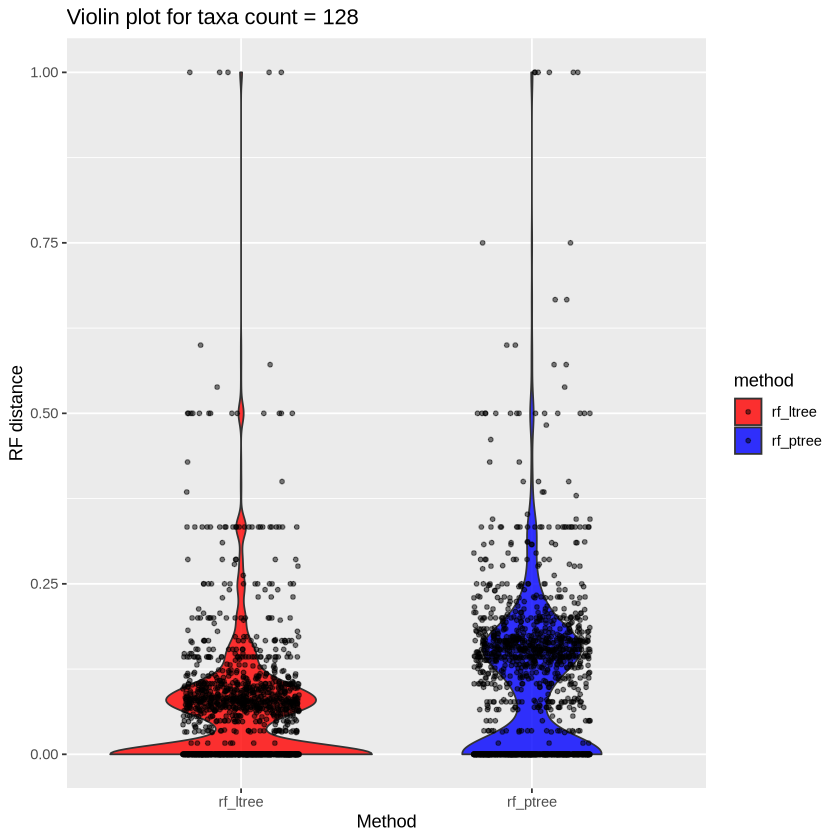

In [108]:
# install.packages("boot")

library(tidyverse)
library(boot)

compute_and_plot <- function(data, count) {
    # Filter the data for the given length
    data_length = data # filter(data, length == count)
    
    # Compute the 99% confidence interval for the difference in means
    ci <- boot(data = data_length, statistic = function(data, indices) {
        data_resampled <- data[indices, ]
        mean_diff <- mean(data_resampled$rf_ptree) - mean(data_resampled$rf_ltree)
        return(mean_diff)
    }, R = 1000) %>%
        boot.ci(type = "perc", conf = 0.99) %>%
        pluck("percent", "percent")

    print(ci)

    # Reshape the data for plotting
    data_length_long <- data_length %>%
    select(rf_ptree, rf_ltree) %>%
    pivot_longer(everything(), names_to = "method", values_to = "rf_dist")

    # Create a violin plot
    ggplot(data_length_long, aes(x = method, y = rf_dist, fill = method)) +
    geom_violin(alpha = 0.8) +
    geom_jitter(width = 0.2, size = 1, alpha = 0.5) +
    scale_fill_manual(values = c("rf_ptree" = "blue", "rf_ltree" = "red")) +
    labs(title = paste("Violin plot for taxa count =", count),
         x = "Method",
         y = "RF distance")
}

# Use the function
compute_and_plot(results, count = 128)



NULL


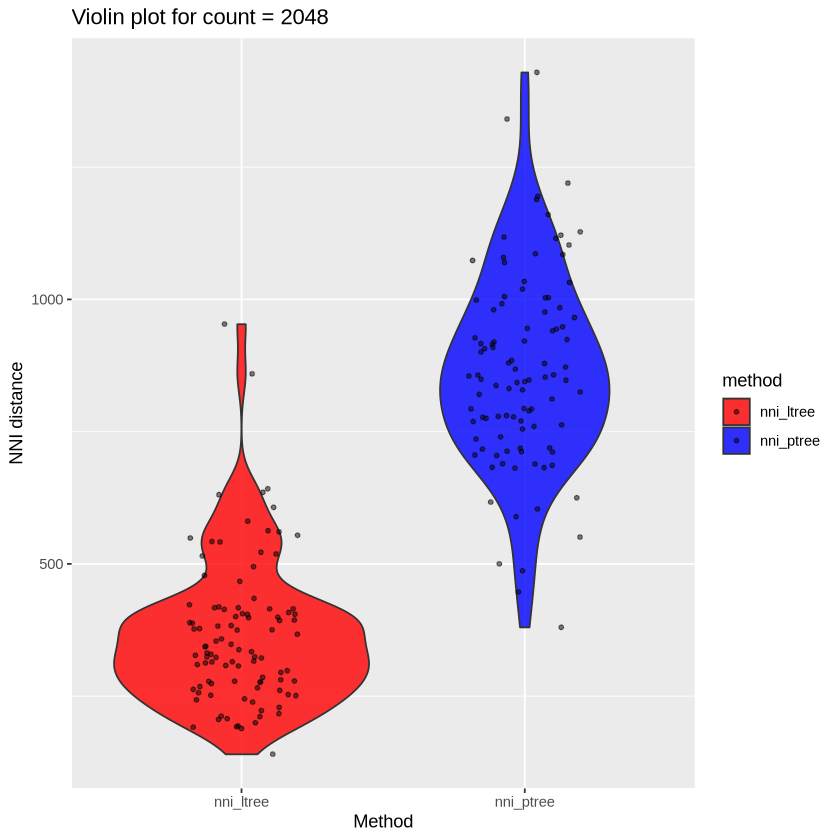

In [109]:
compute_and_plot_nni <- function(data, count) {
    # Filter the data for the given length
    data_length = filter(data, length == count)

    # Compute the 99% confidence interval for the difference in means
    ci <- boot(data = data_length, statistic = function(data, indices) {
        data_resampled <- data[indices, ]
        mean_diff <- mean(data_resampled$nni_ptree) - mean(data_resampled$nni_ltree)
        return(mean_diff)
    }, R = 1000) %>%
        boot.ci(type = "perc", conf = 0.99) %>%
        pluck("percent", "percent")

    print(ci)

    # Reshape the data for plotting
    data_length_long <- data_length %>%
    select(nni_ptree, nni_ltree) %>%
    pivot_longer(everything(), names_to = "method", values_to = "nni_dist")

    # Create a violin plot
    ggplot(data_length_long, aes(x = method, y = nni_dist, fill = method)) +
    geom_violin(alpha = 0.8) +
    geom_jitter(width = 0.2, size = 1, alpha = 0.5) +
    scale_fill_manual(values = c("nni_ptree" = "blue", "nni_ltree" = "red")) +
    labs(title = paste("Violin plot for count =", count),
         x = "Method",
         y = "NNI distance")
}

# Use the function
compute_and_plot_nni(results, count = 2048)


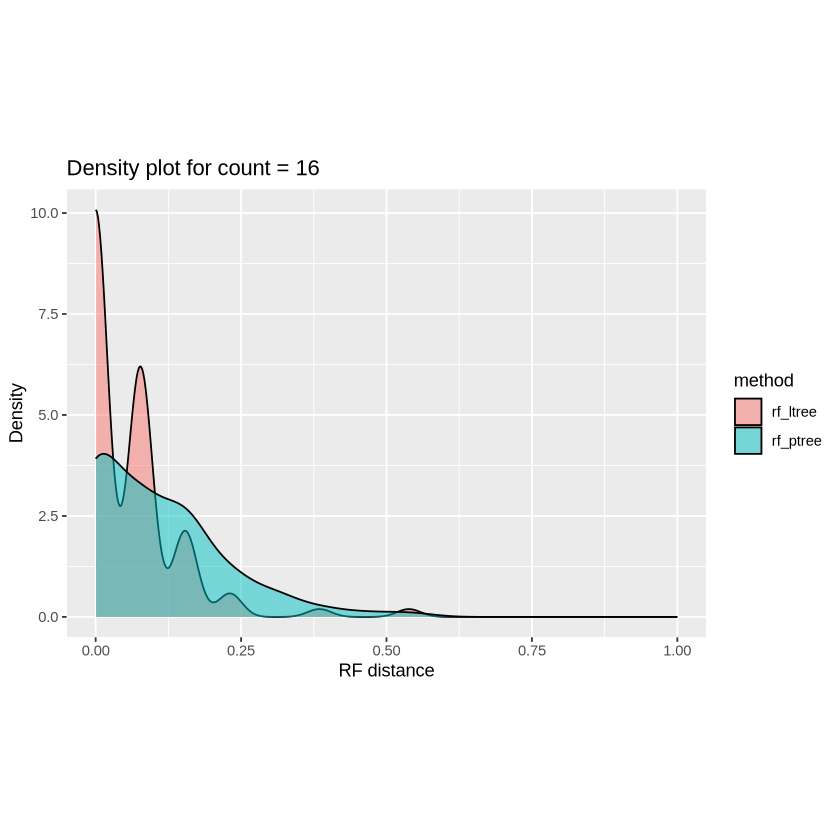

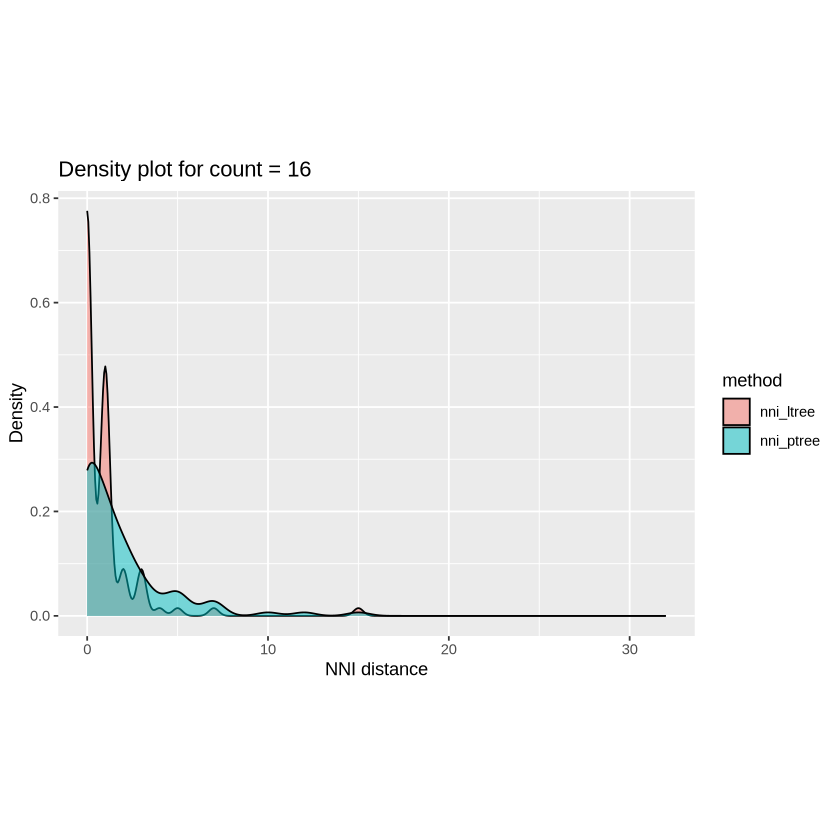

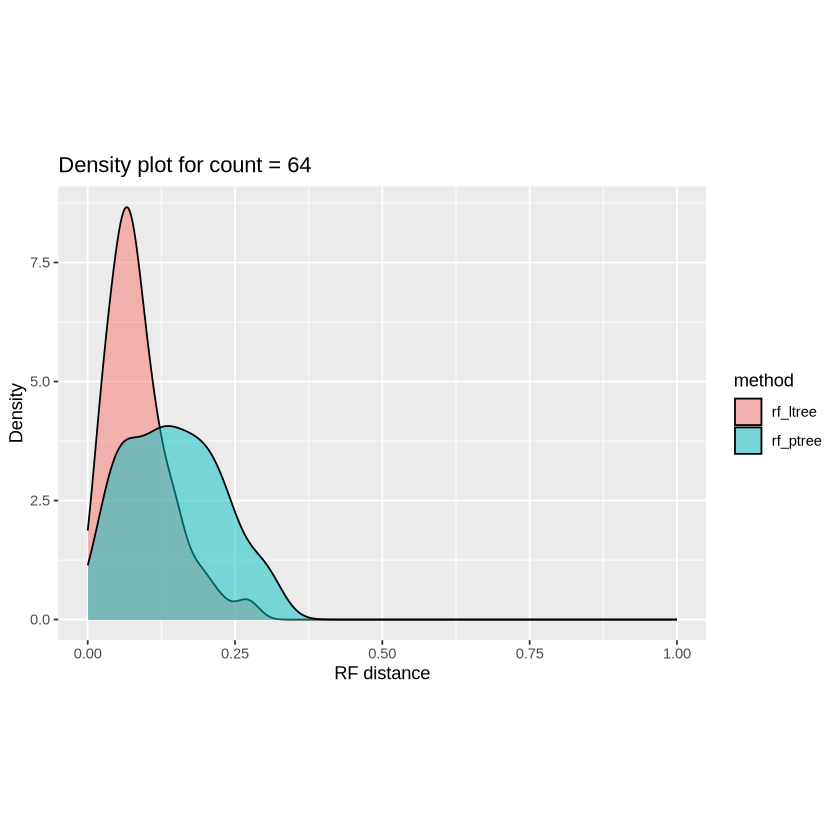

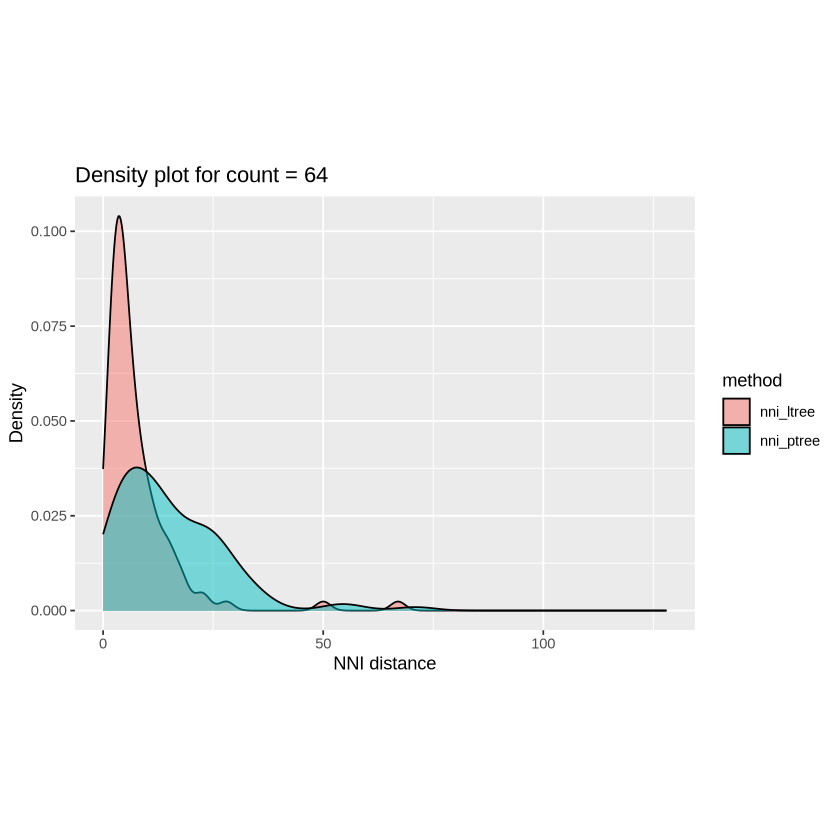

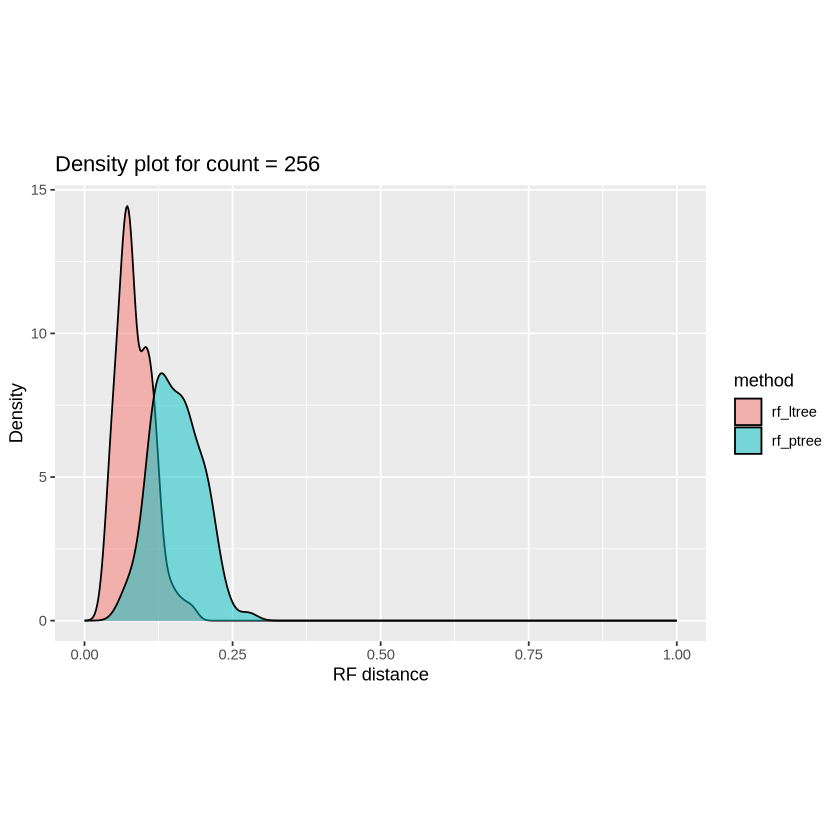

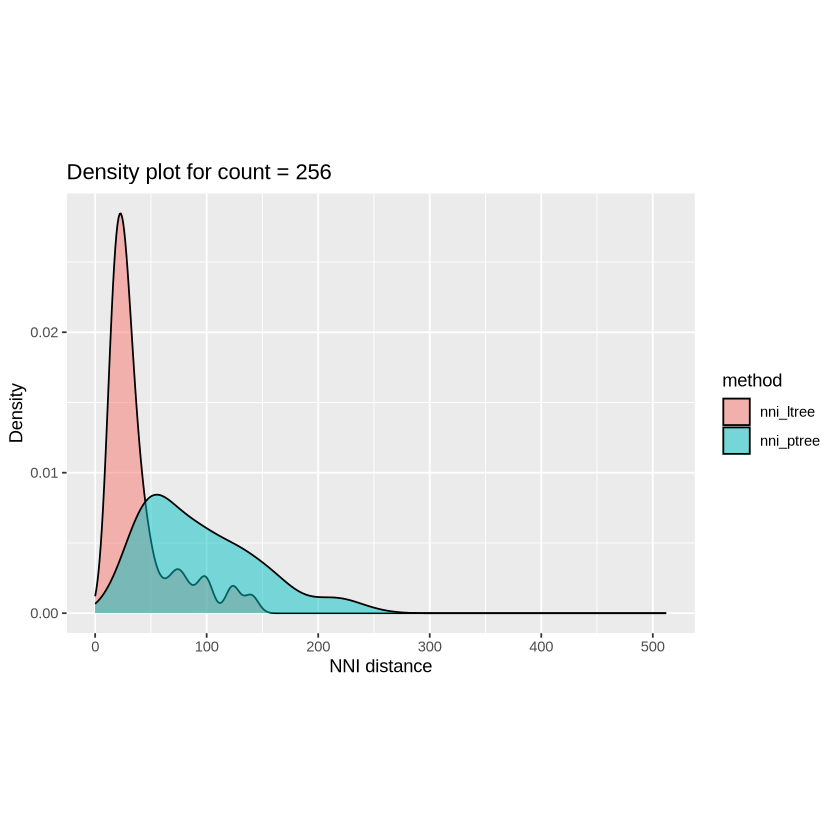

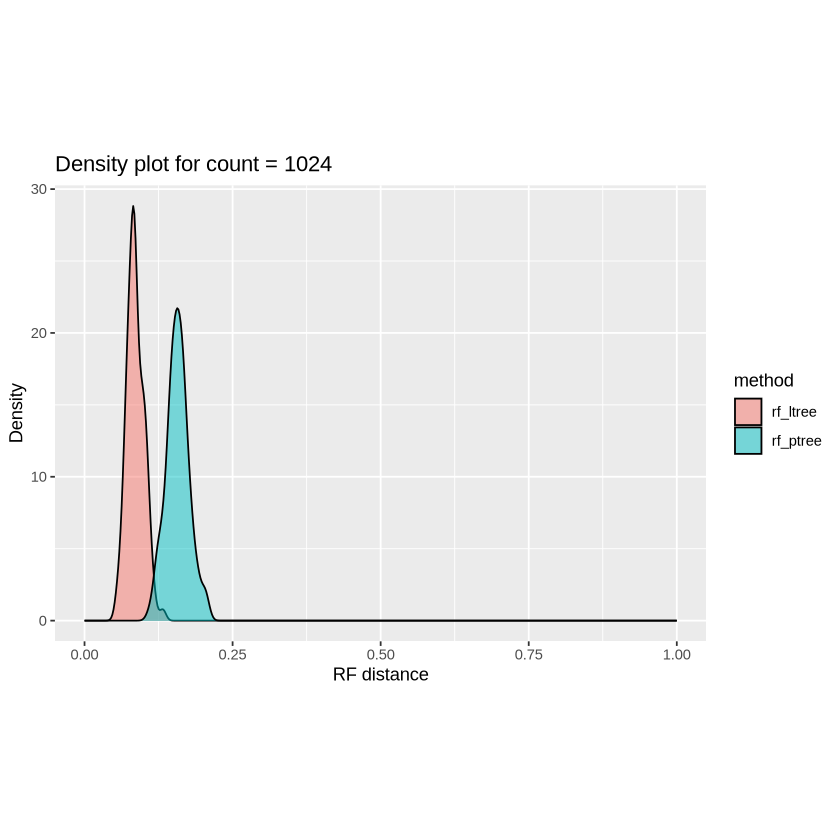

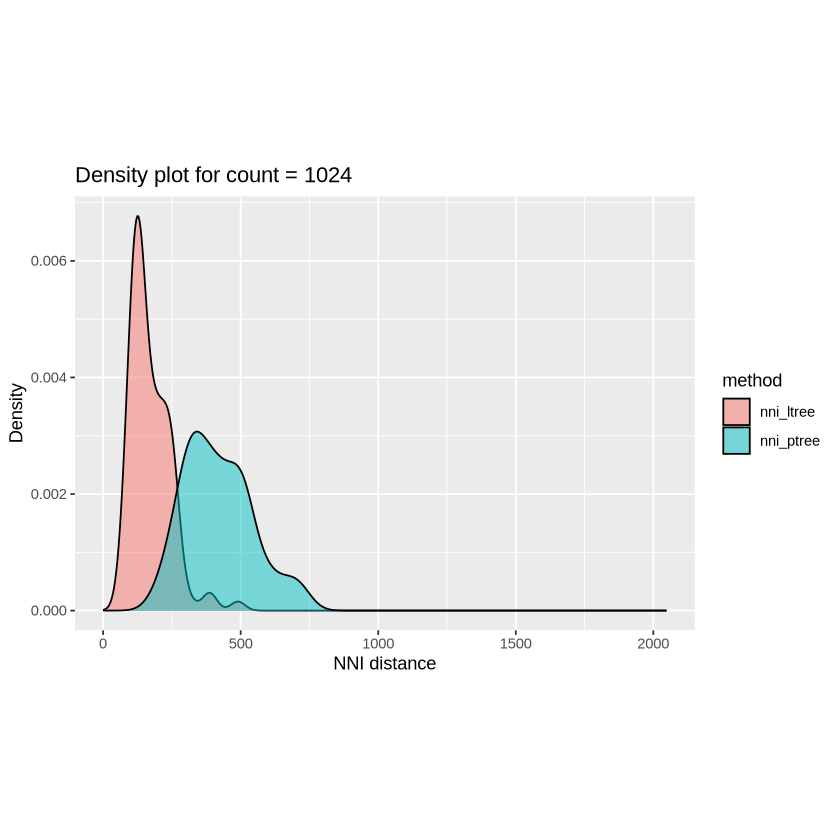

In [110]:
plot_density <- function(data, count) {
  # Filter the data for the given length
  data_length <- data %>%
    filter(length == count) %>%
    select(rf_ptree, rf_ltree) %>%
    pivot_longer(everything(), names_to = "method", values_to = "rf_dist")
  
  # Create a density plot
  p <- ggplot(data_length, aes(x = rf_dist, fill = method)) +
    geom_density(alpha = 0.5) +
    labs(title = paste("Density plot for count =", count),
         x = "RF distance",
         y = "Density")
    
    p <- p + xlim(0, 1)
    
      p <- p + theme(aspect.ratio = 0.7)
    
    print(p)

    
}

plot_density_nni <- function(data, count) {
  # Filter the data for the given length
  data_length <- data %>%
    filter(length == count) %>%
    select(nni_ptree, nni_ltree) %>%
    pivot_longer(everything(), names_to = "method", values_to = "nni_dist")
  
  # Create a density plot
  p <- ggplot(data_length, aes(x = nni_dist, fill = method)) +
    geom_density(alpha = 0.5) +
    labs(title = paste("Density plot for count =", count),
         x = "NNI distance",
         y = "Density")
    
    p <- p + xlim(0, count * 2)
    
      p <- p + theme(aspect.ratio = 0.7)
    
    print(p)
}
for (count in c(16, 64, 256, 1024)) {
    plot_density(results, count)
    plot_density_nni(results, count)
}


In [24]:
plot_boxplot <- function(data, length) {
  # Filter the data for the given length
  data_length <- data %>%
    filter(length == length) %>%
    select(rf_ptree, rf_ltree) %>%
    pivot_longer(everything(), names_to = "method", values_to = "rf_dist")
  
  # Create a boxplot
  ggplot(data_length, aes(x = method, y = rf_dist)) +
    geom_boxplot() +
    labs(title = paste("Boxplot for length =", length),
         x = "Method",
         y = "RF distance")
}

plot_boxplot_nni <- function(data, length) {
  # Filter the data for the given length
  data_length <- data %>%
    filter(length == length) %>%
    select(nni_ptree, nni_ltree) %>%
    pivot_longer(everything(), names_to = "method", values_to = "nni_dist")
  
  # Create a boxplot
  ggplot(data_length, aes(x = method, y = nni_dist)) +
    geom_boxplot() +
    labs(title = paste("Boxplot for length =", length),
         x = "Method",
         y = "NNI distance")
}



# A tibble: 700 × 6
   length  seed rf_ptree rf_ltree nni_ptree nni_ltree
    <int> <int>    <dbl>    <dbl>     <dbl>     <dbl>
 1      4     1        0        0         0         0
 2      4     2        0        0         0         0
 3      4     3        0        0         0         0
 4      4     4        0        0         0         0
 5      4     5        0        0         0         0
 6      4     6        0        0         0         0
 7      4     7        0        0         0         0
 8      4     8        1        1         1         1
 9      4     9        0        0         0         0
10      4    10        0        0         0         0
# ℹ 690 more rows


In [ ]:
plot_ecdf <- function(data, length) {
  # Filter the data for the given length
  data_length <- data %>%
    filter(length == length) %>%
    select(rf_ptree, rf_ltree) %>%
    pivot_longer(everything(), names_to = "method", values_to = "rf_dist")
  
  # Create an ECDF plot
  ggplot(data_length, aes(x = rf_dist, color = method)) +
    stat_ecdf() +
    labs(title = paste("ECDF plot for length =", length),
         x = "RF distance",
         y = "ECDF")
}

plot_ecdf_nni <- function(data, length) {
  # Filter the data for the given length
  data_length <- data %>%
    filter(length == length) %>%
    select(nni_ptree, nni_ltree) %>%
    pivot_longer(everything(), names_to = "method", values_to = "nni_dist")
  
  # Create an ECDF plot
  ggplot(data_length, aes(x = nni_dist, color = method)) +
    stat_ecdf() +
    labs(title = paste("ECDF plot for length =", length),
         x = "NNI distance",
         y = "ECDF")
}


In [111]:
compute_ci <- function(data, count) {
  # Filter the data for the given length
  data_length <- data %>%
    filter(length == count)
  
  # Compute the means
  mean_ptree <- mean(data_length$rf_ptree, na.rm = TRUE)
  mean_ltree <- mean(data_length$rf_ltree, na.rm = TRUE)
  
  # Compute the difference in means
  mean_diff <- mean_ptree - mean_ltree
  
  # Compute the standard deviations
  sd_ptree <- sd(data_length$rf_ptree, na.rm = TRUE)
  sd_ltree <- sd(data_length$rf_ltree, na.rm = TRUE)
  
  # Compute the sample sizes
  n_ptree <- sum(!is.na(data_length$rf_ptree))
  n_ltree <- sum(!is.na(data_length$rf_ltree))
  
  # Compute the standard error of the difference in means
  se_diff <- sqrt((sd_ptree^2 / n_ptree) + (sd_ltree^2 / n_ltree))
  
  # Compute the 95% confidence interval for the difference in means
  ci_lower <- mean_diff - qt(0.995, df = min(n_ptree, n_ltree) - 1) * se_diff
  ci_upper <- mean_diff + qt(0.995, df = min(n_ptree, n_ltree) - 1) * se_diff
  
  # Return a data frame with the results
  return(tibble(length = count,
                mean_diff = mean_diff,
                ci_lower = ci_lower,
                ci_upper = ci_upper))
}

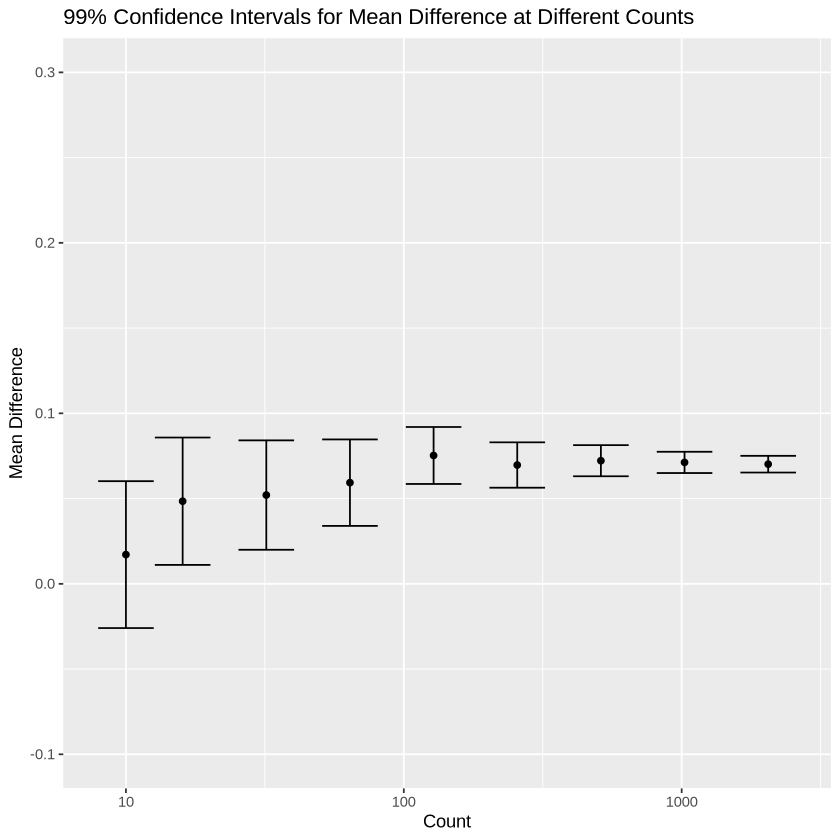

In [114]:
# Initialize an empty tibble
ci_results <- tibble()

# Compute the confidence intervals for all lengths
for (length in c(10, greaters)) {
  ci_results <- ci_results %>%
    bind_rows(compute_ci(results, length))
}

ggplot(ci_results, aes(x = length, y = mean_diff)) +
  geom_errorbar(aes(ymin = ci_lower, ymax = ci_upper), width = 0.2) +
  geom_point() +
  labs(x = "Count",
       y = "Mean Difference",
       title = "99% Confidence Intervals for Mean Difference at Different Counts") +
  scale_x_log10() + 
  ylim(-0.1, 0.3)


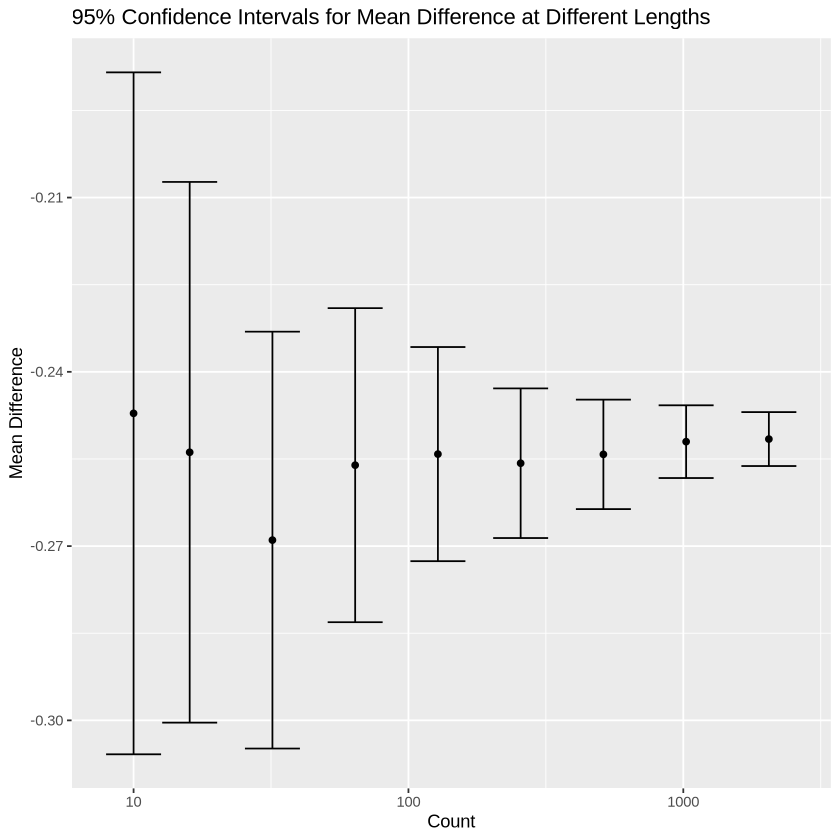

In [115]:
compute_ci <- function(data, count) {
  # Filter the data for the given length
  data_length <- data %>%
    filter(length == count)
  
  # Compute the means
  mean_ptree <- mean(data_length$nni_ptree, na.rm = TRUE)
  mean_ltree <- mean(data_length$nni_ltree, na.rm = TRUE)
  
  # Compute the difference in means
  mean_diff <- mean_ptree - mean_ltree
  
  # Compute the standard deviations
  sd_ptree <- sd(data_length$nni_ptree, na.rm = TRUE)
  sd_ltree <- sd(data_length$nni_ltree, na.rm = TRUE)
  
  # Compute the sample sizes
  n_ptree <- sum(!is.na(data_length$nni_ptree))
  n_ltree <- sum(!is.na(data_length$nni_ltree))
  
  # Compute the standard error of the difference in means
  se_diff <- sqrt((sd_ptree^2 / n_ptree) + (sd_ltree^2 / n_ltree))
  
  # Compute the 95% confidence interval for the difference in means
  ci_lower <- mean_diff - qt(0.995, df = min(n_ptree, n_ltree) - 1) * se_diff
  ci_upper <- mean_diff + qt(0.995, df = min(n_ptree, n_ltree) - 1) * se_diff
  
  # Return a data frame with the results
  return(tibble(length = count,
                mean_diff = mean_diff,
                ci_lower = ci_lower,
                ci_upper = ci_upper))
}

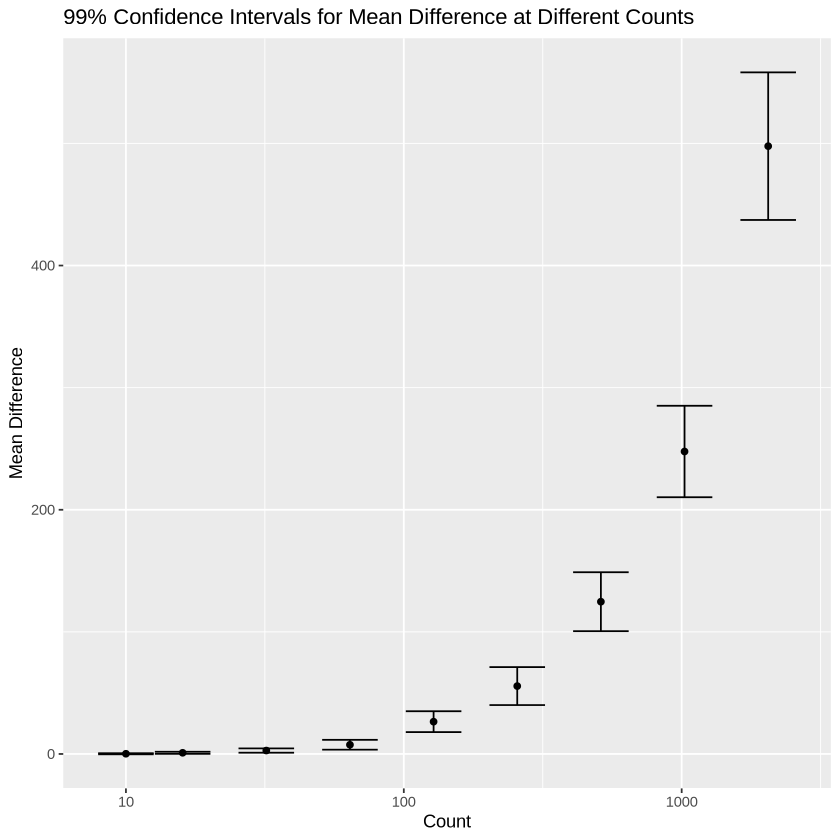

In [116]:
# Initialize an empty tibble
ci_results <- tibble()

# Compute the confidence intervals for all lengths
for (length in c(10, greaters)) {
  ci_results <- ci_results %>%
    bind_rows(compute_ci(results, length))
}

ggplot(ci_results, aes(x = length, y = mean_diff)) +
  geom_errorbar(aes(ymin = ci_lower, ymax = ci_upper), width = 0.2) +
  geom_point() +
  labs(x = "Count",
       y = "Mean Difference",
       title = "99% Confidence Intervals for Mean Difference at Different Counts") +
  scale_x_log10()
  # ylim(-0.5, 0)